# Principles of Data Science. Tiny Data Science Project
<b>Elnara Mammadova (210026788)</b>

## 1. Dataset, Background
https://www.equinor.com/en/what-we-do/digitalisation-in-our-dna/volve-field-data-village-download.html

For the first time, all subsurface and production data from a field on the Norwegian continental shelf - <b>VOLVE field</b> was disclosed by Equinor. Files were acquired thourgh Azure where all the dataset is stored. 

<a href="Equinor-HRS-Terms-and-conditions-for-licence-to-data-Volve.pdf">The Equinor HRS Terms and conditions for licence to data Volve</a>

We will produce petrophysical analysis of three wells from Volve field: 15/9-F-11 T2, 15/9-F-11 A, 15/9-F-11 B and provide facies classification based on the derived porosities and permeabilities. 

## 2. Wells' Information

15/9-F-11 will not be analysed, as the well path did not achieve sufficient separation from nearby wells, hence P&A before a technical side-track was performed for 15/9-F-11 T2.

<b>2.1. 15/9-F-11 T2 - Appraisal, Abandoned</b>

Objective of the 15/9-F-11 pilot well was to prove oil in the Volve North prospect segment and to define the field OWC. In addition the pilot was placed such that it could also prove a shallower Hugin interpretation based on the previous 2009 interpretation, which represents an additional prospect upside. 

The technical side-track, 15/9-F-11 T2, was kicked off from F-11 @ 257 m MD RKB. TD @ 4562 m MD RKB. Oil show is described on cuttings @ 4411 m MD.

These 2 residual oil pockets are observed in the following intervals: 
- 4393.8 – 4399 m MD RKB / 3182.3 – 3187.3 m TVD MSL,
- 4415.8 – 4419.7 m MD RKB / 3203.6 – 3207.4 m TVD MSL.

LWD log data is of good quality. No oil and water samples were taken since no commercial find.

<b>2.2. 15/9-F-11 A - Appraisal, Producing Oil</b>

Objective of the second pilot 15/9-F-11 A was to prove oil and sufficient reservoir thickness in the Northwest fault segment. 

15/9-F-11 A was side-tracked from F-11 T2 with KOP @ 2586 m MD RKB. TD @ 3762 m MD RKB. Oil Down To (ODT) ~ 3702 m MD RKB / 3025.5 m TVD MSL which corresponds to Top Sleipner Fm.

LWD log data is of good quality.
No water sample was taken since water was not encountered below the oil column.

<b>2.3. 15/9-F-11 B - Infill, Producing Oil Well</b>

Since 15/9-F-11 / F-11 T2 found no or insufficient oil in the Volve N prospect, the objectives of 15/9-F-11 B was
to be side-tracked to an infill location between existing producers F-12 and F-14 in the main field and downflank towards existing injector F-5. The aim was then to geosteer the well in the upper part of the Hugin reservoir, which was expected to be only partially drained.

15/9-F-11 B was side-tracked from F-11 T2 with KOP @ 2585 m MD RKB. TD @ 4770 m MD RKB. Hugin Fm. was oil filled in large parts of the well, and encountered also oil in the first part (shallowest) of Hugin Fm. Below ~ 4701 m MD RKB / 3148 m TVD MSL (a coal layer) the water seems to be initial, due to the low resistivity. 

LWD log data is of good quality. 8 intervals have been perforated. 

<i>Information acquired from Equinor Petrophysical Report, (November 2013)</i>

## 3. Import Libraries

In [1]:
# dataframe manipulation
import pandas as pd   
import numpy as np

# visulization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
import pylab
from matplotlib.ticker import ScalarFormatter
import ptitprince
import plotly.express as px

# Well Files loading and handling
from dlisio import dlis
from welly import Project, Well
import welly.quality as qty
import missingno as msno

# Modelling
from scipy.ndimage import median_filter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

# display options
from IPython.display import HTML
from IPython.display import Image
pd.set_option('display.max_rows', 100)  # Ensure that we can see pandas tables of up to 100 rows
pd.set_option('display.max_colwidth', None)  
# Set a default DPI for all figures in this file. Lower DPI gives smaller figures, higher bigger.
mpl.rcParams['figure.dpi'] = 70

In [2]:
mpl.__version__

'3.5.1'

In [3]:
sns.__version__

'0.11.2'

## 4. Load Wells

In [4]:
p_input = Project.from_las('data/input/*.las', index='m') # load all three dataset using project

3it [00:07,  2.47s/it]


In [5]:
p_input

Project(3 wells: F_11A, F_11B, F_11T2)

### 4.1 Quicklook Analysis

In [6]:
alias = {
    'Gamma': ['GR'],
    'Caliper': ['CALI'],
    'Density': ['RHOB'],
    'Neutron': ['NPHI'],
    'DTC': ['DT'],
    'DTS': ['DTS'],
    'DeepResistivity': ['RD'],
    'MediumResistivity': ['RM'],
    'TResistivity': ['RT']
}
keys = ['Gamma', 'Caliper', 'Density', 'Neutron', 'DTC', 'DTS', 'DeepResistivity', 'MediumResistivity', 'TResistivity']

input_wells_html = p_input.curve_table_html(keys=keys, alias=alias)

from IPython.display import HTML
HTML(input_wells_html)

In [7]:
input_wells = p_input.df()
input_wells = input_wells.drop(['ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', \
                                'DRHO','RPCEHM','RPCELM', 'RACEHM', 'RACELM'], axis=1) 
input_wells = input_wells.rename(columns={'RM':'RMED', 'RD':'RDEEP'})

# replacing non recording values as nan
input_wells = input_wells.replace(-999.000, np.nan)
input_wells.columns

Index(['BS', 'CALI', 'DT', 'DTS', 'GR', 'NPHI', 'PEF', 'RDEEP', 'RHOB', 'RMED',
       'ROP', 'RT'],
      dtype='object')

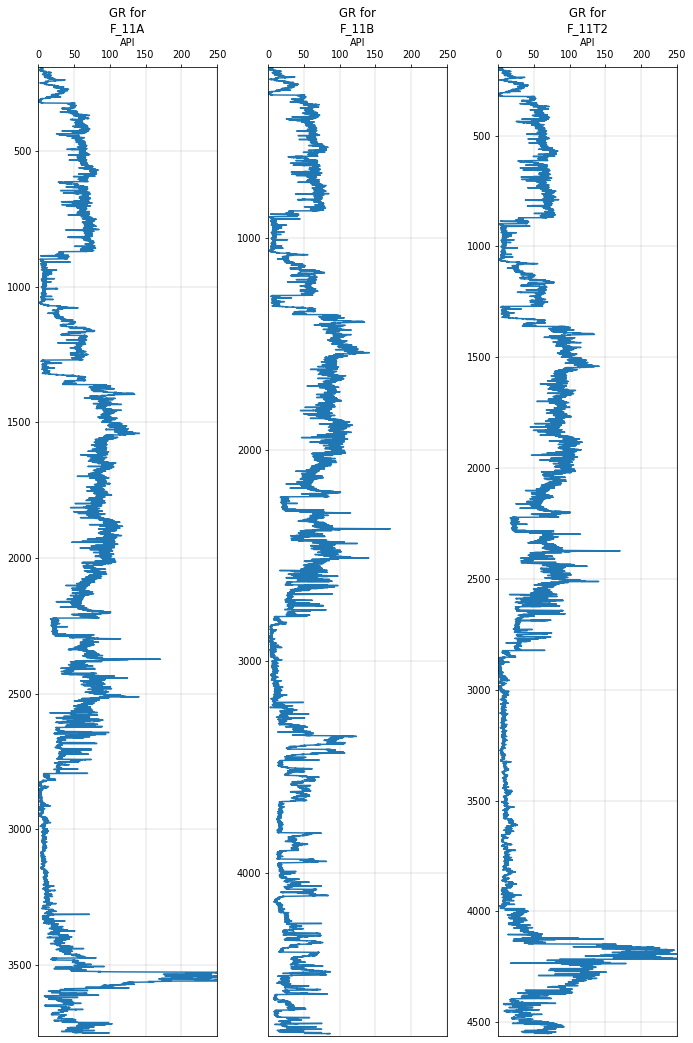

In [8]:
fig, axs = plt.subplots(figsize=(10, 15), ncols=len(p_input))
 
for i, (ax, w) in enumerate(zip(axs, p_input)):
    gr = w.data['GR']
    if gr is not None:
        ax = gr.plot(ax=ax)
    ax.set_title("GR for\n{}".format(w.uwi))

for ax in axs:
    ax.set_xlim([0, 250])
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
fig.tight_layout()


### 4.2. Load Well Las Files

In [9]:
F_11A_las = Well.from_las('data/input/F_11A.las', index='m')
F_11B_las = Well.from_las('data/input/F_11B.las', index='m')
F_11T2_las = Well.from_las('data/input/F_11T2.las', index='m')

#### 4.3. Well Headers

In [10]:
display(F_11A_las, F_11B_las, F_11T2_las)

Well(uwi: 'F_11A', 21 curves: ['ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BS', 'CALI', 'DRHO', 'DT', 'DTS', 'GR', 'NPHI', 'PEF', 'RACEHM', 'RACELM', 'RD', 'RHOB', 'RM', 'ROP', 'RPCEHM', 'RPCELM', 'RT'])

Well(uwi: 'F_11B', 19 curves: ['ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BS', 'CALI', 'DRHO', 'GR', 'NPHI', 'PEF', 'RACEHM', 'RACELM', 'RD', 'RHOB', 'RM', 'ROP', 'RPCEHM', 'RPCELM', 'RT'])

Well(uwi: 'F_11T2', 21 curves: ['ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'BS', 'CALI', 'DRHO', 'DT', 'DTS', 'GR', 'NPHI', 'PEF', 'RACEHM', 'RACELM', 'RD', 'RHOB', 'RM', 'ROP', 'RPCEHM', 'RPCELM', 'RT'])

- GR : GRCFM from OnTrak -- GAMMA RAY
- RHOB : BDCFM from LithoTrak -- DENSITY
- NPHI : NPCKLFM from LithoTrak -- NEUTRON POROSITY
- PEF : DPEFM from LithoTrak -- PHOTOELECTRIC FACTOR
- RDEEP : RPCEHM from OnTrak -- DEEP RESISTIVITY
- RMED : RPCELM from OnTrak -- MEDIUM RESISTIVITY
- CALI : CALCM from UltraSonic Caliper, part of LithoTrak -- CALIPER

#### 4.4. QC

In [11]:
alias = {
    'Gamma': ['GR'],
    'Caliper': ['CALI'],
    'Density': ['RHOB'],
    'Neutron': ['NPHI'],
    'DTC': ['DT'],
    'DTS': ['DTS'],
    'DeepResistivity': ['RDEEP'],
    'MediumResistivity': ['RMED'],
}
tests = {
    'All': [qty.no_similarities],
    'Each': [
        qty.no_flat,
        qty.no_monotonic,
        qty.no_gaps,
    ],
    'Gamma': [
        qty.all_positive,
        qty.all_below(450),
        qty.mean_between(10, 100),
        qty.check_units(['API', 'GAPI']),
    ],
    'Density': [
        qty.mean_between(1000,3000),
        qty.all_positive,
    ]
    }


In [12]:
html_f11a = F_11A_las.qc_table_html(tests, alias=alias)
HTML(html_f11a)

In [13]:
html_f11b = F_11B_las.qc_table_html(tests, alias=alias)
HTML(html_f11b)

In [14]:
html_f11t2 = F_11T2_las.qc_table_html(tests, alias=alias)
HTML(html_f11t2)

#### 4.5. Convert Well objects to DataFrames

In [15]:
f_11a = F_11A_las.df()
f_11b = F_11B_las.df()
f_11t2 = F_11T2_las.df()

In [16]:
# Drop unnecessary columns and rename resistivity curves to Deep and Medium
f_11a= f_11a.drop(['ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'DRHO', 'RPCELM', 'RPCEHM',\
                   'RACEHM', 'RACELM'], axis=1).rename(columns={'RM':'RMED', 'RD':'RDEEP'})
f_11b= f_11b.drop(['ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'DRHO', 'RPCELM', 'RPCEHM', \
                   'RACEHM', 'RACELM'], axis=1).rename(columns={'RM':'RMED', 'RD':'RDEEP'})
f_11t2 = f_11t2.drop(['ABDCQF01', 'ABDCQF02', 'ABDCQF03', 'ABDCQF04', 'DRHO', 'RPCELM', 'RPCEHM',\
                      'RACEHM', 'RACELM'], axis=1).rename(columns={'RM':'RMED', 'RD':'RDEEP'})

#### 4.6. Formation Tops (reservoir section)

F_11T2
- tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
- tops_depths=[4334.7, 4393.0, 4497.4]

F_11A 
- tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
- tops_depths=[3574.9, 3594.6, 3702]

F_11B
- tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
- tops_depths=[3351, 3467.5, 4732]

In [17]:
f_11a = f_11a.loc[3550:]
f_11b = f_11b.loc[3250:]
f_11t2 = f_11t2.loc[4300:]

In [18]:
display(f_11t2.info(), f_11a.info(), f_11b.info())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2617 entries, 4300.0999999962605 to 4561.699999996023
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BS      2617 non-null   float64
 1   CALI    2383 non-null   float64
 2   DT      2223 non-null   float64
 3   DTS     2129 non-null   float64
 4   GR      2509 non-null   float64
 5   NPHI    2362 non-null   float64
 6   PEF     2389 non-null   float64
 7   RDEEP   2530 non-null   float64
 8   RHOB    2389 non-null   float64
 9   RMED    2530 non-null   float64
 10  ROP     2617 non-null   float64
 11  RT      2530 non-null   float64
dtypes: float64(12)
memory usage: 265.8 KB
<class 'pandas.core.frame.DataFrame'>
Float64Index: 2119 entries, 3550.0999999969426 to 3761.89999999675
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BS      2119 non-null   float64
 1   CALI    1887 non-null   float64
 2   DT      1

None

None

None

In [19]:
display(f_11t2.describe(), f_11a.describe(), f_11b.describe())

BS         CALI           DT          DTS           GR  \
count  2617.0  2383.000000  2223.000000  2129.000000  2509.000000   
mean      8.5     8.700106    79.578290   136.162160    58.579648   
std       0.0     0.041914     9.369201    22.138732    31.799157   
min       8.5     8.625000    48.928000    74.823000     7.819000   
25%       8.5     8.672000    74.168500   124.012000    32.296000   
50%       8.5     8.688000    79.426000   134.423000    50.907000   
75%       8.5     8.703000    85.679000   146.683000    87.882000   
max       8.5     8.992000   108.353000   193.837000   138.126000   

              NPHI          PEF        RDEEP         RHOB         RMED  \
count  2362.000000  2389.000000  2530.000000  2389.000000  2530.000000   
mean      0.194674     6.488420     1.974713     2.468832     3.560326   
std       0.073044     0.940238     3.610343     0.117950    14.183939   
min      -0.003000     4.836000     0.308000     2.092000     0.186000   
25%       0.154000     5.729000     0.685000     2.389000     0.669000   
50%       0.184000     6.534000     1.556000     2.468000     1.601500   
75%       0.248000     6.945000     1.969000     2.536000     2.173750   
max       0.424000    11.537000    46.339000     3.004000   222.752000   

               ROP           RT  
count  2617.000000  2530.000000  
mean     15.601705     3.560326  
std       4.114881    14.183939  
min       2.994000     0.186000  
25%      14.846000     0.669000  
50%      14.912000     1.601500  
75%      14.976000     2.173750  
max      24.977000   222.752000

BS         CALI           DT          DTS           GR  \
count  2119.0  1887.000000  1733.000000  1731.000000  2013.000000   
mean      8.5     8.653714    85.576521   142.823392    64.577150   
std       0.0     0.041353     9.743490    24.228476    83.470312   
min       8.5     8.563000    54.280000    83.574000     8.477000   
25%       8.5     8.625000    80.467000   130.420500    31.852000   
50%       8.5     8.625000    85.819000   138.737000    43.011000   
75%       8.5     8.672000    90.232000   145.173500    70.009000   
max       8.5     8.781000   116.841000   232.579000  1124.403000   

              NPHI          PEF        RDEEP         RHOB          RMED  \
count  1866.000000  1894.000000  2034.000000  1894.000000   2034.000000   
mean      0.208885     6.244515     7.021754     2.394854    565.235335   
std       0.077263     1.219494    15.665864     0.157564   5519.676446   
min       0.046000     4.856000     0.084000     2.153000      0.103000   
25%       0.161000     5.402000     1.471000     2.259000      1.494250   
50%       0.203000     5.940500     2.245500     2.382500      2.656000   
75%       0.237000     6.824500     4.872750     2.495750      5.759000   
max       0.460000    13.841000   202.159000     3.025000  62290.770000   

               ROP            RT  
count  2119.000000   2034.000000  
mean     18.594912    565.235335  
std       2.372443   5519.676446  
min       0.341000      0.103000  
25%      18.193000      1.494250  
50%      19.708000      2.656000  
75%      19.762000      5.759000  
max      20.257000  62290.770000

BS          CALI            GR          NPHI           PEF  \
count  15202.0  14967.000000  15093.000000  14947.000000  14973.000000   
mean       8.5      8.656648     34.477189      0.186335      5.493072   
std        0.0      0.072055     19.906375      0.057697      1.378680   
min        8.5      8.318000      8.196000      0.024000      3.647000   
25%        8.5      8.625000     18.072000      0.157000      4.414000   
50%        8.5      8.641000     29.341000      0.179000      5.061000   
75%        8.5      8.672000     44.460000      0.211000      6.264000   
max        8.5      9.175000    123.362000      0.541000     11.229000   

              RDEEP          RHOB          RMED           ROP            RT  
count  14897.000000  14973.000000  15114.000000  15181.000000  15114.000000  
mean      35.438277      2.390699   2307.739135     24.328098   2307.739135  
std      171.985922      0.180675  11577.810754      7.099012  11577.810754  
min        0.320000      1.627000      0.140000      2.808000      0.140000  
25%        2.446000      2.225000      3.131500     19.800000      3.131500  
50%        6.532000      2.365000      8.161500     28.220000      8.161500  
75%       31.569000      2.547000     54.348500     29.959000     54.348500  
max     5456.299000      3.090000  62290.770000     34.864000  62290.770000

<i>Well F_11B doesn't have Sonic logs (DT, DTC)</i>

## 5. Vertical Composite - Raw curves

In [20]:
# https://andymcdonaldgeo.medium.com/loading-and-displaying-well-log-data-b9568efd1d8

def plotalllogs1(dataframe):
#=============================================================================    
    tracks=4
    linewidth=0.5
    ## Gamma Ray
    trackGR=0 #Gamma Ray
    ## Resistivity
    trackRes=1
    ## Porosity
    trackPOR=2
    ## PEF
    trackPE=3 

#=============================================================================    
    pylab.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (10,20)})
    fig,axes = plt.subplots(1,tracks,sharey=True,figsize=(15,15), dpi=90) ##sharey: share y axis
    fig.gca().invert_yaxis()
    
    for ax in axes:
        for (i,j) in zip(tops_depths,tops):
                ax.axhline(y=i, linewidth=1, color='red')
                ax.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')
# =============================================================================

    ## GR
    ax1 = axes[trackGR]
    ax1.grid(which='both')
    # ax1.grid(which='major', linestyle='-', linewidth='0.5', color='lime')
    # ax1.grid(which='minor', linestyle=':', linewidth='1', color='black')
    ax1.plot(dataframe['GR'],dataframe.index, label='GR', color='green', lw=2)
    ax1.set_xlabel('GR, GAPI')
    ax1.set_xlim(0,250)
    ax1.set_xticks([0, 50, 100, 150, 200, 250])

    # https://towardsdatascience.com/enhancing-visualization-of-well-logs-with-plot-fills-72d9dcd10c1b
    left_value = 0
    right_value = 250
    span = abs(left_value-right_value)
    cmap = plt.get_cmap('hot_r')
    color_index = np.arange(left_value, right_value, span/100)
    
    for index in sorted(color_index):
        index_value =(index-left_value)/span
        color = cmap(index_value)
        ax1.fill_betweenx(dataframe.index, 0, dataframe['GR'], where=dataframe['GR']>=index, color=color)
    # ax1.fill_betweenx(dataframe.index, 100, dataframe['GR'], where=dataframe['GR']<=100, facecolor='yellow')
    # ax1.fill_betweenx(dataframe.index, dataframe['GR'], 100, where=dataframe['GR']>=100, facecolor='green')
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    
    ## CALI
    ax2 = axes[trackGR].twiny()
    # ax2.grid(which='both')
    ax2.plot(dataframe['CALI'],dataframe.index, label='CALI', color='magenta', lw=linewidth)
    ax2.set_xlabel('CALI, IN')
    ax2.set_xlim(5,10)
    ax2.set_xticks([5, 6, 7, 8, 9, 10])
    ax2.spines['top'].set_position(('outward', 20))
    ax2.xaxis.set_ticks_position('top')
    ax2.xaxis.set_label_position('top')    
    
    ## ROP
    ax3 = axes[trackGR].twiny()
    # ax3.grid(which='both')
    ax3.plot(dataframe['ROP'],dataframe.index, label='ROP', ls = '--', color='slateblue', lw=linewidth)
    ax3.set_xlabel('ROP, m/hr')
    ax3.set_xlim(0,100)
    ax3.spines['top'].set_position(('outward', 60))
    ax3.xaxis.set_ticks_position('top')
    ax3.xaxis.set_label_position('top')
    
#===============================================================================

    # Resistivity   
    ax1 = axes[trackRes]
    ax1.set_xscale('log')
    ax1.grid(which='both')
    ax1.plot(dataframe['RDEEP'],dataframe.index, label='RDEEP', color='cyan', lw=linewidth)
    ax1.plot(dataframe['RMED'],dataframe.index, label='RMED',color='darkblue', ls = '--', lw=linewidth)
    ax1.plot(dataframe['RT'],dataframe.index, label='RT',color='darkviolet', ls = '--', lw=linewidth)
    ax1.set_xlabel('Resistivity, ohm.m')
    ax1.legend(loc=1)
    ax1.set_xlim(0.2,2000)
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.set_xticks([1, 10, 100, 1000])
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    
# =============================================================================

    ## RHOB
    ax1 = axes[trackPOR].twiny()
    ax1.plot(dataframe['RHOB'],dataframe.index, label=r'$\rho_b$', color='red', lw=1)
    ax1.set_xlabel(r'$\rho_b, g/cc$')
    ax1.set_xlim(1.95,2.95)
    ax1.set_xticks([1.95, 2.2, 2.45, 2.7, 2.95])
    ax1.spines['top'].set_position(('outward', 40))
    ax1.spines['top'].set_edgecolor('red')
    ax1.xaxis.set_ticks_position('top') # set the position of the second x-axis to top
    #ax1.tick_params(axis='x', colors='red')
    ax1.xaxis.set_label_position('top') # set the position of the second x-axis to top
    ax1.legend(bbox_to_anchor=(0.6, .9))
    
    ##NPHI
    ax2 = axes[trackPOR]
    ax2.grid(which='both')
    ax2.plot(dataframe['NPHI'],dataframe.index, label=r'$\phi_N$', color='blue', lw=2)
    ax2.set_xlim(0.45, -0.15)
    ax2.set_xlabel(r'$\phi_N$, %') 
    ax2.legend(bbox_to_anchor=(0.6, 1))
    ax2.xaxis.set_label_position('top') # set the position of the second x-axis to top
    ax2.xaxis.set_ticks_position('top')
    ax2.set_xticks([0.6, 0.45, 0.3, 0.15, 0])
    
    # https://towardsdatascience.com/enhancing-visualization-of-well-logs-with-plot-fills-72d9dcd10c1b
    x1=dataframe['RHOB']
    x2=dataframe['NPHI']
    x = np.array(ax1.get_xlim())
    z = np.array(ax2.get_xlim())
    nz=((x2-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)
    ax1.fill_betweenx(dataframe.index, x1, nz, where=x1>=nz, interpolate=True, color='green')
    ax1.fill_betweenx(dataframe.index, x1, nz, where=x1<=nz, interpolate=True, color='yellow')
    
# ====================================trackPE=========================================   
    ##PE
    ax1 = axes[trackPE]
    ax1.grid(which='both')
    ax1.plot(dataframe['PEF'],dataframe.index, label='PE', lw=linewidth)
    ax1.set_xlabel('PE, barns/electron')
    ax1.set_xlim(-5,10)
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')  


##### 5.1. F_11T2 Plot

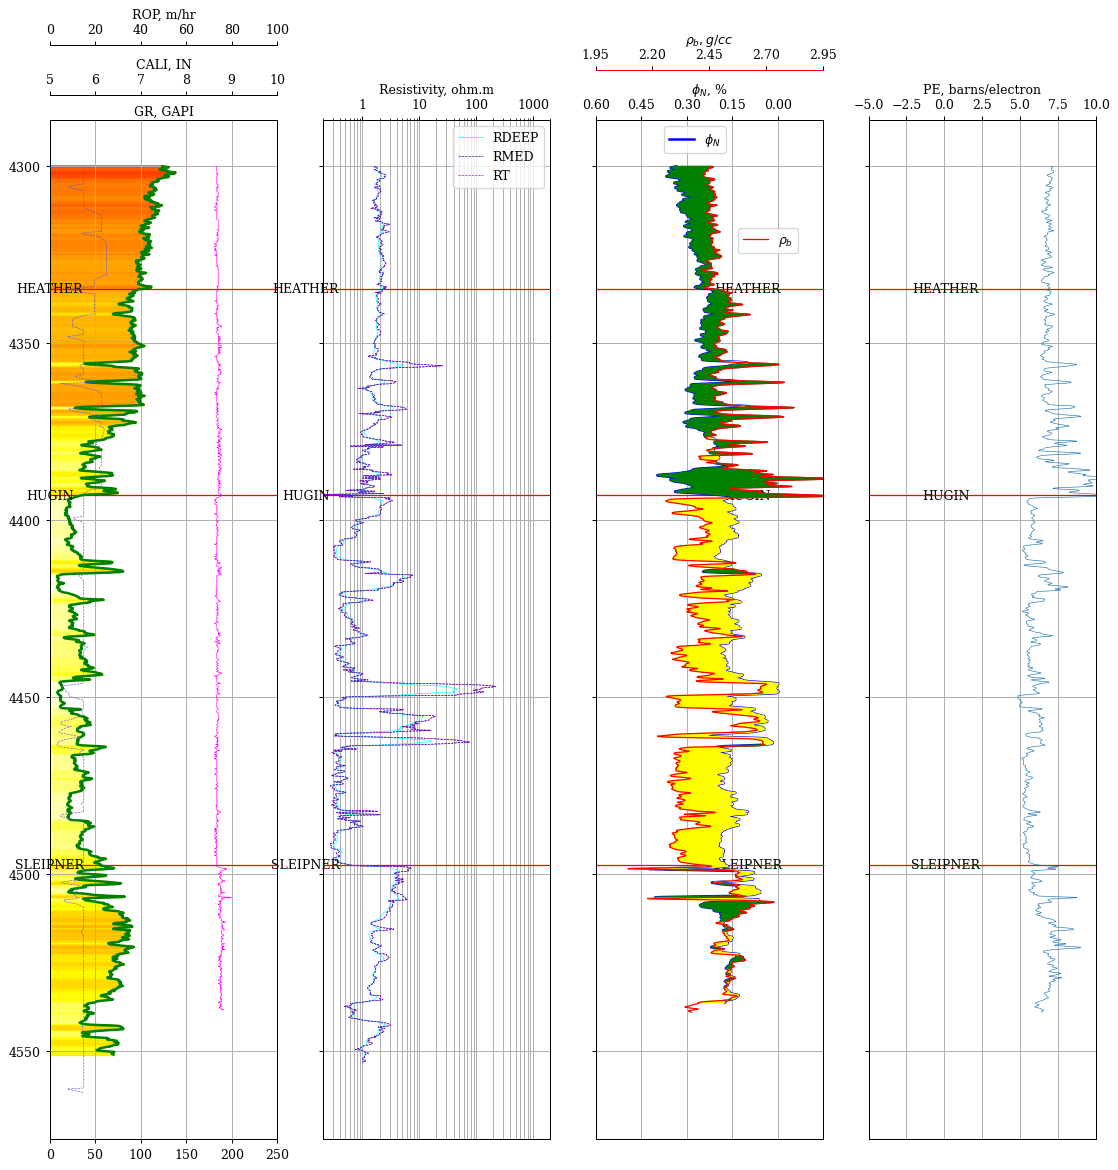

In [21]:
tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
tops_depths=[4334.7, 4393.0, 4497.4]
plotalllogs1(f_11t2)

##### 5.2. F_11A Plot

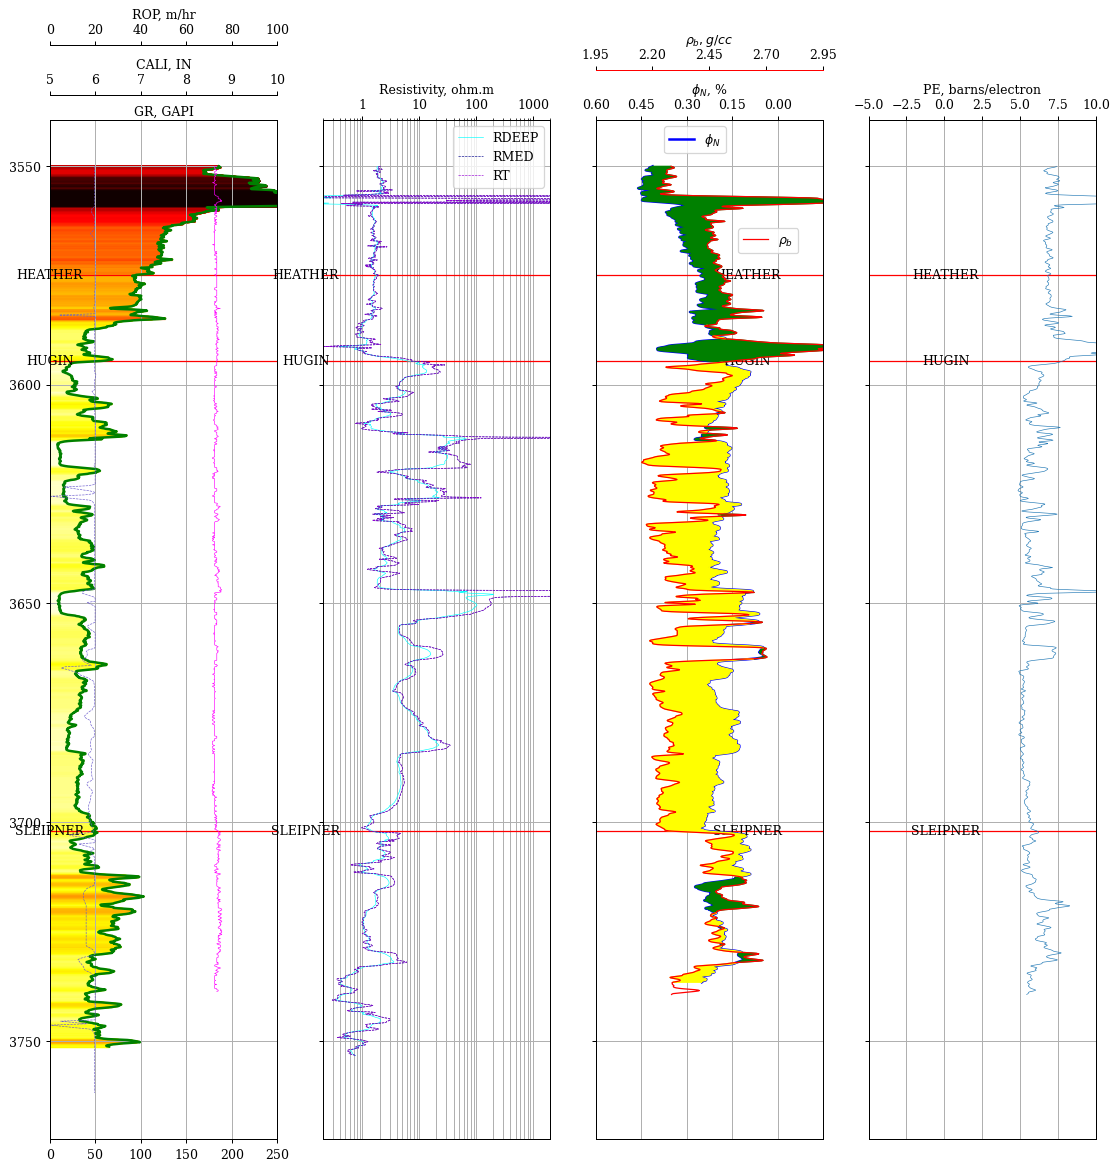

In [22]:
tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
tops_depths=[3574.9, 3594.6, 3702]
plotalllogs1(f_11a)

##### 5.3. F_11B Plot

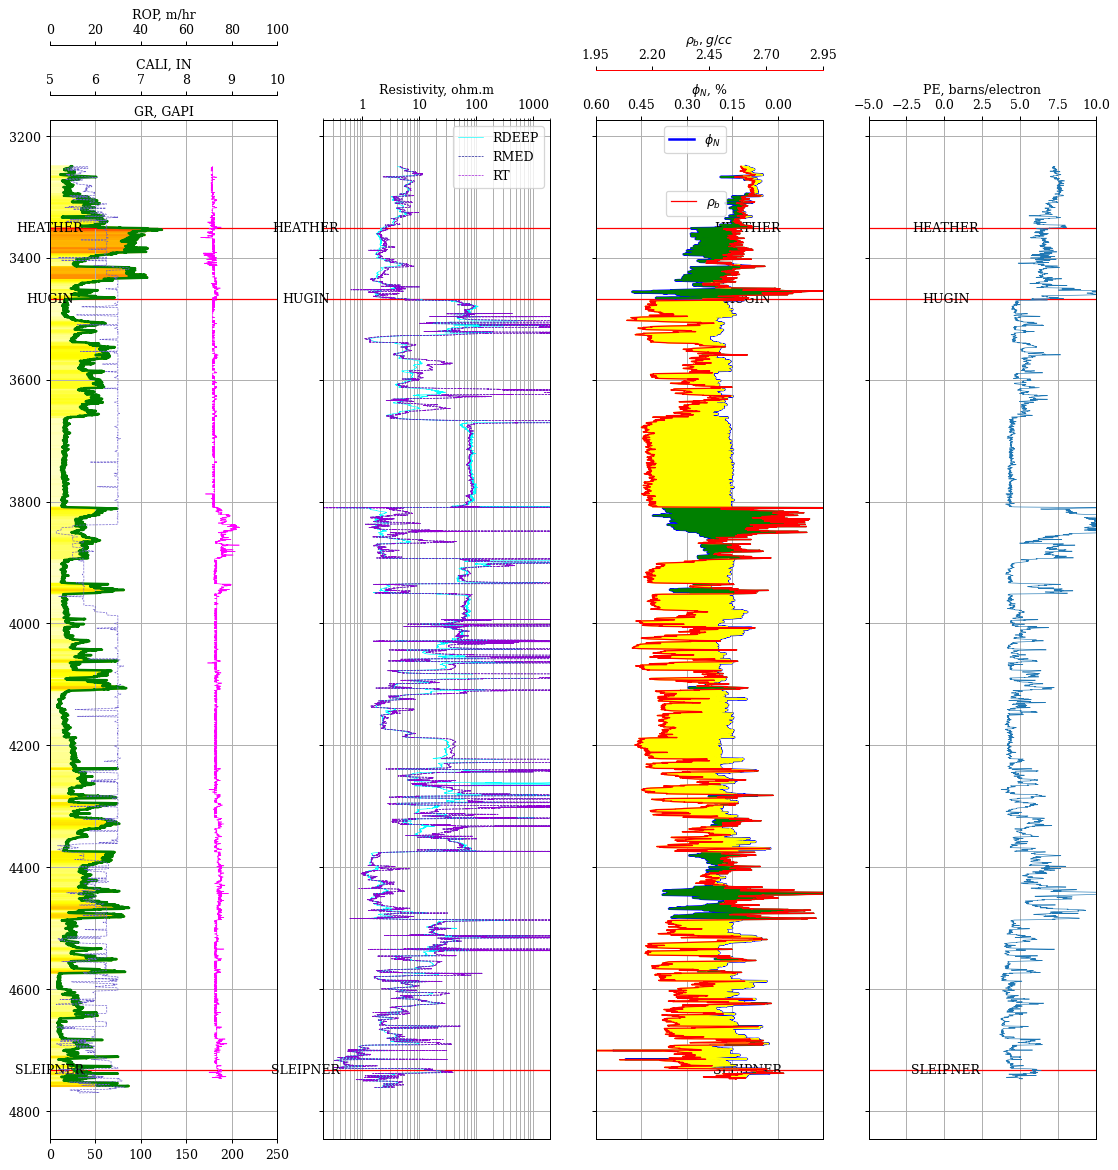

In [23]:
tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
tops_depths=[3351, 3467.5, 4732]
plotalllogs1(f_11b)

## 6. Data Preparation

### 6.1. Outlier and noise Detection - visual analysis

#### 6.1.1. MSNO plots

<AxesSubplot:>

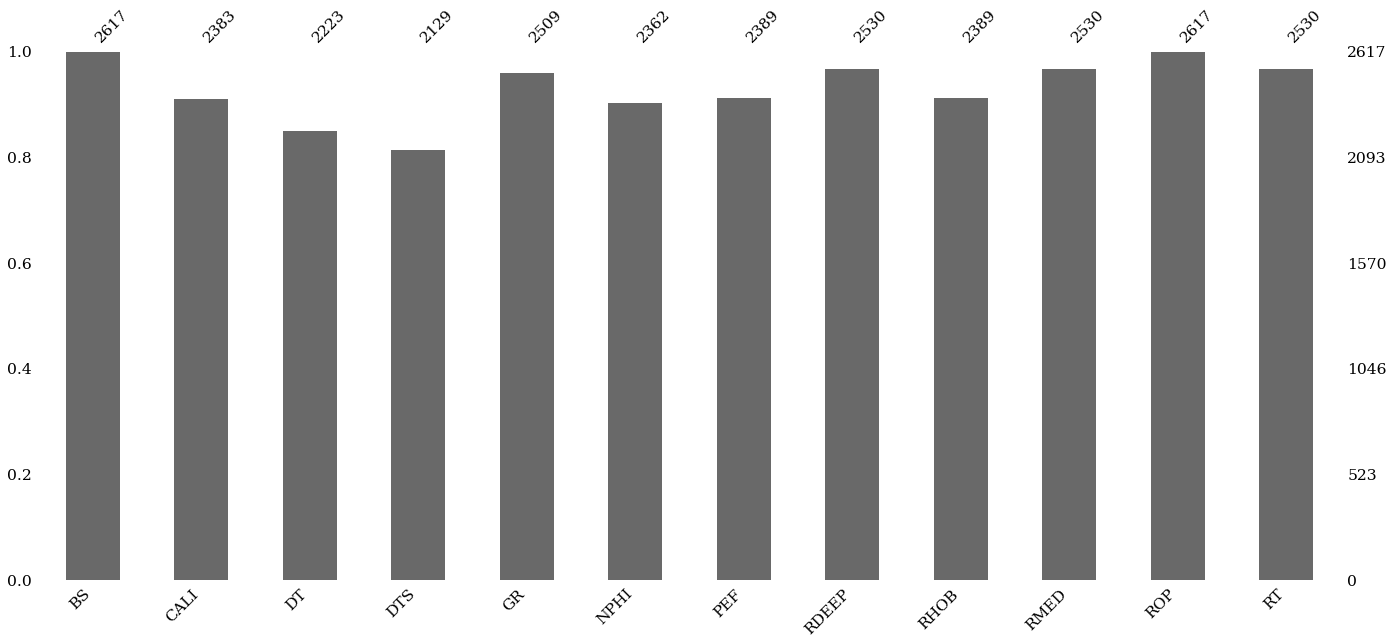

In [24]:
### Check for missing values
msno.bar(f_11t2)

<AxesSubplot:>

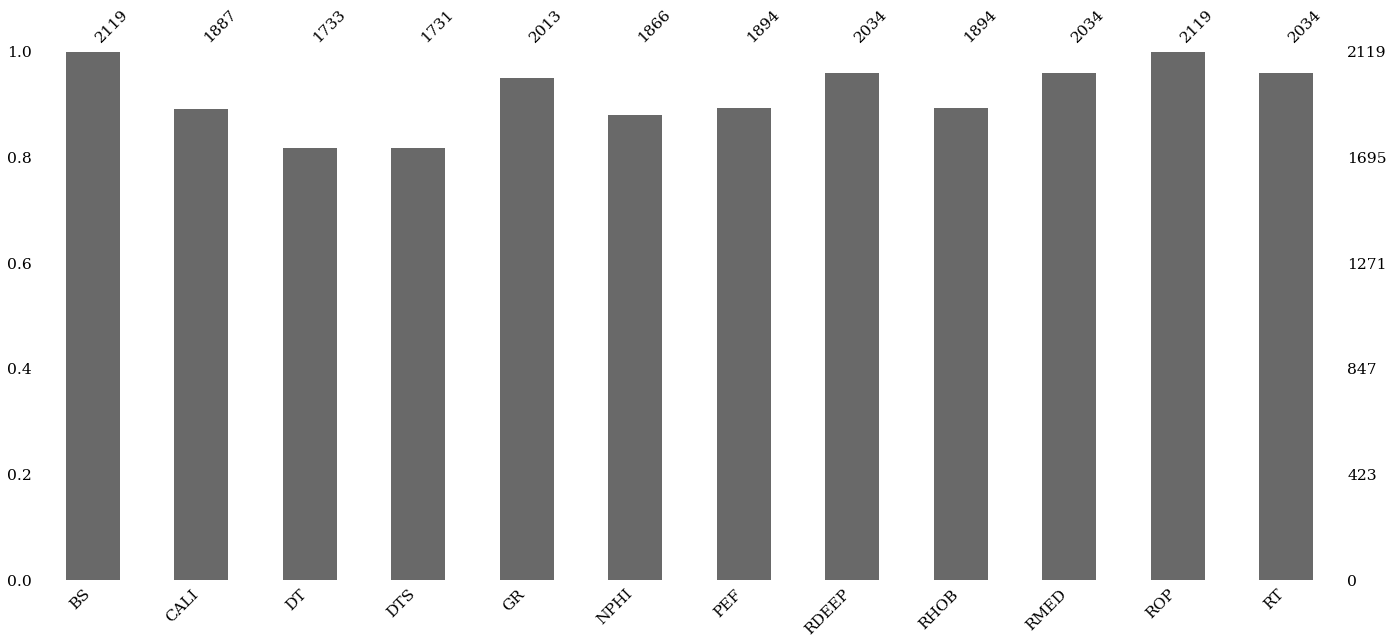

In [25]:
msno.bar(f_11a)

<AxesSubplot:>

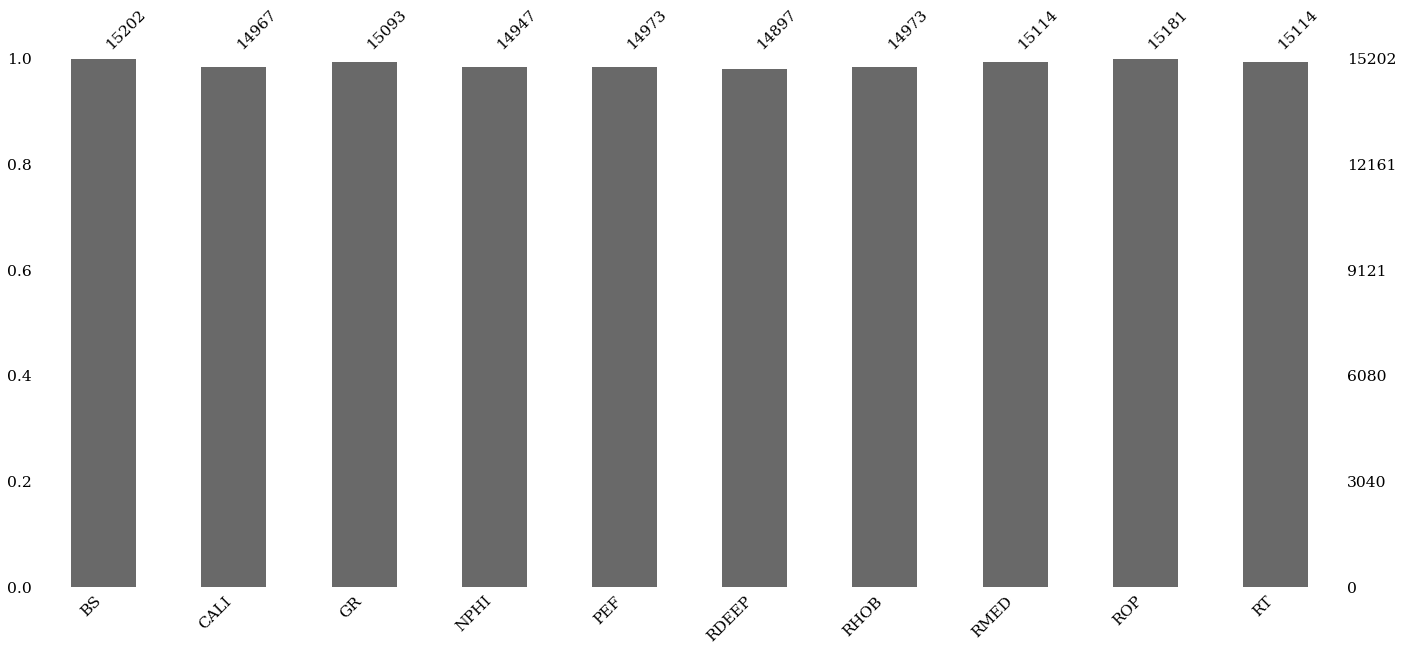

In [26]:
msno.bar(f_11b)

Missing data are towards the leg of the legs, since the measurements are spaced along the tool length. We can go ahead and remove all the nan values. 

In [27]:
f_11t2 = f_11t2.dropna()
f_11a = f_11a.dropna()
f_11b = f_11b.dropna()

#### 6.1.2. BoxPlots

In [28]:
# https://towardsdatascience.com/well-log-data-outlier-detection-with-machine-learning-a19cafc5ea37
def make_boxplot(welldata, inputs):

    num_inputs = len(inputs)

    fig, axs = plt.subplots(1, num_inputs, figsize=(20,10))

    for i, (ax, curve) in enumerate(zip(axs.flat, inputs), 1):
        sns.boxplot(y=welldata[curve], ax=ax, color='cornflowerblue', showmeans=True,  
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
               flierprops={'marker':'o', 
                          'markerfacecolor':'darkgreen',
                          'markeredgecolor':'darkgreen'})
        
        ax.set_title(inputs[i-1])
        ax.set_ylabel('')

    plt.subplots_adjust(hspace=0.15, wspace=1.25)
    plt.show()


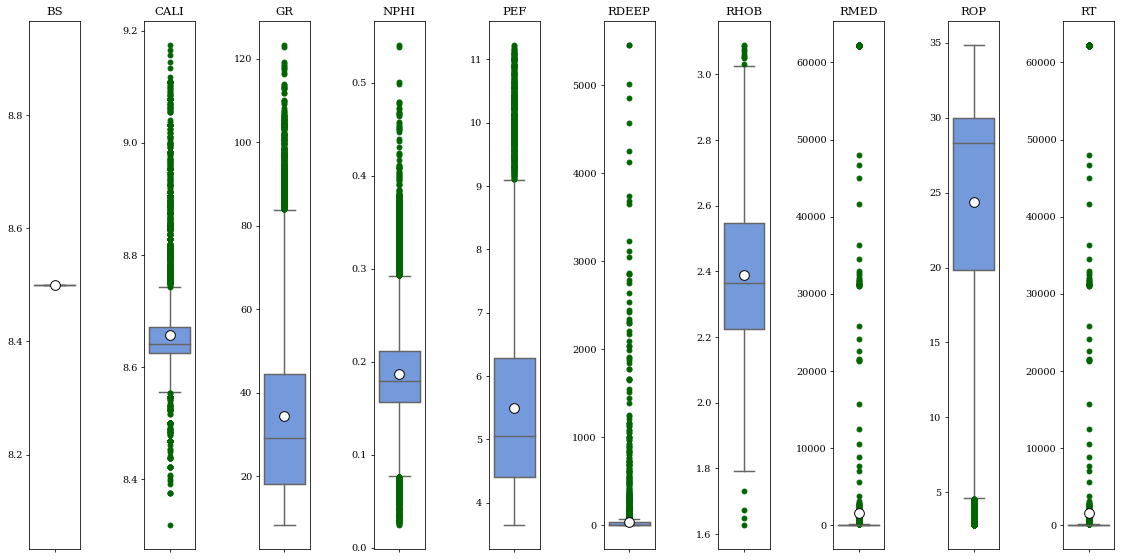

In [29]:
inputs = list(f_11b.columns)
make_boxplot(f_11b, inputs)

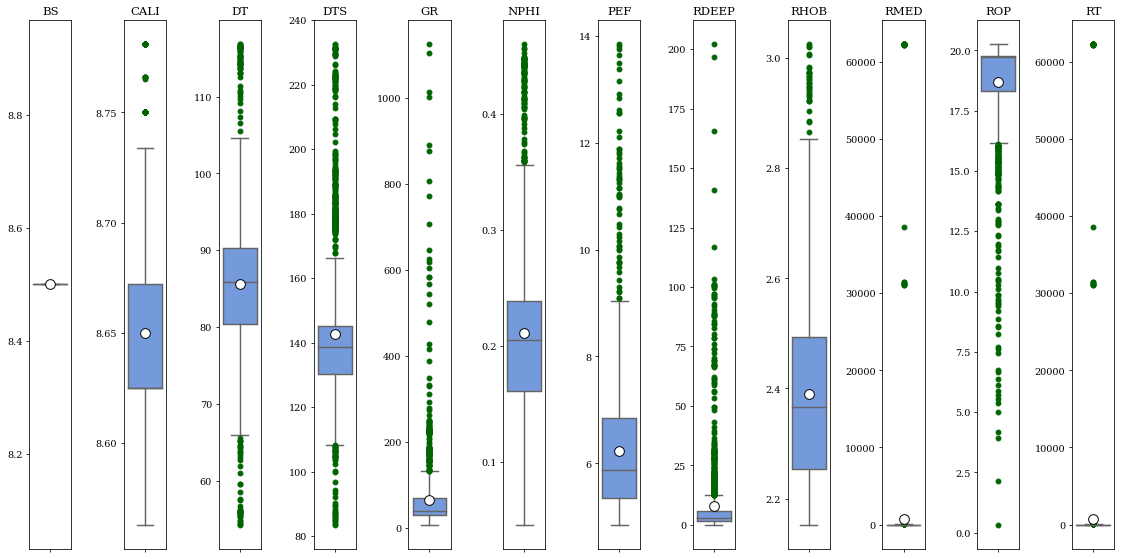

In [30]:
inputs = list(f_11a.columns)
make_boxplot(f_11a, inputs)

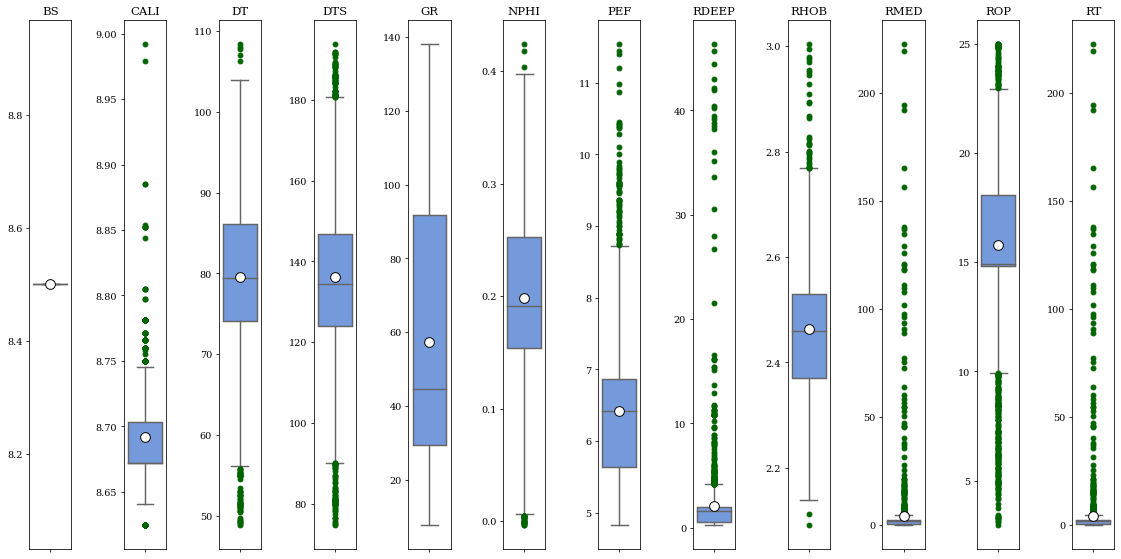

In [31]:
inputs = list(f_11t2.columns)
make_boxplot(f_11t2, inputs)

#### 6.1.3. Label Formation Tops

In [32]:
# Create Formation tops columns 
f_11t2['Depth'] = f_11t2.index
f_11t2['TOPS'] = np.nan

def tops(depth):
    if depth>=4334.7 and depth<4393.0: 
        return 'Heather'
    elif  depth>=4393.0 and depth<4497.4:
        return 'Hugin'
    elif depth>=4497.4:
        return 'Sleipner'
    
f_11t2['TOPS']=f_11t2.apply(lambda x: tops(x.Depth), axis=1)

In [33]:
# Create Formation tops columns 
f_11a['Depth'] = f_11a.index
f_11a['TOPS'] = np.nan

def tops(depth):
    if depth>=3574.9 and depth<3594.6: 
        return 'Heather'
    elif  depth>=3594.6 and depth<3702:
        return 'Hugin'
    elif depth>=3702:
        return 'Sleipner'
    
f_11a['TOPS']=f_11a.apply(lambda x: tops(x.Depth), axis=1)

In [34]:
# Create Formation tops columns 
f_11b['Depth'] = f_11b.index
f_11b['TOPS'] = np.nan


def tops(depth):
    if depth>=3351 and depth<3467.5: 
        return 'Heather'
    elif  depth>=3467.5 and depth<4732:
        return 'Hugin'
    elif depth>=4732:
        return 'Sleipner'
    
f_11b['TOPS']=f_11b.apply(lambda x: tops(x.Depth), axis=1)

#### 6.1.4. DistPlots

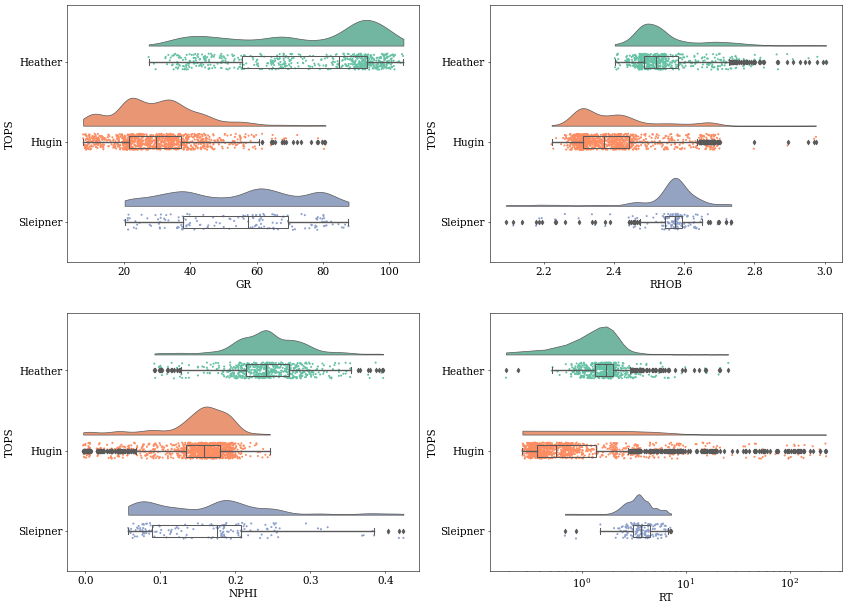

In [35]:
pylab.rcParams.update({'font.size': 15, 'font.family': 'serif'})
fig = plt.figure(figsize=(20,15), dpi=50)

plt.subplot(2, 2, 1)
ptitprince.RainCloud(data = f_11t2, x = 'TOPS', y = 'GR', orient = 'h')

plt.subplot(2, 2, 2)
ptitprince.RainCloud(data = f_11t2, x = 'TOPS', y = 'RHOB', orient = 'h')

plt.subplot(2, 2, 3)
ptitprince.RainCloud(data = f_11t2, x = 'TOPS', y = 'NPHI', orient = 'h')

plt.subplot(2, 2, 4)
g = ptitprince.RainCloud(data = f_11t2, x = 'TOPS', y = 'RT', orient = 'h')
g.set(xscale="log")

plt.show()


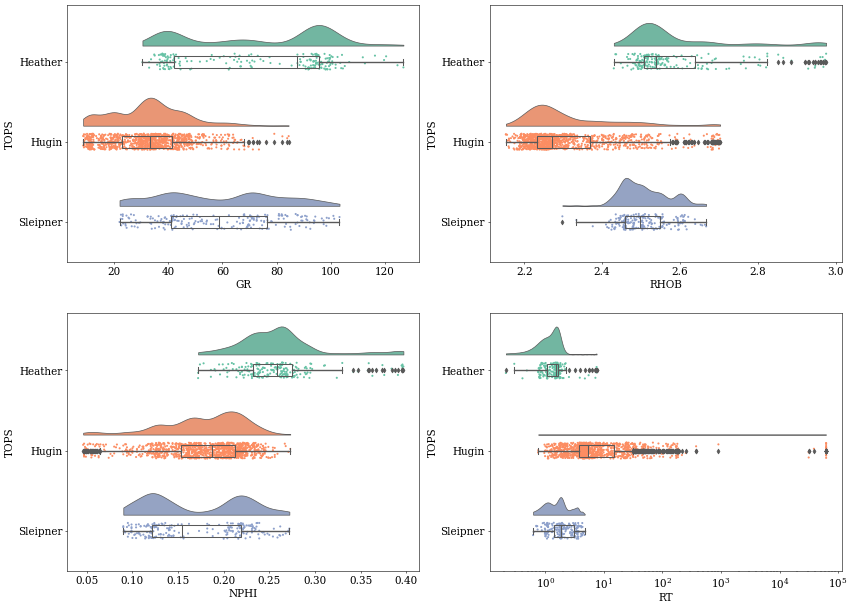

In [36]:
pylab.rcParams.update({'font.size': 15, 'font.family': 'serif'})
fig = plt.figure(figsize=(20,15), dpi=50)

plt.subplot(2, 2, 1)
ptitprince.RainCloud(data = f_11a, x = 'TOPS', y = 'GR', orient = 'h')

plt.subplot(2, 2, 2)
ptitprince.RainCloud(data = f_11a, x = 'TOPS', y = 'RHOB', orient = 'h')

plt.subplot(2, 2, 3)
ptitprince.RainCloud(data = f_11a, x = 'TOPS', y = 'NPHI', orient = 'h')

plt.subplot(2, 2, 4)
g = ptitprince.RainCloud(data = f_11a, x = 'TOPS', y = 'RT', orient = 'h')
g.set(xscale="log")

plt.show()


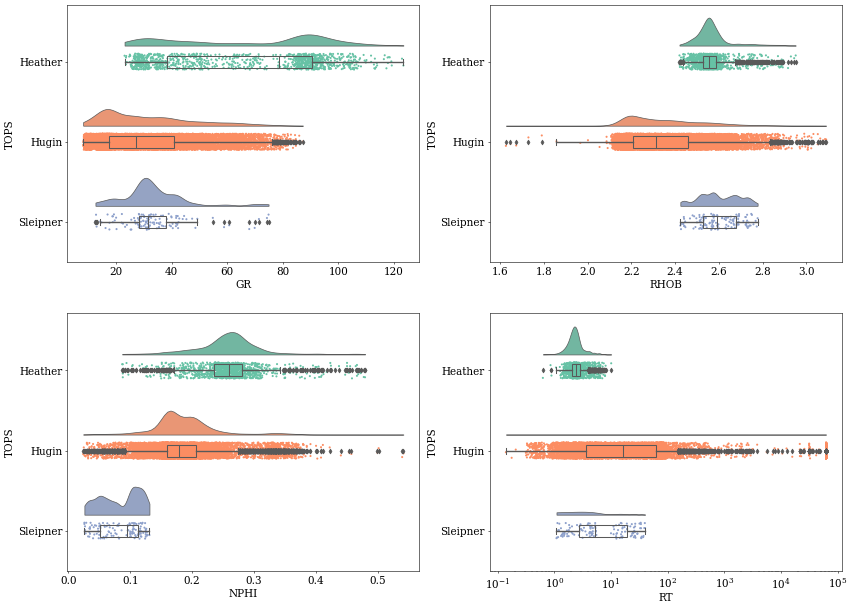

In [37]:
pylab.rcParams.update({'font.size': 15, 'font.family': 'serif'})
fig = plt.figure(figsize=(20,15), dpi=50)

plt.subplot(2, 2, 1)
ptitprince.RainCloud(data = f_11b, x = 'TOPS', y = 'GR', orient = 'h')

plt.subplot(2, 2, 2)
ptitprince.RainCloud(data = f_11b, x = 'TOPS', y = 'RHOB', orient = 'h')

plt.subplot(2, 2, 3)
ptitprince.RainCloud(data = f_11b, x = 'TOPS', y = 'NPHI', orient = 'h')

plt.subplot(2, 2, 4)
g = ptitprince.RainCloud(data = f_11b, x = 'TOPS', y = 'RT', orient = 'h')
g.set(xscale="log")

plt.show()


In [38]:
display(f_11t2.describe(), f_11a.describe(), f_11b.describe())

BS         CALI           DT          DTS           GR  \
count  2129.0  2129.000000  2129.000000  2129.000000  2129.000000   
mean      8.5     8.691814    79.594313   136.162160    57.236203   
std       0.0     0.035095     9.544124    22.138732    33.703508   
min       8.5     8.625000    48.928000    74.823000     7.819000   
25%       8.5     8.672000    74.085000   124.012000    29.535000   
50%       8.5     8.672000    79.473000   134.423000    44.497000   
75%       8.5     8.703000    86.129000   146.683000    91.849000   
max       8.5     8.992000   108.353000   193.837000   138.126000   

              NPHI          PEF        RDEEP         RHOB         RMED  \
count  2129.000000  2129.000000  2129.000000  2129.000000  2129.000000   
mean      0.198092     6.418490     2.072225     2.463689     3.934538   
std       0.075952     0.955145     3.923498     0.122296    15.431933   
min      -0.003000     4.836000     0.308000     2.092000     0.186000   
25%       0.154000     5.637000     0.601000     2.371000     0.575000   
50%       0.191000     6.423000     1.596000     2.460000     1.634000   
75%       0.253000     6.873000     2.022000     2.530000     2.236000   
max       0.424000    11.537000    46.339000     3.004000   222.752000   

               ROP           RT        Depth  
count  2129.000000  2129.000000  2129.000000  
mean     15.792988     3.934538  4406.500000  
std       4.529091    15.431933    61.473368  
min       2.994000     0.186000  4300.100000  
25%      14.826000     0.575000  4353.300000  
50%      14.938000     1.634000  4406.500000  
75%      18.090000     2.236000  4459.700000  
max      24.977000   222.752000  4512.900000

BS         CALI           DT          DTS           GR  \
count  1731.0  1731.000000  1731.000000  1731.000000  1731.000000   
mean      8.5     8.650150    85.577302   142.823392    65.912429   
std       0.0     0.038911     9.749093    24.228476    89.778494   
min       8.5     8.563000    54.280000    83.574000     8.477000   
25%       8.5     8.625000    80.454000   130.420500    30.134500   
50%       8.5     8.625000    85.833000   138.737000    39.935000   
75%       8.5     8.672000    90.233000   145.173500    71.211000   
max       8.5     8.781000   116.841000   232.579000  1124.403000   

              NPHI          PEF        RDEEP         RHOB         RMED  \
count  1731.000000  1731.000000  1731.000000  1731.000000   1731.00000   
mean      0.211024     6.240371     8.053422     2.389980    663.94598   
std       0.079115     1.262728    16.767948     0.160476   5978.08321   
min       0.046000     4.856000     0.084000     2.153000      0.10300   
25%       0.161000     5.358000     1.617000     2.254000      1.68000   
50%       0.205000     5.883000     2.712000     2.366000      3.62400   
75%       0.239000     6.843500     5.930500     2.494000      7.22450   
max       0.460000    13.841000   202.159000     3.025000  62290.77000   

               ROP           RT        Depth  
count  1731.000000   1731.00000  1731.000000  
mean     18.696647    663.94598  3636.600000  
std       2.195574   5978.08321    49.984097  
min       0.341000      0.10300  3550.100000  
25%      18.301000      1.68000  3593.350000  
50%      19.704000      3.62400  3636.600000  
75%      19.760500      7.22450  3679.850000  
max      20.257000  62290.77000  3723.100000

BS          CALI            GR          NPHI           PEF  \
count  14709.0  14709.000000  14709.000000  14709.000000  14709.000000   
mean       8.5      8.656497     34.376643      0.186510      5.494566   
std        0.0      0.072328     19.964978      0.057903      1.387674   
min        8.5      8.318000      8.196000      0.024000      3.647000   
25%        8.5      8.625000     17.968000      0.157000      4.411000   
50%        8.5      8.641000     29.177000      0.179000      5.053000   
75%        8.5      8.672000     44.344000      0.211000      6.284000   
max        8.5      9.175000    123.362000      0.541000     11.229000   

              RDEEP          RHOB          RMED           ROP            RT  \
count  14709.000000  14709.000000  14709.000000  14709.000000  14709.000000   
mean      35.858365      2.390064   1635.795521     24.343470   1635.795521   
std      173.041175      0.181297   9737.873085      7.098336   9737.873085   
min        0.320000      1.627000      0.140000      2.808000      0.140000   
25%        2.465000      2.224000      3.117000     19.816000      3.117000   
50%        6.726000      2.363000      8.101000     28.278000      8.101000   
75%       32.023000      2.547000     51.954000     29.959000     51.954000   
max     5456.299000      3.090000  62290.770000     34.864000  62290.770000   

              Depth  
count  14709.000000  
mean    3997.506309  
std      433.910713  
min     3250.100000  
25%     3620.100000  
50%     3995.200000  
75%     4377.000000  
max     4744.700000

### 6.2. Remove noise

We will apply filter for noise removal, in an attempt to remove outlier noise while preserving the relative magnitude of the curves. 

In [39]:
# https://machinelearning1.wordpress.com/2014/07/13/signal-processing-apply-median-filters-python/

def apply_filter(df):
    x=df.drop(['TOPS','Depth'], axis=1)
    print('Before applying noise-filter \n', x.describe())
    for i in x.keys():
        x[i]=median_filter(x[i].values,size=30,mode='nearest')      
    df=x
    print('After applying noise-filter \n', x.describe())
    return df
                 
f_11t2 = apply_filter(f_11t2)
f_11a = apply_filter(f_11a)
f_11b = apply_filter(f_11b)

Before applying noise-filter 
            BS         CALI           DT          DTS           GR  \
count  2129.0  2129.000000  2129.000000  2129.000000  2129.000000   
mean      8.5     8.691814    79.594313   136.162160    57.236203   
std       0.0     0.035095     9.544124    22.138732    33.703508   
min       8.5     8.625000    48.928000    74.823000     7.819000   
25%       8.5     8.672000    74.085000   124.012000    29.535000   
50%       8.5     8.672000    79.473000   134.423000    44.497000   
75%       8.5     8.703000    86.129000   146.683000    91.849000   
max       8.5     8.992000   108.353000   193.837000   138.126000   

              NPHI          PEF        RDEEP         RHOB         RMED  \
count  2129.000000  2129.000000  2129.000000  2129.000000  2129.000000   
mean      0.198092     6.418490     2.072225     2.463689     3.934538   
std       0.075952     0.955145     3.923498     0.122296    15.431933   
min      -0.003000     4.836000     0.308000     2.

<b> Check for any remaining outliers/noise </b>

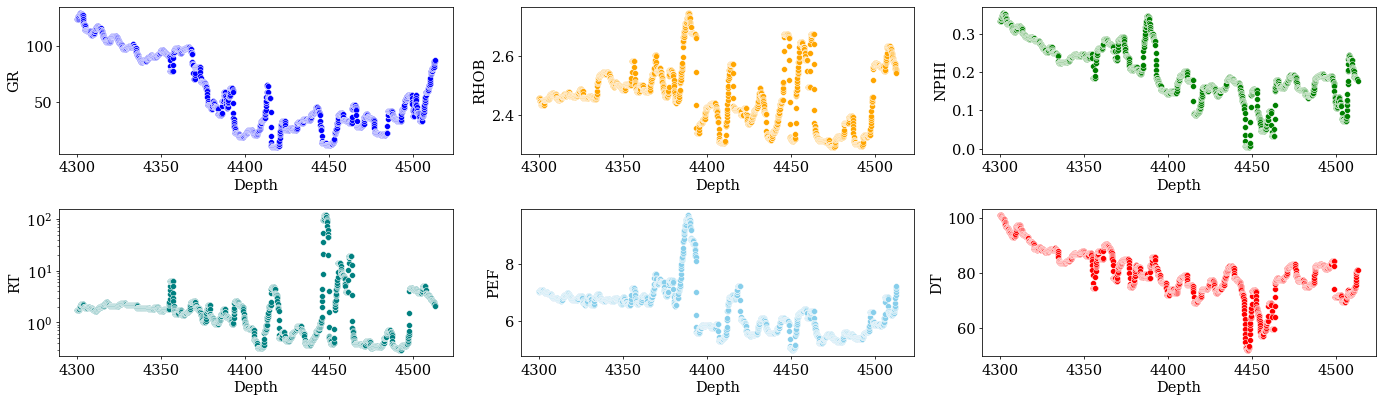

In [40]:
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (20,6))
sns.scatterplot(x='Depth', y='GR', data=f_11t2, ax=ax[0][0], color= 'blue')
sns.scatterplot(x='Depth', y='RHOB', data=f_11t2, ax=ax[0][1], color= 'orange')
sns.scatterplot(x='Depth', y='NPHI', data=f_11t2, ax=ax[0][2], color= 'green')
sns.scatterplot(x='Depth', y='RT', data=f_11t2, ax=ax[1][0], color= 'teal')
ax[1][0].set(yscale="log")
sns.scatterplot(x='Depth', y='PEF', data=f_11t2, ax=ax[1][1], color= 'skyblue')
sns.scatterplot(x='Depth', y='DT', data=f_11t2, ax=ax[1][2], color= 'red')
fig.tight_layout()

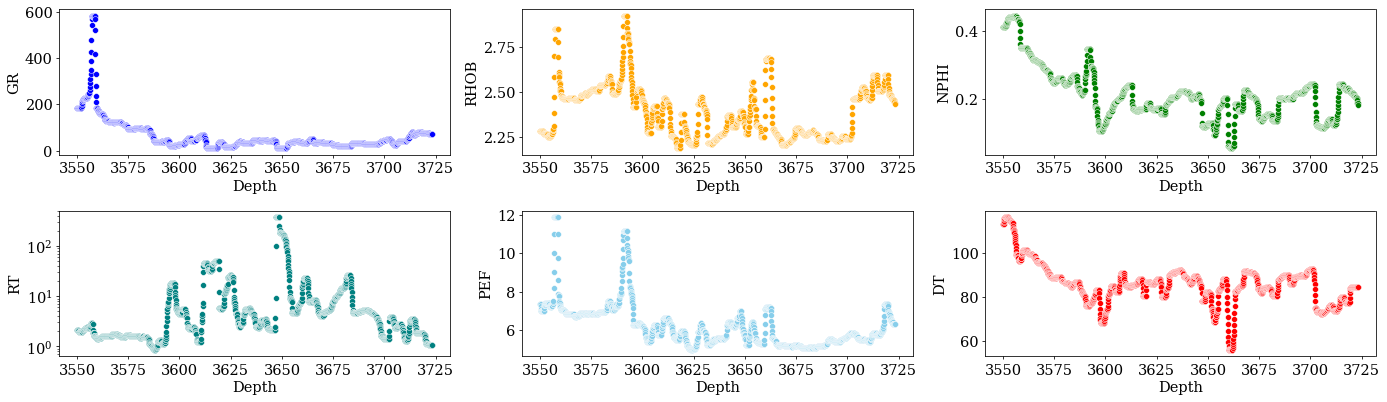

In [41]:
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (20,6))
sns.scatterplot(x='Depth', y='GR', data=f_11a, ax=ax[0][0], color= 'blue')
sns.scatterplot(x='Depth', y='RHOB', data=f_11a, ax=ax[0][1], color= 'orange')
sns.scatterplot(x='Depth', y='NPHI', data=f_11a, ax=ax[0][2], color= 'green')
sns.scatterplot(x='Depth', y='RT', data=f_11a, ax=ax[1][0], color= 'teal')
ax[1][0].set(yscale="log")
sns.scatterplot(x='Depth', y='PEF', data=f_11a, ax=ax[1][1], color= 'skyblue')
sns.scatterplot(x='Depth', y='DT', data=f_11a, ax=ax[1][2], color= 'red')
fig.tight_layout()

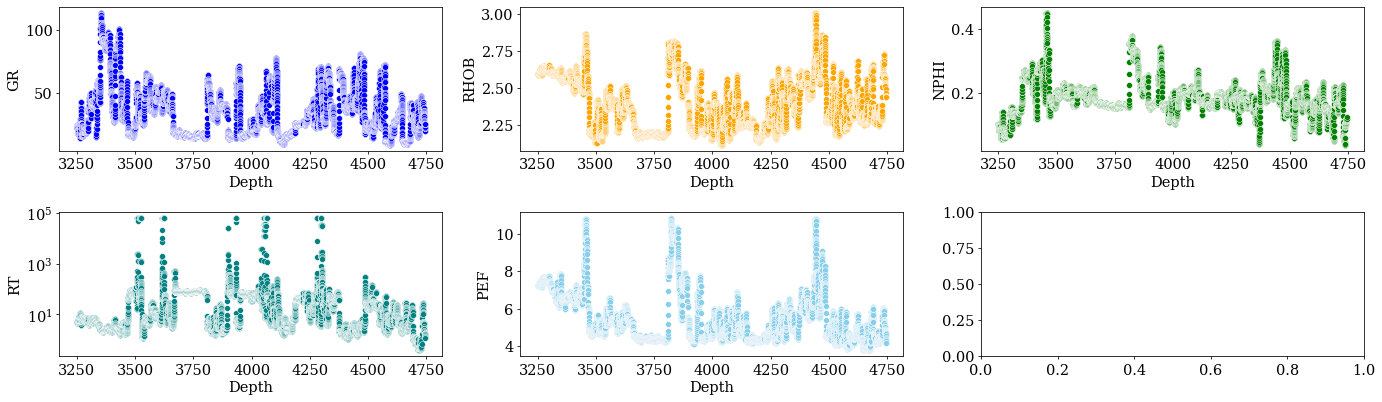

In [42]:
fig, ax= plt.subplots(nrows= 2, ncols = 3, figsize= (20,6))
sns.scatterplot(x='Depth', y='GR', data=f_11b, ax=ax[0][0], color= 'blue')
sns.scatterplot(x='Depth', y='RHOB', data=f_11b, ax=ax[0][1], color= 'orange')
sns.scatterplot(x='Depth', y='NPHI', data=f_11b, ax=ax[0][2], color= 'green')
sns.scatterplot(x='Depth', y='RT', data=f_11b, ax=ax[1][0], color= 'teal')
ax[1][0].set(yscale="log")
sns.scatterplot(x='Depth', y='PEF', data=f_11b, ax=ax[1][1], color= 'skyblue')
fig.tight_layout()

### 6.3. IsolationForest Outlier Removal - F_11B

Since we will be using RT in our Water Saturation estimates, they need to be as clean as we can get them. Resistivity logs in Hugin formation in F_11B still show some outliers after noise removal, due to the affects of polarization horns. We will be removing these outliers using IsolationForest.

In [43]:
# Create DataFrame for each target value - Machine learning
outliers_11b = f_11b[['RT', 'RMED', 'RDEEP']]
outliers_11b = outliers_11b.dropna()
outliers_11b.shape

(14709, 3)

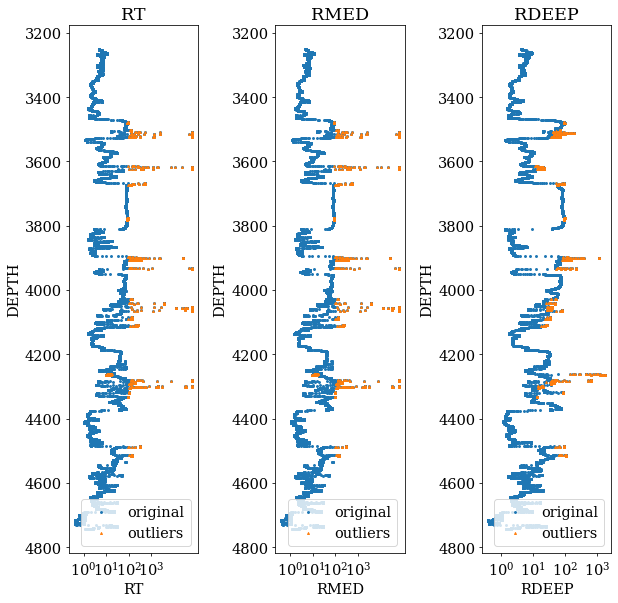

In [44]:
# https://www.vshsolutions.com/blogs/using-isolation-forest-for-outlier-detection-in-python%EF%BB%BF/
# https://towardsdatascience.com/a-brief-overview-of-outlier-detection-techniques-1e0b2c19e561
def log_scatter(log_data, depth, **kwargs):
    size=kwargs.setdefault('size',4)
    marker=kwargs.setdefault('marker','o')
    label=kwargs.setdefault('label','')
    x_label=kwargs.setdefault('x_label','')
    y_label=kwargs.setdefault('y_label','')
    title=kwargs.setdefault('title','')
    plt.scatter(log_data, depth, marker=marker, s=size, label=label)
    # plt.ylim(depth.min(), depth.max())
    # plt.gca().invert_yaxis()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()   

counter = np.zeros(outliers_11b.shape[0])
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.6)

outliers_frac = 0.06
model=IsolationForest(n_estimators=100, max_samples='auto',contamination=outliers_frac, random_state=42)
iso_forest = model.fit(outliers_11b)
# detect anomaly for each features
for i, item in enumerate(outliers_11b[0:]):
        # Automatic anomaly flagging on whole data sample with inliers labeled as 1 and outliers labeled as -1
        isof_outliers = model.predict(outliers_11b)
        outliers_values_11b = outliers_11b[model.predict(outliers_11b) == -1]
        inlier_values_11b = outliers_11b[model.predict(outliers_11b) == 1]
        ax = plt.subplot(131+i)
        ax.set_xscale('log')
        ax.set_xticks([1, 10, 100, 1000])
        ax.invert_yaxis()
        log_scatter(outliers_11b[item], outliers_11b.index, label='original', marker='o')
        log_scatter(outliers_values_11b[item], outliers_values_11b.index, x_label=item, y_label='DEPTH', 
                    title=item, marker='^', label='outliers')
       

In [45]:
f_11b.drop(['RT', 'RDEEP', 'RMED'], axis=1, inplace=True)
f_11b = pd.concat([f_11b, inlier_values_11b], axis=1)
f_11b = f_11b.dropna()

### 6.4. Smooth the Curves

In [46]:
col = ['GR', 'NPHI', 'PEF', 'RHOB', 'RDEEP', 'RMED', 'RT']
# apply 20 rolling window (equivalent to 2 meters) for smoothing
f_11t2[col] = f_11t2[col].rolling(20, min_periods=1).mean()
f_11a[col] = f_11a[col].rolling(20, min_periods=1).mean()
f_11b[col] = f_11b[col].rolling(40, min_periods=1).mean() 
# apply higher window for F_11B as it containes a lot of thin layers

### 6.5. DTC prediction for 15/9-F-11B

In [47]:
f_11t2_train = f_11t2.copy()
f_11t2_train['WELLNAME'] = 'F_11T2'
f_11t2_train['DEPTH'] = f_11t2_train.index

f_11a_train = f_11a.copy()
f_11a_train['WELLNAME'] = 'F_11A'
f_11a_train['DEPTH'] = f_11a_train.index

test = f_11b.copy()
test['WELLNAME'] = 'F_11B'
test['DEPTH'] = test.index
test.reset_index(drop=True)
test.drop('BS', axis=1, inplace=True)

train = f_11t2_train.append([f_11a_train], sort=False)
train.drop('BS', axis=1, inplace=True)
train = train.reset_index(drop = True)



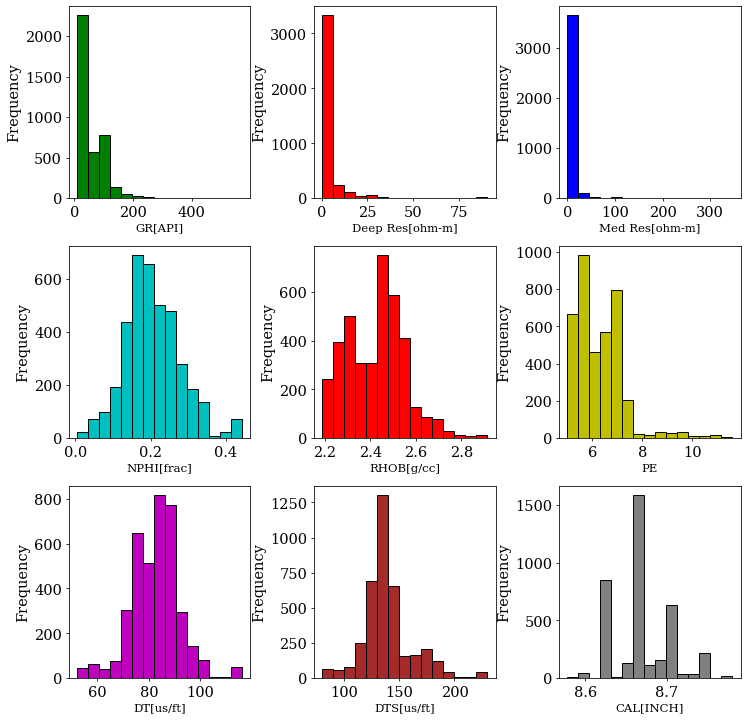

In [48]:
# Plot histogram of each logs
# Histogram plot of W1 well

logs=train.copy()
plt.figure(figsize=(12,12))
plt.subplot(331)
plt.hist(logs.GR.dropna(), bins=15, color='g', edgecolor='k')
plt.xlabel('GR[API]', fontsize=12)
plt.ylabel('Frequency')
#plt.xlim(0,150)
#plt.grid(True)

plt.subplot(332)
plt.hist(logs.RDEEP.dropna(), bins=15, color='r', edgecolor='k')
plt.xlabel('Deep Res[ohm-m]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(333)
plt.hist(logs.RMED.dropna(), bins=15, color='b', edgecolor='k')
plt.xlabel('Med Res[ohm-m]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(334)
plt.hist(logs.NPHI.dropna(), bins=15, color='c', edgecolor='k')
plt.xlabel('NPHI[frac]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(335)
plt.hist(logs.RHOB.dropna(), bins=15, color='r', edgecolor='k')
plt.xlabel('RHOB[g/cc]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(336)
plt.hist(logs.PEF.dropna(), bins=15, color='y', edgecolor='k')
plt.xlabel('PE',fontsize=12)
plt.ylabel('Frequency')
#plt.xlim(0,150)
#plt.grid(True)

plt.subplot(337)
plt.hist(logs.DT.dropna(), bins=15, color='m', edgecolor='k')
plt.xlabel('DT[us/ft]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(338)
plt.hist(logs.DTS.dropna(), bins=15, color='brown', edgecolor='k')
plt.xlabel('DTS[us/ft]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)

plt.subplot(339)
plt.hist(logs.CALI.dropna(), bins=15, color='grey', edgecolor='k')
plt.xlabel('CAL[INCH]',fontsize=12)
plt.ylabel('Frequency')
#plt.grid(True)
plt.subplots_adjust(top=0.9, bottom=.1, left=0.10, right=0.9, hspace=0.25, wspace=0.35)

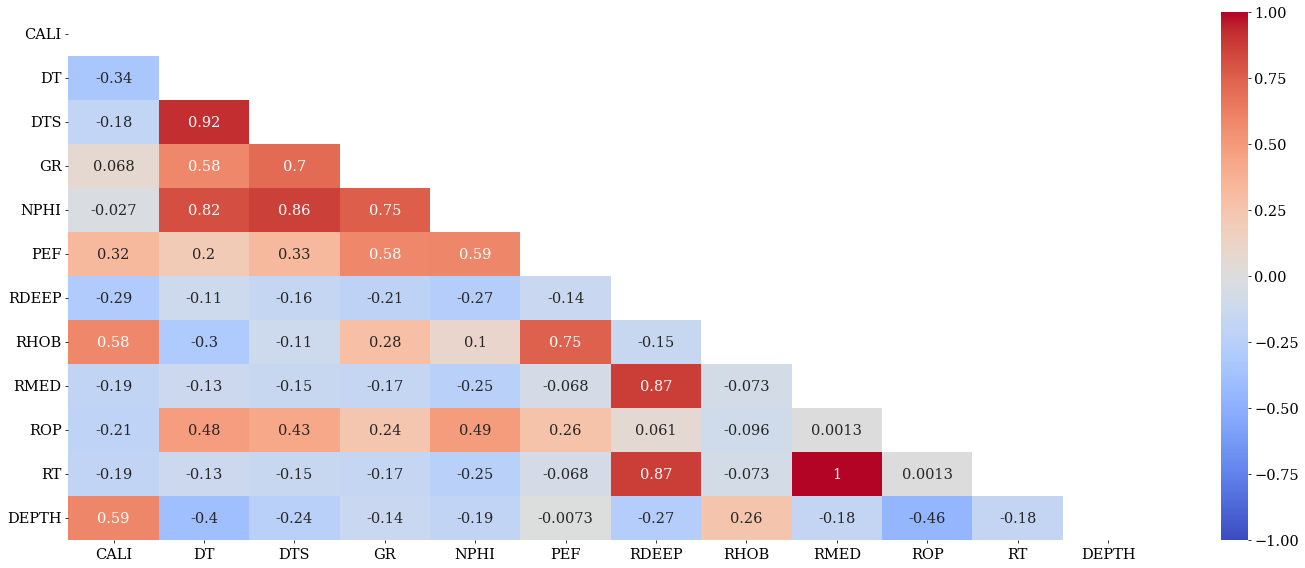

In [49]:
# Generate heat map 
plt.figure(figsize=(25, 10))
mask = np.zeros_like(logs.corr(method='pearson'), dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(logs.corr(method='pearson'), annot = True, \
            mask=mask, cmap = 'coolwarm', 
            vmin=-1.0, vmax=1.0)
plt.show()


(-1.0, 1.0)

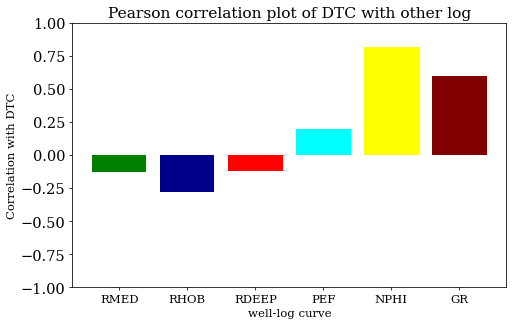

In [50]:
#Bar chart of correlation for DT curve
label = ['RMED', 'RHOB', 'RDEEP', 'PEF', 'NPHI', 'GR']
correlation = [-0.13,-0.28,-0.12,0.2,0.82,0.6]
clr = ['green','darkblue','red','cyan', 'yellow', 'maroon','purple']

index = np.arange(len(label))
plt.figure(figsize=(8,5))
plt.bar(index, correlation, color=clr)
plt.xlabel('well-log curve', fontsize=12)
plt.ylabel('Correlation with DTC', fontsize=12)
plt.xticks(index,label,fontsize=12)
plt.title('Pearson correlation plot of DTC with other log', fontsize=16)
plt.ylim(-1,1)


(-1.0, 1.0)

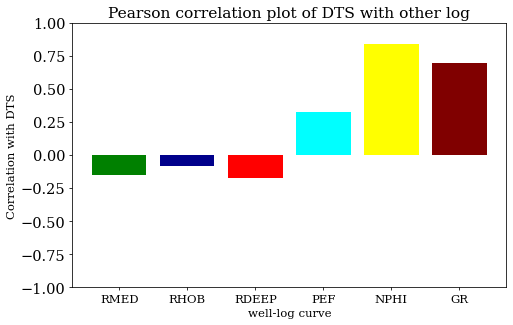

In [51]:
#Bar chart of correlation for DTS curve
label = ['RMED', 'RHOB', 'RDEEP', 'PEF', 'NPHI', 'GR']
correlation = [-0.15,-0.084,-0.17,0.33,0.84,0.7]
clr = ['green','darkblue','red','cyan', 'yellow', 'maroon','purple']

index = np.arange(len(label))
plt.figure(figsize=(8,5))
plt.bar(index, correlation, color=clr)
plt.xlabel('well-log curve', fontsize=12)
plt.ylabel('Correlation with DTS', fontsize=12)
plt.xticks(index,label,fontsize=12)
plt.title('Pearson correlation plot of DTS with other log', fontsize=16)
plt.ylim(-1,1)

In [52]:
train.describe()

CALI           DT          DTS           GR         NPHI  \
count  3860.000000  3860.000000  3860.000000  3860.000000  3860.000000   
mean      8.671763    82.597040   139.432766    60.959877     0.205946   
std       0.035193     9.535525    22.541741    54.747361     0.074720   
min       8.578000    52.015000    80.354000     9.532300     0.004550   
25%       8.648000    76.290750   127.618750    30.924475     0.155163   
50%       8.672000    83.165000   137.132500    42.076600     0.199800   
75%       8.693000    88.374000   144.172250    89.792725     0.247625   
max       8.781000   116.316000   229.639000   571.798700     0.442750   

               PEF        RDEEP         RHOB         RMED          ROP  \
count  3860.000000  3860.000000  3860.000000  3860.000000  3860.000000   
mean      6.306527     4.596561     2.427876     8.134962    17.368617   
std       0.971495    10.156613     0.127433    27.979922     3.623825   
min       5.007250     0.225550     2.189300     0.301600     4.962000   
25%       5.540738     1.215575     2.318187     1.325925    14.893000   
50%       6.174750     1.871800     2.451300     2.016350    18.087000   
75%       6.839812     3.777825     2.505950     4.488150    19.741000   
max      11.596300    90.743350     2.913800   346.539150    24.941000   

                RT        DEPTH  
count  3860.000000  3860.000000  
mean      8.134962  4061.241736  
std      27.979922   387.108480  
min       0.301600  3550.100000  
25%       1.325925  3646.575000  
50%       2.016350  4319.950000  
75%       4.488150  4416.425000  
max     346.539150  4512.900000

In [53]:
# seperate the features and targets
train_set = train.drop(columns = ['CALI','DEPTH','PEF','RT','ROP','WELLNAME'], axis = 1)
features = train_set[train_set.columns[2:]]
targets = train_set[train_set.columns[:2]]
# standize the matrix for training data
scaler = StandardScaler()
feature_vectors = scaler.fit_transform(features)

In [54]:
train_set.describe()

DT          DTS           GR         NPHI        RDEEP  \
count  3860.000000  3860.000000  3860.000000  3860.000000  3860.000000   
mean     82.597040   139.432766    60.959877     0.205946     4.596561   
std       9.535525    22.541741    54.747361     0.074720    10.156613   
min      52.015000    80.354000     9.532300     0.004550     0.225550   
25%      76.290750   127.618750    30.924475     0.155163     1.215575   
50%      83.165000   137.132500    42.076600     0.199800     1.871800   
75%      88.374000   144.172250    89.792725     0.247625     3.777825   
max     116.316000   229.639000   571.798700     0.442750    90.743350   

              RHOB         RMED  
count  3860.000000  3860.000000  
mean      2.427876     8.134962  
std       0.127433    27.979922  
min       2.189300     0.301600  
25%       2.318187     1.325925  
50%       2.451300     2.016350  
75%       2.505950     4.488150  
max       2.913800   346.539150

In [55]:
#Train_Test_Splitting

X_train, X_test, y_train, y_test = train_test_split(feature_vectors, 
                                                    targets, test_size=0.2, 
                                                    random_state=42)
                                                                   

In [56]:
model = RandomForestRegressor(n_estimators=100, random_state=100)
model = GridSearchCV(estimator=model, param_grid={}, scoring='r2', cv=5).fit(X_train, y_train)
model_pred = model.predict(feature_vectors)
print('Training data R^2-score:', '{:.5f}'.format(round(r2_score(targets, model_pred),3)))
print('Training data RMSE:', '{:.5f}'.format(np.sqrt(round(mean_squared_error(targets, model_pred),3))))

Training data R^2-score: 0.99300
Training data RMSE: 1.40926


In [57]:
def model_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    plt.subplots(nrows=2, ncols=2, figsize=(14,7))
    plt.subplot(2, 2, 1)
    plt.plot(y_real['DT'])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison', fontsize=16)

    plt.subplot(2, 2, 2)
    plt.plot(y_real['DTS'])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison', fontsize=16)
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real['DT'], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison', fontsize=16)
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real['DTS'], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison', fontsize=16)
    plt.show()

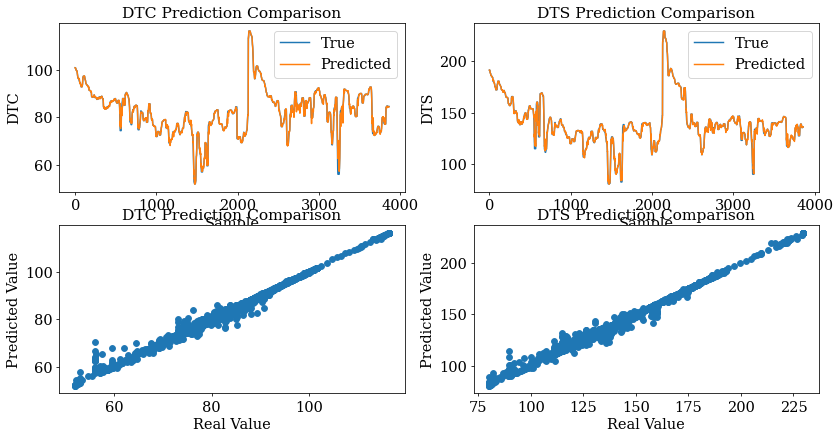

In [58]:
model_plot(model_pred, targets)

In [59]:
# validation data 
pred_val = model.predict(X_test)
score_val = r2_score(y_test, pred_val)
rme_val = np.sqrt(mean_squared_error(y_test, pred_val))
print('Validation data R^2-score: ',round(score_val, 4))
print('Validation data RMSE: ', round(rme_val, 4))

Validation data R^2-score:  0.9805
Validation data RMSE:  2.2846


In [60]:
test_set = test.drop(columns = ['CALI','DEPTH','PEF','RT','ROP','WELLNAME'], axis = 1)
for col in test_set.columns.tolist():
    test_set[col][test_set[col]==-999] = np.nan
test_set.dropna(axis=0, inplace=True)
test_data = np.array(test_set)
x_testwell = scaler.transform(test_data)
print(x_testwell[:5][:])

[[-0.67005293 -1.35116752 -0.19768605 17.14945343 -0.14354874]
 [-0.67005293 -1.35116752 -0.19768605 17.14945343 -0.14290533]
 [-0.67005293 -1.35562922 -0.19768605 17.14945343 -0.14251214]
 [-0.67005293 -1.35786007 -0.19768605 17.25148101 -0.14161853]
 [-0.67005293 -1.35919858 -0.19768605 17.40059824 -0.14099658]]


In [61]:
# run the prediction
pred_test = model.predict(x_testwell)
pred_test[:5, :]

array([[ 68.86499, 110.11411],
       [ 68.86499, 110.11411],
       [ 68.7054 , 109.86892],
       [ 68.64583, 109.76242],
       [ 68.61687, 109.7172 ]])

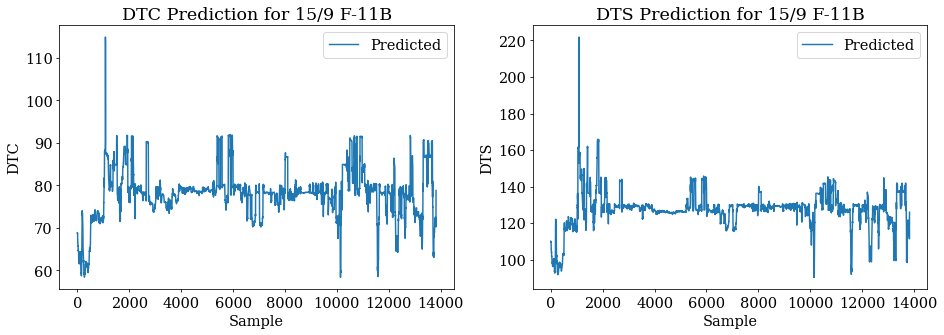

In [62]:
# plot the prediction results 
plt.subplots(nrows=1, ncols=2, figsize=(16,5))
plt.subplot(1, 2, 1)
plt.plot(pred_test[:, 0])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction for 15/9 F-11B')

plt.subplot(1, 2, 2)
plt.plot(pred_test[:, 1])
plt.legend(['Predicted'])
plt.xlabel('Sample')
plt.ylabel('DTS')
plt.title('DTS Prediction for 15/9 F-11B')
plt.show()

In [63]:
f_11b['DT'] = pred_test[:, 0]
f_11b['DTS'] = pred_test[:, 1]

## 7. Load DLIS files for Mudlog Lithology
https://towardsdatascience.com/loading-well-log-data-from-dlis-using-python-9d48df9a23e2

In [64]:
f_T2, *tail_T2 = dlis.load('data/MudLogs/MUD_LOG_F_11T2.DLIS')
f_A, *tail_A = dlis.load('data/MudLogs/MUD_LOG_F_11A.DLIS')
f_B, *tail_B = dlis.load('data/MudLogs/MUD_LOG_F_11B.DLIS')

In [65]:
origin_T2, *origin_tail_T2 = f_T2.origins
origin_A, *origin_tail_A = f_A.origins
origin_B, *origin_tail_B = f_B.origins

#### 7.1. View Headers

In [66]:
display(origin_T2.describe(), origin_A.describe(), origin_B.describe())

------
Origin
------
name   : DEFINING_ORIGIN
origin : 0
copy   : 0

Logical file ID          : 00001_TEMP
File set name and number : BAKERH / 51
File number and type     : 1 / EXCHANGE

Field                   : VOLVE
Well (id/name)          : None / 15/9-F-11 T2
Produced by (code/name) : 15 / INTEQ
Produced for            : Statoil
Created                 : 2013-07-05 08:34:45

Created by              : Advantage, (version: Access-5.44)
Other programs/services : Data Export


------
Origin
------
name   : DEFINING_ORIGIN
origin : 0
copy   : 0

Logical file ID          : 00001_TEMP
File set name and number : BAKERH / 51
File number and type     : 1 / EXCHANGE

Field                   : VOLVE
Well (id/name)          : None / 15/9-F-11 A
Produced by (code/name) : 15 / INTEQ
Produced for            : Statoil
Created                 : 2013-07-05 08:29:42

Created by              : Advantage, (version: Access-5.44)
Other programs/services : Data Export


------
Origin
------
name   : DEFINING_ORIGIN
origin : 0
copy   : 0

Logical file ID          : 00001_TEMP
File set name and number : BAKERH / 51
File number and type     : 1 / EXCHANGE

Field                   : VOLVE
Well (id/name)          : None / 15/9-F-11 B
Produced by (code/name) : 15 / INTEQ
Produced for            : Statoil
Created                 : 2013-07-05 08:32:28

Created by              : Advantage, (version: Access-5.44)
Other programs/services : Data Export


#### 7.2. Review Frames

In [67]:
f_all = [f_T2, f_A, f_B]
for f in f_all:
    for frame in f.frames:
    
        # Search through the channels for the index and obtain the units
        for channel in frame.channels:
            if channel.name == frame.index:
                depth_units = channel.units
    
        print(f'Frame Name: \t\t {frame.name}')
        print(f'Index Type: \t\t {frame.index_type}')
        print(f'Depth Interval: \t {frame.index_min} - {frame.index_max} {depth_units}')
        print(f'Depth Spacing: \t\t {frame.spacing} {depth_units}')
        print(f'Direction: \t\t {frame.direction}')
        print(f'Num of Channels: \t {len(frame.channels)}')
        print(f'Channel Names: \t\t {str(frame.channels)}')
        print('\n\n')

Frame Name: 		 1_000000B0
Index Type: 		 BOREHOLE-DEPTH
Depth Interval: 	 257.0 - 4562.0 m
Depth Spacing: 		 1.0 m
Direction: 		 INCREASING
Num of Channels: 	 50
Channel Names: 		 [Channel(TDEP), Channel(DVER), Channel(BDIA), Channel(ROPA), Channel(HKLA), Channel(HKLX), Channel(WOBA), Channel(TQA), Channel(TQX), Channel(RPMA), Channel(RPMB), Channel(SPPA), Channel(TVA), Channel(MFOA), Channel(MFIA), Channel(MDOA), Channel(MDIA), Channel(MTOA), Channel(MTIA), Channel(MROA), Channel(MRIA), Channel(ECDT), Channel(BDTI), Channel(BDDI), Channel(BRTI), Channel(BRVC), Channel(TCTI), Channel(FPPG), Channel(DXC), Channel(GASA), Channel(GASX), Channel(HSA), Channel(HSX), Channel(MTHA), Channel(ETHA), Channel(PRPA), Channel(IBTA), Channel(NBTA), Channel(IPNA), Channel(NPNA), Channel(EPNA), Channel(C1C2), Channel(C1C3), Channel(C1C4), Channel(C1C5), Channel(LITH), Channel(WLFL), Channel(WLCL), Channel(CCAL), Channel(CDOL)]



Frame Name: 		 1_000000B0
Index Type: 		 BOREHOLE-DEPTH
Depth Interval: 

#### 7.3. Create Channels

In [68]:
def summary_dataframe(object, **kwargs):
    # Create an empty dataframe
    df = pd.DataFrame()
    
    # Iterate over each of the keyword arguments
    for i, (key, value) in enumerate(kwargs.items()):
        list_of_values = []
        
        # Iterate over each parameter and get the relevant key
        for item in object:
            # Account for any missing values.
            try:
                x = getattr(item, key)
                list_of_values.append(x)
            except:
                list_of_values.append('')
                continue
        
        # Add a new column to our data frame
        df[value]=list_of_values
    
    # Sort the dataframe by column 1 and return it
    return df.sort_values(df.columns[0])

In [69]:
channels_T2 = summary_dataframe(f_T2.channels, name='Name', long_name='Long Name',
                                dimension='Dimension', units='Units', frame='Frame')
channels_A = summary_dataframe(f_A.channels, name='Name', long_name='Long Name',
                                dimension='Dimension', units='Units', frame='Frame')
channels_B = summary_dataframe(f_B.channels, name='Name', long_name='Long Name',
                                dimension='Dimension', units='Units', frame='Frame')
display(channels_T2, channels_A, channels_B)

Name                            Long Name Dimension  Units  \
22  BDDI                 Bit drilled distance       [1]      m   
1   BDIA                         Bit diameter       [1]     in   
21  BDTI            Cumulative On-Bottom Time       [1]      h   
23  BRTI                    Bit rotating time       [1]      h   
24  BRVC                Total Bit Revolutions       [1]          
40  C1C2                      Gas Ratio C1/C2       [1]          
41  C1C3                      Gas Ratio C1/C3       [1]          
42  C1C4                      Gas Ratio C1/C4       [1]          
43  C1C5                      Gas Ratio C1/C5       [1]          
47  CCAL                      Calcite content       [1]          
48  CDOL                     Dolomite content       [1]          
0   DVER                  TRUE Vertical depth       [1]      m   
27   DXC          Corrected Drilling Exponent       [1]          
20  ECDT  Effective Circulating density at TD       [1]     sg   
39  EPNA                          Neo-Pentane       [1]    ppm   
33  ETHA                               Ethane       [1]    ppm   
26  FPPG     Formation pore pressure gradient       [1]     sg   
28  GASA                    Average Total Gas       [1]          
29  GASX                    Maximum Total Gas       [1]          
3   HKLA                     Average Hookload       [1]      t   
4   HKLX          Maximum Connection Hookload       [1]      t   
30   HSA             Hydrogen Sulfide average       [1]          
31   HSX             Hydrogen Sulfide maximum       [1]          
35  IBTA           Average Chrom 1 Iso-Butane       [1]    ppm   
37  IPNA          Average Chrom 1 Iso Pentane       [1]    ppm   
44  LITH                       Lithology code       [1]          
15  MDIA                Average Mud Weight In       [1]     sg   
14  MDOA               Average Mud Weight Out       [1]     sg   
13  MFIA                  Average Mud Flow In       [1]  L/min   
12  MFOA                 Average Mud Flow Out       [1]  L/min   
19  MRIA          Mud Resistivity in, average       [1]  ohm.m   
18  MROA         Mud Resistivity out, average       [1]  ohm.m   
32  MTHA              Average Chrom 1 Methane       [1]    ppm   
17  MTIA           Average Mud Temperature In       [1]   degC   
16  MTOA          Average Mud Temperature Out       [1]   degC   
36  NBTA        Average Chrom 1 Normal Butane       [1]    ppm   
38  NPNA       Average Chrom 1 Normal Pentane       [1]    ppm   
34  PRPA              Average Chrom 1 Propane       [1]    ppm   
2   ROPA         Rate of Penetration, average       [1]    m/h   
8   RPMA                   Average string RPM       [1]  c/min   
9   RPMB                      Bit RPM average       [1]  c/min   
10  SPPA   Average Pump Pressure - Stand Pipe       [1]    bar   
25  TCTI               Total circulating time       [1]      h   
49  TDEP             1.000000 m frame 0 depth       [1]      m   
6    TQA                      Torque, average       [1]     kJ   
7    TQX                      Torque, maximum       [1]     kJ   
11   TVA             Average Total Pit Volume       [1]     m3   
46  WLCL                Cut Fluorescence Code       [1]          
45  WLFL            Natural Fluorescence Code       [1]          
5   WOBA              Weight on Bit - average       [1]      t   

                Frame  
22  Frame(1_000000B0)  
1   Frame(1_000000B0)  
21  Frame(1_000000B0)  
23  Frame(1_000000B0)  
24  Frame(1_000000B0)  
40  Frame(1_000000B0)  
41  Frame(1_000000B0)  
42  Frame(1_000000B0)  
43  Frame(1_000000B0)  
47  Frame(1_000000B0)  
48  Frame(1_000000B0)  
0   Frame(1_000000B0)  
27  Frame(1_000000B0)  
20  Frame(1_000000B0)  
39  Frame(1_000000B0)  
33  Frame(1_000000B0)  
26  Frame(1_000000B0)  
28  Frame(1_000000B0)  
29  Frame(1_000000B0)  
3   Frame(1_000000B0)  
4   Frame(1_000000B0)  
30  Frame(1_000000B0)  
31  Frame(1_000000B0)  
35  Frame(1_000000B0)  
37  Frame(1_000000B0)  
44  Frame(1_0

Name                            Long Name Dimension  Units  \
22  BDDI                 Bit drilled distance       [1]      m   
1   BDIA                         Bit diameter       [1]     in   
21  BDTI            Cumulative On-Bottom Time       [1]      h   
23  BRTI                    Bit rotating time       [1]      h   
24  BRVC                Total Bit Revolutions       [1]          
40  C1C2                      Gas Ratio C1/C2       [1]          
41  C1C3                      Gas Ratio C1/C3       [1]          
42  C1C4                      Gas Ratio C1/C4       [1]          
43  C1C5                      Gas Ratio C1/C5       [1]          
47  CCAL                      Calcite content       [1]          
48  CDOL                     Dolomite content       [1]          
0   DVER                  TRUE Vertical depth       [1]      m   
27   DXC          Corrected Drilling Exponent       [1]          
20  ECDT  Effective Circulating density at TD       [1]     sg   
39  EPNA                          Neo-Pentane       [1]    ppm   
33  ETHA                               Ethane       [1]    ppm   
26  FPPG     Formation pore pressure gradient       [1]     sg   
28  GASA                    Average Total Gas       [1]          
29  GASX                    Maximum Total Gas       [1]          
3   HKLA                     Average Hookload       [1]      t   
4   HKLX          Maximum Connection Hookload       [1]      t   
30   HSA             Hydrogen Sulfide average       [1]          
31   HSX             Hydrogen Sulfide maximum       [1]          
35  IBTA           Average Chrom 1 Iso-Butane       [1]    ppm   
37  IPNA          Average Chrom 1 Iso Pentane       [1]    ppm   
44  LITH                       Lithology code       [1]          
15  MDIA                Average Mud Weight In       [1]     sg   
14  MDOA               Average Mud Weight Out       [1]     sg   
13  MFIA                  Average Mud Flow In       [1]  L/min   
12  MFOA                 Average Mud Flow Out       [1]  L/min   
19  MRIA          Mud Resistivity in, average       [1]  ohm.m   
18  MROA         Mud Resistivity out, average       [1]  ohm.m   
32  MTHA              Average Chrom 1 Methane       [1]    ppm   
17  MTIA           Average Mud Temperature In       [1]   degC   
16  MTOA          Average Mud Temperature Out       [1]   degC   
36  NBTA        Average Chrom 1 Normal Butane       [1]    ppm   
38  NPNA       Average Chrom 1 Normal Pentane       [1]    ppm   
34  PRPA              Average Chrom 1 Propane       [1]    ppm   
2   ROPA         Rate of Penetration, average       [1]    m/h   
8   RPMA                   Average string RPM       [1]  c/min   
9   RPMB                      Bit RPM average       [1]  c/min   
10  SPPA   Average Pump Pressure - Stand Pipe       [1]    bar   
25  TCTI               Total circulating time       [1]      h   
49  TDEP             1.000000 m frame 0 depth       [1]      m   
6    TQA                      Torque, average       [1]     kJ   
7    TQX                      Torque, maximum       [1]     kJ   
11   TVA             Average Total Pit Volume       [1]     m3   
46  WLCL                Cut Fluorescence Code       [1]          
45  WLFL            Natural Fluorescence Code       [1]          
5   WOBA              Weight on Bit - average       [1]      t   

                Frame  
22  Frame(1_000000B0)  
1   Frame(1_000000B0)  
21  Frame(1_000000B0)  
23  Frame(1_000000B0)  
24  Frame(1_000000B0)  
40  Frame(1_000000B0)  
41  Frame(1_000000B0)  
42  Frame(1_000000B0)  
43  Frame(1_000000B0)  
47  Frame(1_000000B0)  
48  Frame(1_000000B0)  
0   Frame(1_000000B0)  
27  Frame(1_000000B0)  
20  Frame(1_000000B0)  
39  Frame(1_000000B0)  
33  Frame(1_000000B0)  
26  Frame(1_000000B0)  
28  Frame(1_000000B0)  
29  Frame(1_000000B0)  
3   Frame(1_000000B0)  
4   Frame(1_000000B0)  
30  Frame(1_000000B0)  
31  Frame(1_000000B0)  
35  Frame(1_000000B0)  
37  Frame(1_000000B0)  
44  Frame(1_0

Name                            Long Name Dimension  Units  \
22  BDDI                 Bit drilled distance       [1]      m   
1   BDIA                         Bit diameter       [1]     in   
21  BDTI            Cumulative On-Bottom Time       [1]      h   
23  BRTI                    Bit rotating time       [1]      h   
24  BRVC                Total Bit Revolutions       [1]          
40  C1C2                      Gas Ratio C1/C2       [1]          
41  C1C3                      Gas Ratio C1/C3       [1]          
42  C1C4                      Gas Ratio C1/C4       [1]          
43  C1C5                      Gas Ratio C1/C5       [1]          
47  CCAL                      Calcite content       [1]          
48  CDOL                     Dolomite content       [1]          
0   DVER                  TRUE Vertical depth       [1]      m   
27   DXC          Corrected Drilling Exponent       [1]          
20  ECDT  Effective Circulating density at TD       [1]     sg   
39  EPNA                          Neo-Pentane       [1]    ppm   
33  ETHA                               Ethane       [1]    ppm   
26  FPPG     Formation pore pressure gradient       [1]     sg   
28  GASA                    Average Total Gas       [1]          
29  GASX                    Maximum Total Gas       [1]          
3   HKLA                     Average Hookload       [1]      t   
4   HKLX          Maximum Connection Hookload       [1]      t   
30   HSA             Hydrogen Sulfide average       [1]          
31   HSX             Hydrogen Sulfide maximum       [1]          
35  IBTA           Average Chrom 1 Iso-Butane       [1]    ppm   
37  IPNA          Average Chrom 1 Iso Pentane       [1]    ppm   
44  LITH                       Lithology code       [1]          
15  MDIA                Average Mud Weight In       [1]     sg   
14  MDOA               Average Mud Weight Out       [1]     sg   
13  MFIA                  Average Mud Flow In       [1]  L/min   
12  MFOA                 Average Mud Flow Out       [1]  L/min   
19  MRIA          Mud Resistivity in, average       [1]  ohm.m   
18  MROA         Mud Resistivity out, average       [1]  ohm.m   
32  MTHA              Average Chrom 1 Methane       [1]    ppm   
17  MTIA           Average Mud Temperature In       [1]   degC   
16  MTOA          Average Mud Temperature Out       [1]   degC   
36  NBTA        Average Chrom 1 Normal Butane       [1]    ppm   
38  NPNA       Average Chrom 1 Normal Pentane       [1]    ppm   
34  PRPA              Average Chrom 1 Propane       [1]    ppm   
2   ROPA         Rate of Penetration, average       [1]    m/h   
8   RPMA                   Average string RPM       [1]  c/min   
9   RPMB                      Bit RPM average       [1]  c/min   
10  SPPA   Average Pump Pressure - Stand Pipe       [1]    bar   
25  TCTI               Total circulating time       [1]      h   
49  TDEP             1.000000 m frame 0 depth       [1]      m   
6    TQA                      Torque, average       [1]     kJ   
7    TQX                      Torque, maximum       [1]     kJ   
11   TVA             Average Total Pit Volume       [1]     m3   
46  WLCL                Cut Fluorescence Code       [1]          
45  WLFL            Natural Fluorescence Code       [1]          
5   WOBA              Weight on Bit - average       [1]      t   

                Frame  
22  Frame(1_000000B0)  
1   Frame(1_000000B0)  
21  Frame(1_000000B0)  
23  Frame(1_000000B0)  
24  Frame(1_000000B0)  
40  Frame(1_000000B0)  
41  Frame(1_000000B0)  
42  Frame(1_000000B0)  
43  Frame(1_000000B0)  
47  Frame(1_000000B0)  
48  Frame(1_000000B0)  
0   Frame(1_000000B0)  
27  Frame(1_000000B0)  
20  Frame(1_000000B0)  
39  Frame(1_000000B0)  
33  Frame(1_000000B0)  
26  Frame(1_000000B0)  
28  Frame(1_000000B0)  
29  Frame(1_000000B0)  
3   Frame(1_000000B0)  
4   Frame(1_000000B0)  
30  Frame(1_000000B0)  
31  Frame(1_000000B0)  
35  Frame(1_000000B0)  
37  Frame(1_000000B0)  
44  Frame(1_0

In [70]:
frame_T2 = f_T2.object('FRAME','1_000000B0')
frame_A = f_A.object('FRAME','1_000000B0')
frame_B = f_B.object('FRAME','1_000000B0')

#### 7.4. Pull Lithology and Depth Curves

In [71]:
curves_T2 = frame_T2.curves()
tdepth_T2 = curves_T2['TDEP']
lith_T2 = curves_T2['LITH']

curves_A = frame_A.curves()
tdepth_A = curves_A['TDEP']
lith_A = curves_A['LITH']

curves_B = frame_B.curves()
tdepth_B = curves_B['TDEP']
lith_B = curves_B['LITH']

#### 7.5. Create Mudlog DataFrames

In [72]:
f_11t2_mudlog = pd.DataFrame({'TDepth': tdepth_T2, 'Lithology': lith_T2}, columns=['TDepth', 'Lithology'])
f_11t2_mudlog = f_11t2_mudlog.replace(-999.25, np.nan)
f_11t2_mudlog = f_11t2_mudlog.dropna()
# round depth to first decimal place
f_11t2_mudlog['TDepth'] = f_11t2_mudlog['TDepth'].apply(lambda x:round(x,1))
# drop duplicate deapth columns and set index to Depth
f_11t2_mudlog = f_11t2_mudlog.drop_duplicates(subset=['TDepth'], keep=False)
f_11t2_mudlog = f_11t2_mudlog.sort_values(by=['TDepth'])
f_11t2_mudlog.drop(f_11t2_mudlog[f_11t2_mudlog.TDepth < 4300].index, inplace=True)
f_11t2_mudlog.set_index('TDepth', inplace=True)


f_11a_mudlog = pd.DataFrame({'TDepth': tdepth_A, 'Lithology': lith_A}, columns=['TDepth', 'Lithology'])
f_11a_mudlog = f_11a_mudlog.replace(-999.25, np.nan)
f_11a_mudlog = f_11a_mudlog.dropna()
# round depth to first decimal place
f_11a_mudlog['TDepth'] = f_11a_mudlog['TDepth'].apply(lambda x:round(x,1))
# drop duplicate deapth columns and set index to Depth
f_11a_mudlog = f_11a_mudlog.drop_duplicates(subset=['TDepth'], keep=False)
f_11a_mudlog = f_11a_mudlog.sort_values(by=['TDepth'])
f_11a_mudlog.drop(f_11a_mudlog[f_11a_mudlog.TDepth < 3550].index, inplace=True)
f_11a_mudlog.set_index('TDepth', inplace=True)

f_11b_mudlog = pd.DataFrame({'TDepth': tdepth_B, 'Lithology': lith_B}, columns=['TDepth', 'Lithology'])
f_11b_mudlog = f_11b_mudlog.replace(-999.25, np.nan)
f_11b_mudlog = f_11b_mudlog.dropna()
# round depth to first decimal place
f_11b_mudlog['TDepth'] = f_11b_mudlog['TDepth'].apply(lambda x:round(x,1))
# drop duplicate deapth columns and set index to Depth
f_11b_mudlog = f_11b_mudlog.drop_duplicates(subset=['TDepth'], keep=False)
f_11b_mudlog = f_11b_mudlog.sort_values(by=['TDepth'])
f_11b_mudlog.drop(f_11b_mudlog[f_11b_mudlog.TDepth < 3250].index, inplace=True)
f_11b_mudlog.set_index('TDepth', inplace=True)

In [73]:
display(f_11t2_mudlog.Lithology.unique(), f_11a_mudlog.Lithology.unique(), f_11b_mudlog.Lithology.unique())

array([ 90., 180., 220., 690.], dtype=float32)

array([600., 400., 300.], dtype=float32)

array([530., 500.,  90., 220., 180., 690.], dtype=float32)

In [74]:
# Create a uniform code for lithology for all wells
f_11t2_mudlog = f_11t2_mudlog.replace({'Lithology': {90: 'A', 180: 'B', 220: 'C', 690: 'D'}})
f_11a_mudlog = f_11a_mudlog.replace({'Lithology': {600: 'A', 400: 'B', 300: 'C'}})
f_11b_mudlog = f_11b_mudlog.replace({'Lithology': {90: 'A', 500: 'B', 530: 'D', 220: 'C', 180: 'A', 690: 'B'}})

#### 7.6. Merge mudlog lithology with las Dataframes

In [75]:
f_11t2_final = pd.concat([f_11t2, f_11t2_mudlog], axis=1)
f_11t2_final.loc[:,'Lithology'] = f_11t2_final.loc[:,'Lithology'].ffill()

f_11a_final = pd.concat([f_11a, f_11a_mudlog], axis=1)
f_11a_final.loc[:,'Lithology'] = f_11a_final.loc[:,'Lithology'].ffill()

f_11b_final = pd.concat([f_11b, f_11b_mudlog], axis=1)
f_11b_final.loc[:,'Lithology'] = f_11b_final.loc[:,'Lithology'].ffill()

In [76]:
#### Create Lithology Columns for plotting purposes
f_11t2_final = pd.get_dummies(f_11t2_final, columns=['Lithology'])
f_11a_final = pd.get_dummies(f_11a_final, columns=['Lithology'])
f_11b_final = pd.get_dummies(f_11b_final, columns=['Lithology'])

In [77]:
#### add empty dummy columns for Lithology Lithology D, in F_11A for consistency during plotting
f_11a_final['Lithology_D'] = 0


In [78]:
display(f_11t2_final.head(), f_11a_final.head(), f_11b_final.head())

BS   CALI       DT      DTS       GR   NPHI       PEF  RDEEP   RHOB  \
4300.0  NaN    NaN      NaN      NaN      NaN    NaN       NaN    NaN    NaN   
4300.1  8.5  8.672  100.875  191.449  123.768  0.334  7.007000  1.731  2.456   
4300.2  8.5  8.672  100.875  191.449  123.768  0.334  7.025500  1.731  2.456   
4300.3  8.5  8.672  100.847  191.449  123.768  0.334  7.031667  1.731  2.456   
4300.4  8.5  8.672  100.832  191.449  123.768  0.334  7.036750  1.731  2.456   

         RMED     ROP     RT  Lithology_A  Lithology_B  Lithology_C  \
4300.0    NaN     NaN    NaN            1            0            0   
4300.1  1.709  14.851  1.709            1            0            0   
4300.2  1.709  14.851  1.709            1            0            0   
4300.3  1.709  14.851  1.709            1            0            0   
4300.4  1.709  14.851  1.709            1            0            0   

        Lithology_D  
4300.0            0  
4300.1            0  
4300.2            0  
4300.3            0  
4300.4            0

BS   CALI       DT      DTS       GR   NPHI       PEF  RDEEP   RHOB  \
3550.0  NaN    NaN      NaN      NaN      NaN    NaN       NaN    NaN    NaN   
3550.1  8.5  8.672  113.110  214.143  185.802  0.412  7.386000  1.879  2.282   
3550.2  8.5  8.672  113.124  216.260  185.802  0.412  7.386000  1.879  2.282   
3550.3  8.5  8.672  113.138  221.052  185.802  0.412  7.380667  1.879  2.282   
3550.4  8.5  8.672  113.922  221.145  185.802  0.412  7.352000  1.879  2.282   

         RMED     ROP     RT  Lithology_A  Lithology_B  Lithology_C  \
3550.0    NaN     NaN    NaN            1            0            0   
3550.1  2.083  19.724  2.083            1            0            0   
3550.2  2.083  19.724  2.083            1            0            0   
3550.3  2.083  19.724  2.083            1            0            0   
3550.4  2.083  19.724  2.083            1            0            0   

        Lithology_D  
3550.0            0  
3550.1            0  
3550.2            0  
3550.3            0  
3550.4            0

BS   CALI      GR      NPHI   PEF   RHOB     ROP     RT   RMED  \
3250.0  NaN    NaN     NaN       NaN   NaN    NaN     NaN    NaN    NaN   
3250.1  8.5  8.578  24.281  0.105000  7.24  2.589  16.784  4.613  4.613   
3250.2  8.5  8.578  24.281  0.105000  7.24  2.589  16.784  4.613  4.613   
3250.3  8.5  8.578  24.281  0.104667  7.24  2.589  16.728  4.613  4.613   
3250.4  8.5  8.578  24.281  0.104500  7.24  2.589  16.506  4.626  4.626   

        RDEEP        DT        DTS  Lithology_A  Lithology_B  Lithology_C  \
3250.0    NaN       NaN        NaN            0            0            0   
3250.1  4.119  68.86499  110.11411            0            0            0   
3250.2  4.137  68.86499  110.11411            0            0            0   
3250.3  4.148  68.70540  109.86892            0            0            0   
3250.4  4.173  68.64583  109.76242            0            0            0   

        Lithology_D  
3250.0            1  
3250.1            1  
3250.2            1  
3250.3            1  
3250.4            1

## 8. Visualizing Clean Data

In [79]:
# https://andymcdonaldgeo.medium.com/loading-and-displaying-well-log-data-b9568efd1d8

def plotalllogs1(dataframe):
#=============================================================================    
    tracks=6
    linewidth=0.5
    ## Gamma Ray
    trackGR=0 #Gamma Ray
    ## Resistivity
    trackRes=1
    ## Porosity
    trackPOR=2
    ## PEF
    trackPE=3 
    ## DT, DTS
    trackDT=4
    ## Muglog Lithology
    trackLITH=5
#=============================================================================    
    pylab.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (10,20)})
    fig,axes = plt.subplots(1,tracks,sharey=True,figsize=(15,15), dpi=90) ##sharey: share y axis
    fig.gca().invert_yaxis()
    
    for ax in axes:
        for (i,j) in zip(tops_depths,tops):
                ax.axhline(y=i, linewidth=1, color='red')
                ax.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')

# =================================trackGR============================================

    ## GR
    ax1 = axes[trackGR]
    ax1.grid(which='both')
    # ax1.grid(which='major', linestyle='-', linewidth='0.5', color='lime')
    # ax1.grid(which='minor', linestyle=':', linewidth='1', color='black')
    ax1.plot(dataframe['GR'],dataframe.index, label='GR', color='green', lw=2)
    ax1.set_xlabel('GR, GAPI')
    ax1.set_xlim(0,250)
    ax1.set_xticks([0, 50, 100, 150, 200, 250])

    # https://towardsdatascience.com/enhancing-visualization-of-well-logs-with-plot-fills-72d9dcd10c1b
    left_value = 0
    right_value = 250
    span = abs(left_value-right_value)
    cmap = plt.get_cmap('hot_r')
    color_index = np.arange(left_value, right_value, span/100)
    
    for index in sorted(color_index):
        index_value =(index-left_value)/span
        color = cmap(index_value)
        ax1.fill_betweenx(dataframe.index, 0, dataframe['GR'], where=dataframe['GR']>=index, color=color)
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    
    ## CALI
    ax2 = axes[trackGR].twiny()
    # ax2.grid(which='both')
    ax2.plot(dataframe['CALI'],dataframe.index, label='CALI', color='magenta', lw=linewidth)
    ax2.set_xlabel('CALI, IN')
    ax2.set_xlim(5,10)
    ax2.set_xticks([5, 6, 7, 8, 9, 10])
    ax2.spines['top'].set_position(('outward', 20))
    ax2.xaxis.set_ticks_position('top')
    ax2.xaxis.set_label_position('top')    
    
    ## ROP
    ax3 = axes[trackGR].twiny()
    # ax3.grid(which='both')
    ax3.plot(dataframe['ROP'],dataframe.index, label='ROP', ls = '--', color='slateblue', lw=linewidth)
    ax3.set_xlabel('ROP, m/hr')
    ax3.set_xlim(0,100)
    ax3.spines['top'].set_position(('outward', 60))
    ax3.xaxis.set_ticks_position('top')
    ax3.xaxis.set_label_position('top')
    
#====================================trackRes===========================================

    # Resistivity   
    ax1 = axes[trackRes]
    ax1.set_xscale('log')
    ax1.grid(which='both')
    ax1.plot(dataframe['RDEEP'],dataframe.index, label='RDEEP', color='cyan', lw=linewidth)
    ax1.plot(dataframe['RMED'],dataframe.index, label='RMED',color='darkblue', ls = '--', lw=linewidth)
    ax1.plot(dataframe['RT'],dataframe.index, label='RT',color='red', ls = '--', lw=1)
    ax1.set_xlabel('Resistivity, ohm.m')
    ax1.legend(loc=1)
    ax1.set_xlim(0.2,2000)
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.set_xticks([1, 10, 100, 1000])
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    
# ==================================trackPOR===========================================

    ## RHOB
    ax1 = axes[trackPOR].twiny()
    ax1.plot(dataframe['RHOB'],dataframe.index, label=r'$\rho_b$', color='red', lw=1)
    ax1.set_xlabel(r'$\rho_b, g/cc$')
    ax1.set_xlim(1.95,2.95)
    ax1.set_xticks([1.95, 2.2, 2.45, 2.7, 2.95])
    ax1.spines['top'].set_position(('outward', 40))
    ax1.spines['top'].set_edgecolor('red')
    ax1.xaxis.set_ticks_position('top') # set the position of the second x-axis to top
    #ax1.tick_params(axis='x', colors='red')
    ax1.xaxis.set_label_position('top') # set the position of the second x-axis to top
    ax1.legend(bbox_to_anchor=(0.6, .9))
    
    ##NPHI
    ax2 = axes[trackPOR]
    ax2.grid(which='both')
    ax2.plot(dataframe['NPHI'],dataframe.index, label=r'$\phi_N$', color='blue', lw=2)
    ax2.set_xlim(0.45, -0.15)
    ax2.set_xlabel(r'$\phi_N$, %') 
    ax2.legend(bbox_to_anchor=(0.6, 1))
    ax2.xaxis.set_label_position('top') # set the position of the second x-axis to top
    ax2.xaxis.set_ticks_position('top')
    ax2.set_xticks([0.6, 0.45, 0.3, 0.15, 0])
    
    # https://towardsdatascience.com/enhancing-visualization-of-well-logs-with-plot-fills-72d9dcd10c1b
    x1=dataframe['RHOB']
    x2=dataframe['NPHI']
    x = np.array(ax1.get_xlim())
    z = np.array(ax2.get_xlim())
    nz=((x2-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)
    ax1.fill_betweenx(dataframe.index, x1, nz, where=x1>=nz, interpolate=True, color='green')
    ax1.fill_betweenx(dataframe.index, x1, nz, where=x1<=nz, interpolate=True, color='yellow')
    
# ====================================trackPE=========================================   
    ##PE
    ax1 = axes[trackPE]
    ax1.grid(which='both')
    ax1.plot(dataframe['PEF'],dataframe.index, label='PE', lw=linewidth)
    ax1.set_xlabel('PE, barns/electron')
    ax1.set_xlim(-5,10)
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')  

# ====================================trackDT=========================================    
    
    ## DTC & DTS
    ax1 = axes[trackDT]
    ax1.grid(which='both')
    ax1.plot(dataframe['DT'],dataframe.index, label='DTC', lw=linewidth, color='blue')
    ax1.plot(dataframe['DTS'],dataframe.index, label='DTS', lw=linewidth, color='red')
    ax1.set_xlabel('DT')
    ax1.set_xlim(500,40)
    ax1.set_xlim(240,40)
    ax1.set_xticks([240, 140, 40])
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')


# # ====================================trackLITH=========================================   
    
    ax1 = axes[trackLITH].twiny()
    ax1.grid(which='both')
    ax1.plot(dataframe['Lithology_A'],dataframe.index, label='Lithology_A',color='black', lw=linewidth)
    ax1.plot(dataframe['Lithology_B'],dataframe.index, label='Lithology_B',color='black', lw=linewidth)
    ax1.plot(dataframe['Lithology_C'],dataframe.index, label='Lithology_C',color='black', lw=linewidth)
    ax1.plot(dataframe['Lithology_D'],dataframe.index, label='Lithology_D',color='black', lw=linewidth)
    # ax1.plot(dataframe['Lithology_E'],dataframe.index, label='Lithology_E',color='black', lw=linewidth)
    # ax1.plot(dataframe['Lithology_F'],dataframe.index, label='Lithology_F',color='black', lw=linewidth)
    ax1.set_xlabel('Cuttings')
    ax1.spines['top'].set_position(('outward', 0))
    ax1.set_xlim(0, 1)
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')

    ax2 = axes[trackLITH].twiny()
    ax2.set_xlim(0, 1)
    ax2.spines['top'].set_position(('outward',0))
    ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_A,facecolor='lightgray',label='Lithology_A', hatch='--')
    ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_B,facecolor='cyan',label='Lithology_B', hatch='-.-')
    ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_C,facecolor='yellow',label= 'Lithology_C', hatch='..')
    ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_D,color='blue',label= 'Lithology_D', hatch='\\')
    # ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_E,color='blue',label= 'Lithology_E')
    # ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_F,color='white',label= 'Lithology_F')
    ax2.legend(loc='lower left')
    

#### 8.1. F_11T2 Plot

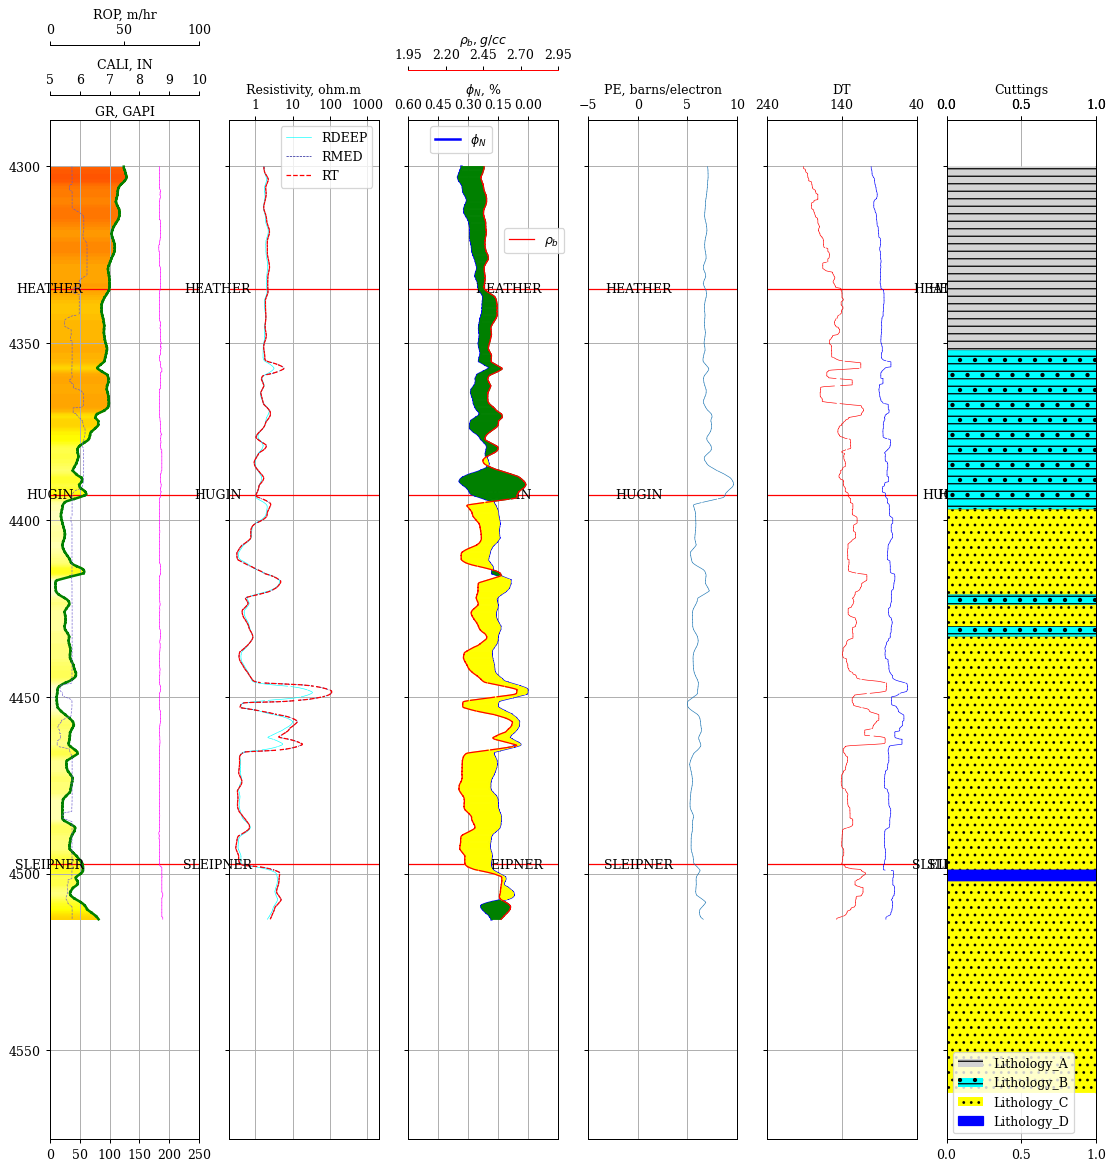

In [80]:
tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
tops_depths=[4334.7, 4393.0, 4497.4]
plotalllogs1(f_11t2_final)

#### 8.2. F_11A Plot

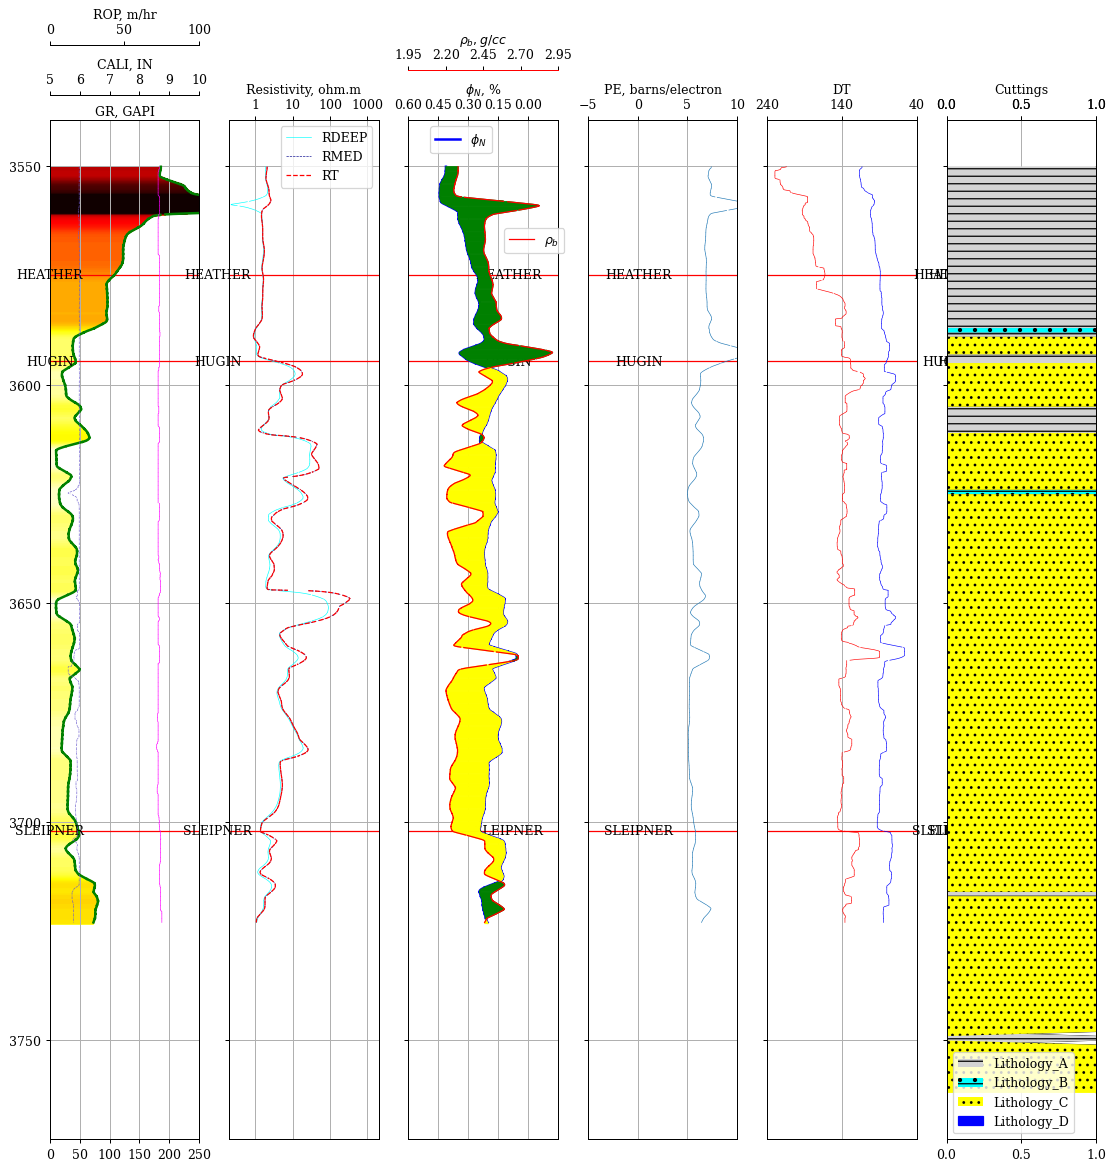

In [81]:
tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
tops_depths=[3574.9, 3594.6, 3702]
plotalllogs1(f_11a_final)

#### 8.3. F_11B Plot

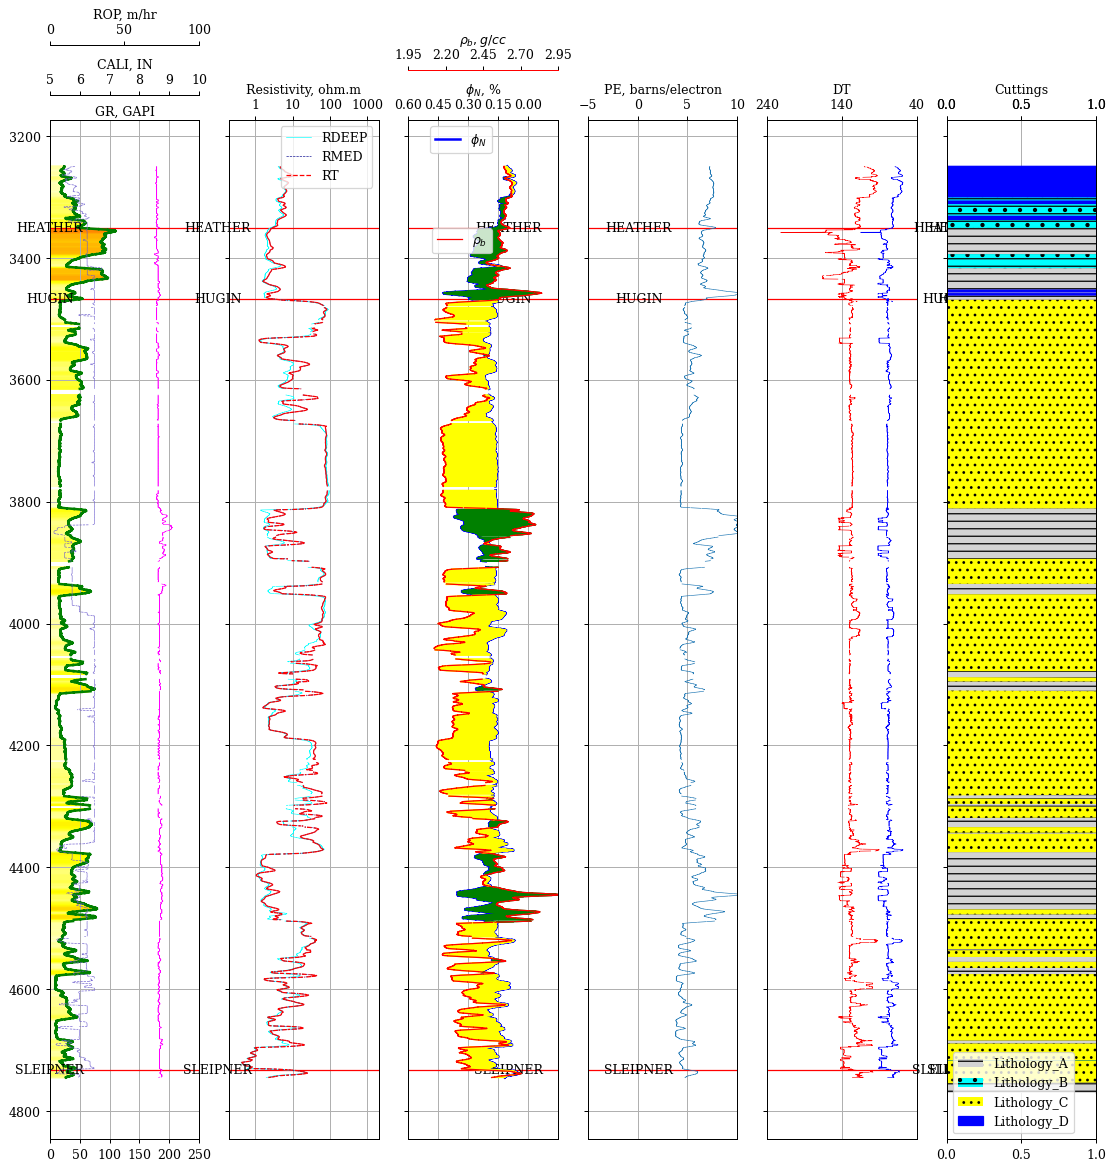

In [82]:
tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
tops_depths=[3351, 3467.5, 4732]
plotalllogs1(f_11b_final)

In [83]:
f_11t2_final = f_11t2_final.dropna()
f_11a_final = f_11a_final.dropna()
f_11b_final = f_11b_final.dropna()

## 9. Formation Evaluation

### 9.1. Evaulation Parameters 
Below are the parameters we will be using to evaluate the Porosity, Permeability and Saturation of the formations


<i>As described in petrophysical report: “Sleipner Øst and Volve Model 2006, Hugin and Skagerrak Formation, Petrophysical Evaluation”. November 2006. Author: Elin Solfjell, Karl Audun Lehne.</i>

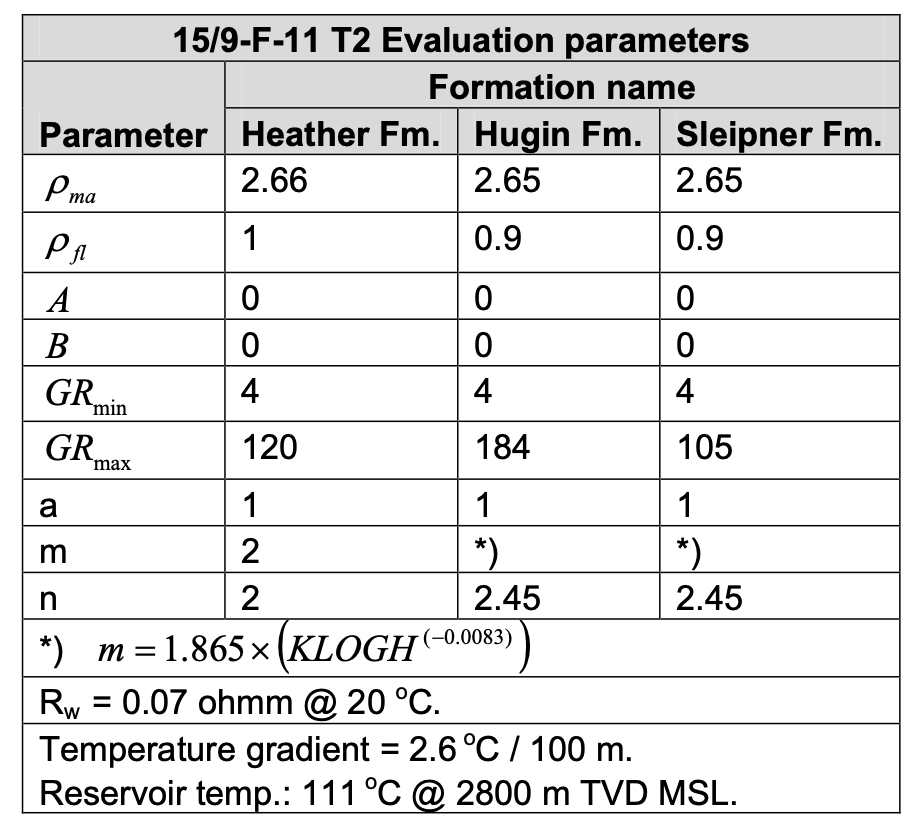

In [84]:
Image("img/F-11T2.png")

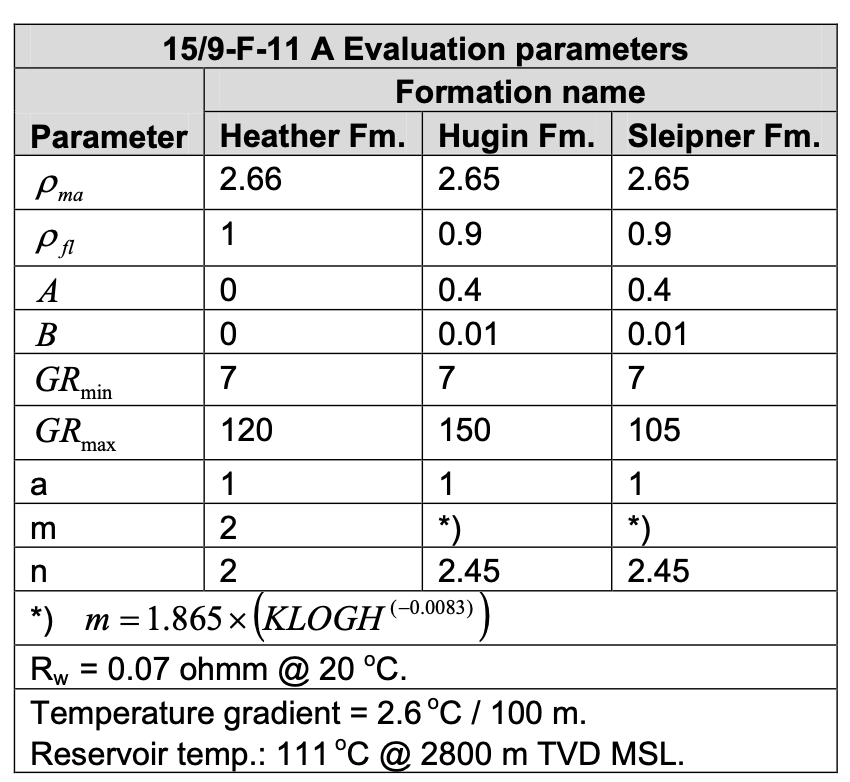

In [85]:
Image("img/F-11A.png")

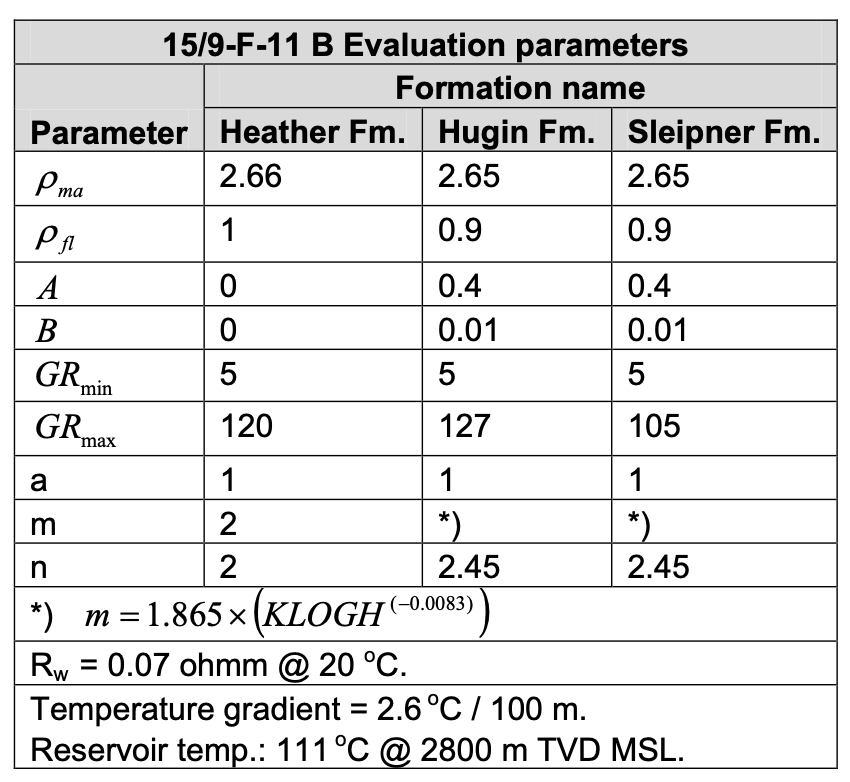

In [86]:
Image("img/F-11B.png")

### 9.2. Total Porosity
Total porosity, PHIF (φF ), is derived from the density log which is calibrated to overburden corrected core porosity for wells drilled with either OBM or WBM.

The Neutron log, NPHI, has been used to correct for varying mud filtrate invasion.
- φF =φD +A×(NPHI−φD)+B 

where:
- φD = (ρma − ρb) / (ρma −ρfl)
    - ρma is the matrix density [g/cm3] 
    - ρb is the measured bulk density (RHOB), [g/cm ] 
    - ρfl is the pore fluid density [g/cm3].
    - A and B are regression coefficients.
    - NPHI: Neutron log in limestone units [fraction]

<b>F_11T2</b>

In [87]:
# tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
# tops_depths=[4334.7, 4393.0, 4497.4]
f_11t2_final['Depth'] = f_11t2_final.index
f_11t2_final['DNPOR'] = np.nan
f_11t2_final['PHIT'] = np.nan

def denpor(RHOB, depth):
    if depth>=4334.7 and depth<4393.0: 
        return (2.66-RHOB)/(2.66-1)
    elif  depth>=4393.0:
        return (2.65-RHOB)/(2.65-0.9)
    
def tpor(DNPOR, NPHI, depth):
    if depth>=4334.7 and depth<4393.0: 
        return DNPOR + 0*(NPHI - DNPOR) + 0
    elif  depth>=4393.0:
        return DNPOR + 0*(NPHI - DNPOR) + 0

f_11t2_final['DNPOR'] = f_11t2_final.apply(lambda x: denpor(x.RHOB, x.Depth), axis=1)
f_11t2_final['PHIT'] = f_11t2_final.apply(lambda x: tpor(x.DNPOR, x.NPHI, x.Depth), axis=1)

<b>F_11A</b>

In [88]:
# tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
# tops_depths=[3574.9, 3594.6, 3702]
f_11a_final['Depth'] = f_11a_final.index
f_11a_final['DNPOR'] = np.nan
f_11a_final['PHIT'] = np.nan

def denpor(RHOB, depth):
    if depth>=3574.9 and depth<3594.6: 
        return (2.66-RHOB)/(2.66-1)
    elif  depth>=3594.6:
        return (2.65-RHOB)/(2.65-0.9)
    
def tpor(DNPOR, NPHI, depth):
    if depth>=3574.9 and depth<3594.6: 
        return DNPOR + 0*(NPHI - DNPOR) + 0
    elif  depth>=3594.6:
        return DNPOR + 0.4*(NPHI - DNPOR) + 0.01

f_11a_final['DNPOR'] = f_11a_final.apply(lambda x: denpor(x.RHOB, x.Depth), axis=1)
f_11a_final['PHIT'] = f_11a_final.apply(lambda x: tpor(x.DNPOR, x.NPHI, x.Depth), axis=1)

<b>F_11B</b>

In [89]:
# tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
# tops_depths=[3351, 3467.5, 4732]
f_11b_final['Depth'] = f_11b_final.index
f_11b_final['DNPOR'] = np.nan
f_11b_final['PHIT'] = np.nan

def denpor(RHOB, depth):
    if depth>=3351 and depth<3467.5: 
        return (2.66-RHOB)/(2.66-1)
    elif  depth>=3467.5:
        return (2.65-RHOB)/(2.65-0.9)
    
def tpor(DNPOR, NPHI, depth):
    if depth>=3351 and depth<3467.5: 
        return DNPOR + 0*(NPHI - DNPOR) + 0
    elif  depth>=3467.5:
        return DNPOR + 0.4*(NPHI - DNPOR) + 0.01

f_11b_final['DNPOR'] = f_11b_final.apply(lambda x: denpor(x.RHOB, x.Depth), axis=1)
f_11b_final['PHIT'] = f_11b_final.apply(lambda x: tpor(x.DNPOR, x.NPHI, x.Depth), axis=1)

In [90]:
display(f_11t2_final['PHIT'].describe(),f_11a_final['PHIT'].describe(),f_11b_final['PHIT'].describe())

count    1782.000000
mean        0.110884
std         0.061591
min        -0.045000
25%         0.070331
50%         0.108675
75%         0.160264
max         0.206943
Name: PHIT, dtype: float64

count    1482.000000
mean        0.167129
std         0.070745
min        -0.152892
25%         0.122904
50%         0.187487
75%         0.223586
max         0.253163
Name: PHIT, dtype: float64

count    12816.000000
mean         0.173073
std          0.062326
min         -0.108735
25%          0.135736
50%          0.185009
75%          0.225068
max          0.272946
Name: PHIT, dtype: float64

In [91]:
f_11t2_final.loc[f_11t2_final['PHIT']<0] = 0
f_11a_final.loc[f_11a_final['PHIT']<0] = 0
f_11b_final.loc[f_11b_final['PHIT']<0] = 0

### 9.3. Shale volume 

To determine VSH, the standard model VSHGR from linear GR relationship is applied:

VSH = (GR − GRmin)/( GRmax −GRmin)

where:

- GR = gamma ray log reading [API]
- GRmin = GR reading in clean sand [API]
- GRmax = GR reading in shale [API]

<b>F_11T2</b>

In [92]:
# tops = ('HEATHER','HUGIN','SLEIPNER')
# tops_depths=(4334.7,4393.0,4497.4)

f_11t2_final['VSH'] = np.nan

def vsh(GR, depth):
    if depth>4334.7 and depth<4393.0: 
        return (GR-4)/(120-4)
    elif  depth>=4393.0 and depth<4497.4:
        return (GR-4)/(184-4)
    elif depth>=4497.4:
        return (GR-4)/(105-4)


f_11t2_final['VSH'] = f_11t2_final.apply(lambda x: vsh(x.GR, x.Depth), axis=1)

In [93]:
f_11t2_final.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2129 entries, 4300.0999999962605 to 4512.899999996067
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BS           2129 non-null   float64
 1   CALI         2129 non-null   float64
 2   DT           2129 non-null   float64
 3   DTS          2129 non-null   float64
 4   GR           2129 non-null   float64
 5   NPHI         2129 non-null   float64
 6   PEF          2129 non-null   float64
 7   RDEEP        2129 non-null   float64
 8   RHOB         2129 non-null   float64
 9   RMED         2129 non-null   float64
 10  ROP          2129 non-null   float64
 11  RT           2129 non-null   float64
 12  Lithology_A  2129 non-null   uint8  
 13  Lithology_B  2129 non-null   uint8  
 14  Lithology_C  2129 non-null   uint8  
 15  Lithology_D  2129 non-null   uint8  
 16  Depth        2129 non-null   float64
 17  DNPOR        1782 non-null   float64
 18  PHIT         178

<b>F_11A</b>

In [94]:
# tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
# tops_depths=[3574.9, 3594.6, 3702]

f_11a_final['VSH'] = np.nan

def vsh(GR, depth):
    if depth>=3574.9 and depth<3594.6: 
        return (GR-7)/(120-7)
    elif  depth>=3594.6 and depth<3702:
        return (GR-7)/(150-7)
    elif depth>=3702:
        return (GR-7)/(105-7)


f_11a_final['VSH'] = f_11a_final.apply(lambda x: vsh(x.GR, x.Depth), axis=1)

<b>F_11B</b>

In [95]:
# tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
# tops_depths=[3351, 3467.5, 4732]

f_11b_final['VSH'] = np.nan

def vsh(GR, depth):
    if depth>=3351 and depth<3467.5: 
        return (GR-5)/(120-5)
    elif  depth>=3467.5 and depth<4732:
        return (GR-5)/(127-5)
    elif depth>=4732:
        return (GR-5)/(105-5)


f_11b_final['VSH'] = f_11b_final.apply(lambda x: vsh(x.GR, x.Depth), axis=1)

In [96]:
display(f_11t2_final['VSH'].describe(),f_11a_final['VSH'].describe(),f_11b_final['VSH'].describe())

count    1692.000000
mean        0.336551
std         0.262253
min         0.030735
25%         0.131522
50%         0.195294
75%         0.598014
max         0.822313
Name: VSH, dtype: float64

count    1444.000000
mean        0.285377
std         0.217497
min         0.024091
25%         0.159451
50%         0.212417
75%         0.315822
max         0.887121
Name: VSH, dtype: float64

count    12714.000000
mean         0.245860
std          0.168751
min          0.035629
25%          0.105447
50%          0.209800
75%          0.323093
max          0.911506
Name: VSH, dtype: float64

In [97]:
f_11t2_final = f_11t2_final.dropna()
f_11a_final = f_11a_final.dropna()
f_11b_final = f_11b_final.dropna()

### 9.4. Permeability

 Calculate Permeability 
The horizontal log permeability, KLOGH, is derived from the following equation based on multivariable regression analysis between log porosity and shale volume (“normalized” against VSHDN) against overburden corrected core permeability:

- HuginFm.: KLOGH =10**(2+8×PHIF−9×VSH))
- SleipnerFm.: KLOGH =10**(−3+32×PHIF−2×VSH))
- SkagerakFm.: KLOGH =10**(−1.85+17.4×PHIF−3×VSH))
  

<b>F_11T2</b>

In [98]:
# tops = ('HEATHER','HUGIN','SLEIPNER')
# tops_depths=(4334.7,4393.0,4497.4)

f_11t2_final['KLOGH'] = np.nan

def klog(PHIT, VSH, depth):
    if depth>=4334.7 and depth<4393.0: 
        return 10**(2+8*PHIT-9*VSH)
    elif  depth>=4393.0 and depth<4497.4:
        return 10**(2+8*PHIT-9*VSH)
    elif depth>=4497.4:
        return 10**(-3+32*PHIT-2*VSH)
        
f_11t2_final['KLOGH'] = f_11t2_final.apply(lambda x: klog(x.PHIT, x.VSH, x.Depth), axis=1)

<b>F_11A</b>

In [99]:
# tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
# tops_depths=[3574.9, 3594.6, 3702]

f_11a_final['KLOGH'] = np.nan

def klog(PHIT, VSH, depth):
    if depth>=3574.9 and depth<3594.6: 
        return 10**(2+8*PHIT-9*VSH)
    elif  depth>=3594.6 and depth<3702:
        return 10**(2+8*PHIT-9*VSH)
    elif depth>=3702:
        return 10**(-3+32*PHIT-2*VSH)
        
f_11a_final['KLOGH'] = f_11a_final.apply(lambda x: klog(x.PHIT, x.VSH, x.Depth), axis=1)

<b>F_11B</b>

In [100]:
# tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
# tops_depths=[3351, 3467.5, 4732]

f_11b_final['KLOGH'] = np.nan

def klog(PHIT, VSH, depth):
    if depth>=3351 and depth<3467.5: 
        return 10**(2+8*PHIT-9*VSH)
    elif  depth>=3467.5 and depth<4732:
        return 10**(2+8*PHIT-9*VSH)
    elif depth>=4732:
        return 10**(-3+32*PHIT-2*VSH)
        
f_11b_final['KLOGH'] = f_11b_final.apply(lambda x: klog(x.PHIT, x.VSH, x.Depth), axis=1)

In [101]:
display(f_11t2_final['KLOGH'].describe(),f_11a_final['KLOGH'].describe(),f_11b_final['KLOGH'].describe())

count    1692.000000
mean       96.400927
std       184.278246
min         0.000026
25%         0.000556
50%        18.025236
75%       114.979021
max      1362.824712
Name: KLOGH, dtype: float64

count     1444.000000
mean       294.774500
std        753.041593
min          0.000006
25%          2.820692
50%         38.687712
75%        192.118772
max      10469.524048
Name: KLOGH, dtype: float64

count    12714.000000
mean       325.987556
std        482.953440
min          0.000002
25%          1.797657
50%         36.274370
75%        504.290657
max       2582.429730
Name: KLOGH, dtype: float64

### 9.5. Water Saturation
Water saturation is calculated using Archie equation, giving a total water saturation:

Swt = [(a×Rw)/((φF**m)*Rt)]**(1/n)

where:
 - a= Archie (tortuosity) factor
 - Rw= resistivity of formation water [Ohmm]
 - φF= Total porosity [fraction]
 -  m= cementation exponent
 -  Rt= true resistivity [Ohmm] 
 -  n= saturation exponent
 
Calculate cementation exponent 
-  m=1.865*(KLOGH**(−0.0083))

Water resistivity of formation at formation temperature -- RW

- Rw = Rw(TRW) * (TRW+KT1) / (FT + KT1) 

Rw(TRW) - Rw measured at temperature
TRW - temperature at which Resistivity was measured
FT - Formation Temperature
KT1 = 21.5 (for Metric units)

In [102]:
rw = (0.07*(20+21.5))/(111+21.5)
print(rw)

0.021924528301886795


<b>F_11T2</b>

In [103]:
# tops = ('HEATHER','HUGIN','SLEIPNER')
# tops_depths=(4334.7,4393.0,4497.4)

f_11t2_final['m']=np.nan
f_11t2_final['SW']=np.nan

def m(KLOGH, depth):
    if depth>=4334.7 and depth<4393.0: 
        return 2
    elif  depth>=4393.0:
        return 1.865*(KLOGH**(-0.0083))

def sw(RT, PHIT, m, depth):
    if depth>=4334.7 and depth<4393.0: 
        return ((1*rw)/((PHIT**m)*RT))**(1/2)
    elif  depth>=4393.0 and depth<4497.4:
        return ((1*rw)/((PHIT**m)*RT))**(1/2.45)
    elif depth>=4497.4:
        return ((1*rw)/((PHIT**m)*RT))**(1/2.45)
    
f_11t2_final['m'] = f_11t2_final.apply(lambda x: m(x.KLOGH, x.Depth), axis=1)
f_11t2_final['SW'] = f_11t2_final.apply(lambda x: sw(x.RT, x.PHIT, x.m, x.Depth), axis=1)

<b>F_11A</b>

In [104]:
# tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
# tops_depths=[3574.9, 3594.6, 3702]

f_11a_final['m']=np.nan
f_11a_final['SW']=np.nan

def m(KLOGH, depth):
    if depth>=3574.9 and depth<3594.6: 
        return 2
    elif  depth>=3594.6:
        return 1.865*(KLOGH**(-0.0083))

def sw(RT, PHIT, m, depth):
    if depth>=3574.9 and depth<3594.6: 
        return ((1*rw)/((PHIT**m)*RT))**(1/2)
    elif  depth>=3594.6 and depth<3702:
        return ((1*rw)/((PHIT**m)*RT))**(1/2.45)
    elif depth>=3702:
        return ((1*rw)/((PHIT**m)*RT))**(1/2.45)
    
f_11a_final['m'] = f_11a_final.apply(lambda x: m(x.KLOGH, x.Depth), axis=1)
f_11a_final['SW'] = f_11a_final.apply(lambda x: sw(x.RT, x.PHIT, x.m, x.Depth), axis=1)


<b>F_11B</b>

In [105]:
# tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
# tops_depths=[3351, 3467.5, 4732]

f_11b_final['m']=np.nan
f_11b_final['SW']=np.nan

def m(KLOGH, depth):
    if depth>=3351 and depth<3467.5: 
        return 2
    elif  depth>=3467.5:
        return 1.865*(KLOGH**(-0.0083))

def sw(RT, PHIT, m, depth):
    if depth>=3351 and depth<3467.5: 
        return ((1*rw)/((PHIT**m)*RT))**(1/2)
    elif  depth>=3467.5 and depth<4732:
        return ((1*rw)/((PHIT**m)*RT))**(1/2.45)
    elif depth>=4732:
        return ((1*rw)/((PHIT**m)*RT))**(1/2.45)
    
f_11b_final['m'] = f_11b_final.apply(lambda x: m(x.KLOGH, x.Depth), axis=1)
f_11b_final['SW'] = f_11b_final.apply(lambda x: sw(x.RT, x.PHIT, x.m, x.Depth), axis=1)


In [106]:
display(f_11t2_final['SW'].describe(),f_11a_final['SW'].describe(),f_11b_final['SW'].describe())

count    1692.000000
mean        1.314591
std         1.551049
min         0.236330
25%         1.030159
50%         1.105170
75%         1.232357
max        46.192081
Name: SW, dtype: float64

count    1444.000000
mean        0.555644
std         0.692979
min         0.076089
25%         0.290324
50%         0.376215
75%         0.610699
max        18.990244
Name: SW, dtype: float64

count    12714.000000
mean         0.464573
std          0.685224
min          0.096019
25%          0.139458
50%          0.307338
75%          0.582603
max         42.457040
Name: SW, dtype: float64

### 9.6. Bulk Volume of Water

In [107]:
# Calculate the BVW (bulk volume of water):

wells = [f_11t2_final, f_11a_final, f_11b_final]
for well in wells: 
    well['BVW']=well['SW']*well['PHIT']

### 9.7. Sand Flag

In [108]:
# Calculate Sand flag 
# SAND_FLAG = 1 when PHIF > 0.10 and VSH < 0.50.


def sand_flag(PHIF, VSH, KLOGH):
    if PHIF > 0.10 and VSH<0.50 and KLOGH>20: 
        return 1
    else:
        return 0
for well in wells:     
    well['SAND_FLAG'] = well.apply(lambda x: sand_flag(x.PHIT, x.VSH, x.KLOGH), axis=1)

In [109]:
display(f_11t2_final.info(), f_11a_final.info(), f_11b_final.info())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1692 entries, 4334.7999999962285 to 4512.899999996067
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BS           1692 non-null   float64
 1   CALI         1692 non-null   float64
 2   DT           1692 non-null   float64
 3   DTS          1692 non-null   float64
 4   GR           1692 non-null   float64
 5   NPHI         1692 non-null   float64
 6   PEF          1692 non-null   float64
 7   RDEEP        1692 non-null   float64
 8   RHOB         1692 non-null   float64
 9   RMED         1692 non-null   float64
 10  ROP          1692 non-null   float64
 11  RT           1692 non-null   float64
 12  Lithology_A  1692 non-null   uint8  
 13  Lithology_B  1692 non-null   uint8  
 14  Lithology_C  1692 non-null   uint8  
 15  Lithology_D  1692 non-null   uint8  
 16  Depth        1692 non-null   float64
 17  DNPOR        1692 non-null   float64
 18  PHIT         169

None

None

None

### 9.8. Evaluation Logs

In [110]:
def plotalllogs2(dataframe):
#=============================================================================    
    tracks=6
    linewidth=0.5
    ## Gamma Ray, PE, ROP, CALI
    trackGR=0 #Gamma Ray
    ## Resistivity
    trackRes=1
    ## RHOB, NPHI
    trackPOR=2
    ## DT, DTS
    trackFLAG=3
    ## BVW and PHIT
    trackBVW=4 
    ## Calculated features
    trackMATRIX=5
    
#=============================Parameters and formation lines=====================================    
    pylab.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (10,20)})
    fig,axes = plt.subplots(1,tracks,sharey=True,figsize=(15,15), dpi=90) ##sharey: share y axis
    fig.gca().invert_yaxis()
    
    for ax in axes:
        for (i,j) in zip(tops_depths,tops):
                ax.axhline(y=i, linewidth=1, color='red')
                ax.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')

# ================================trackGR=============================================

    ## GR
    ax1 = axes[trackGR].twiny()
    ax1.grid(which='both')
    ax1.plot(dataframe['GR'],dataframe.index, label='GR', color='green', lw=2)
    ax1.set_xlabel('GR, [gapi]')
    ax1.set_xlim(0,250)   
    ax1.set_xticks([0, 50, 150, 250])
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.spines['top'].set_position(('outward',0))
    ax1.spines['top'].set_color('green')
    ax1.xaxis.label.set_color('green')
    ax1.tick_params(axis='x', colors='green')
    

    # https://towardsdatascience.com/enhancing-visualization-of-well-logs-with-plot-fills-72d9dcd10c1b
    left_value = 0
    right_value = 250
    span = abs(left_value-right_value)
    cmap = plt.get_cmap('hot_r')
    color_index = np.arange(left_value, right_value, span/100)   
    for index in sorted(color_index):
        index_value =(index-left_value)/span
        color = cmap(index_value)
        ax1.fill_betweenx(dataframe.index, 0, dataframe['GR'], where=dataframe['GR']>=index, color=color)
  
    ## CALI
    ax2 = axes[trackGR].twiny()
    # ax2.grid(which='both')
    ax2.plot(dataframe['CALI'],dataframe.index, label='CALI', color='magenta', lw=linewidth)
    ax2.set_xlabel('CALI, [inches]')
    ax2.set_xlim(1,10)
    ax2.set_xticks([0, 5, 10])
    ax2.xaxis.set_ticks_position('top')
    ax2.xaxis.set_label_position('top')
    ax2.spines['top'].set_position(('outward', 40))
    ax2.spines['top'].set_color('magenta')
    ax2.xaxis.label.set_color('magenta')
    ax2.tick_params(axis='x', colors='magenta')
    
    ## ROP
    ax3 = axes[trackGR].twiny()
    ax3.plot(dataframe['ROP'],dataframe.index, label='ROP', ls = '--', color='slateblue', lw=linewidth)
    ax3.set_xlabel('ROP, [m/hr]')
    ax3.set_xlim(0,100)   
    ax3.xaxis.set_ticks_position('top')
    ax3.xaxis.set_label_position('top')
    ax3.spines['top'].set_position(('outward', 80))
    ax3.spines['top'].set_color('slateblue')
    ax3.xaxis.label.set_color('slateblue')
    ax3.tick_params(axis='x', colors='slateblue')
    
    ##PE
    ax4 = axes[trackGR].twiny()
    ax4.plot(dataframe['PEF'],dataframe.index, label='PE', color='blue', ls = '--', lw=linewidth)
    ax4.set_xlabel('PE, [barns/electron]')
    ax4.set_xlim(0,10)
    ax4.set_xticks([0, 5, 10])
    ax4.xaxis.set_ticks_position('top')
    ax4.xaxis.set_label_position('top')  
    ax4.spines['top'].set_position(('outward', 120))
    ax4.spines['top'].set_color('blue')
    ax4.xaxis.label.set_color('blue')
    ax4.tick_params(axis='x', colors='blue')
    
#==================================trackRes=============================================

    # Resistivity   
    ax1 = axes[trackRes].twiny()
    ax1.set_xscale('log')
    ax1.grid(which='both')
    ax1.plot(dataframe['RDEEP'],dataframe.index, label='RDEEP', color='cyan', lw=linewidth)
    ax1.plot(dataframe['RMED'],dataframe.index, label='RMED',color='darkblue', ls = '--', lw=linewidth)
    ax1.plot(dataframe['RT'],dataframe.index, label='RT',color='lime', ls = '--', lw=linewidth)
    ax1.set_xlabel('Resistivity, [ohm.m]')
    ax1.spines['top'].set_position(('outward', 0))
    ax1.legend(loc=1)
    ax1.set_xlim(0.1,1000)
    ax1.set_xticks([0.1, 1, 10, 100, 1000])
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    
    # Permeability
    ax2 = axes[trackRes].twiny()
    ax2.set_xscale('log')
    ax2.plot(dataframe['KLOGH'],dataframe.index, label='KLOGH', color='red', lw=linewidth)
    ax2.set_xlabel('KLOGH, [mDarcy]')
    ax2.spines['top'].set_position(('outward', 40))
    ax2.set_xlim(0.02,20000)
    ax2.set_xticks([0.02, 2, 200, 20000])
    ax2.xaxis.set_ticks_position('top')
    ax2.xaxis.set_label_position('top')
    ax2.fill_betweenx(dataframe.index,0.02,dataframe.KLOGH,color='orange',alpha=0.1)
    ax2.xaxis.set_major_formatter(ScalarFormatter())
    ax2.spines['top'].set_color('red')
    ax2.xaxis.label.set_color('red')
    ax2.tick_params(axis='x', colors='red')
# ====================================trackPOR=========================================

    ## RHOB
    ax1 = axes[trackPOR].twiny()
    ax1.plot(dataframe['RHOB'],dataframe.index, label=r'$\rho_b$', color='red', lw=1)
    ax1.set_xlabel(r'$\rho_b, g/cc$')
    ax1.set_xlim(1.95,2.95)
    ax1.set_xticks([1.95, 2.2, 2.45, 2.7, 2.95])
    ax1.spines['top'].set_position(('outward', 40))
    ax1.xaxis.set_ticks_position('top') # set the position of the second x-axis to top
    ax1.xaxis.set_label_position('top') # set the position of the second x-axis to top
    ax1.legend(bbox_to_anchor=(0.6, .9))
    ax1.spines['top'].set_color('red')
    ax1.xaxis.label.set_color('red')
    ax1.tick_params(axis='x', colors='red')
    
    ##NPHI
    ax2 = axes[trackPOR]
    ax2.grid(which='both')
    ax2.plot(dataframe['NPHI'],dataframe.index, label=r'$\phi_N$', color='blue', lw=2)
    ax2.set_xlim(0.45, -0.15)
    ax2.set_xticks([0.45, 0.3, 0.15, 0, -0.15])
    ax2.set_xlabel(r'$\phi_N$, %') 
    ax2.legend(bbox_to_anchor=(0.6, 1))
    ax2.xaxis.set_label_position('top') # set the position of the second x-axis to top
    ax2.xaxis.set_ticks_position('top')
    ax2.spines['top'].set_color('blue')
    ax2.xaxis.label.set_color('blue')
    ax2.tick_params(axis='x', colors='blue')

    
    # https://towardsdatascience.com/enhancing-visualization-of-well-logs-with-plot-fills-72d9dcd10c1b
    x1=dataframe['RHOB']
    x2=dataframe['NPHI']
    x = np.array(ax1.get_xlim())
    z = np.array(ax2.get_xlim())
    nz=((x2-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)
    ax1.fill_betweenx(dataframe.index, x1, nz, where=x1>=nz, interpolate=True, color='green')
    ax1.fill_betweenx(dataframe.index, x1, nz, where=x1<=nz, interpolate=True, color='yellow')

# ====================================trackFLAG=========================================
    
    ## Mudlog Litho Flags
    ax1 = axes[trackFLAG].twiny()
    ax1.grid(which='both')
    ax1.plot(dataframe['Lithology_A'],dataframe.index, label='Lithology_A',color='black', lw=linewidth)
    ax1.plot(dataframe['Lithology_B'],dataframe.index, label='Lithology_B',color='black', lw=linewidth)
    ax1.plot(dataframe['Lithology_C'],dataframe.index, label='Lithology_C',color='black', lw=linewidth)
    ax1.plot(dataframe['Lithology_D'],dataframe.index, label='Lithology_D',color='black', lw=linewidth)
    # ax1.plot(dataframe['Lithology_E'],dataframe.index, label='Lithology_E',color='black', lw=linewidth)
    # ax1.plot(dataframe['Lithology_F'],dataframe.index, label='Lithology_F',color='black', lw=linewidth)
    ax1.set_xlabel('Cuttings')
    ax1.spines['top'].set_position(('outward', 0))
    ax1.set_xlim(1.5, 0)
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')

    ax2 = axes[trackFLAG].twiny()
    ax2.set_xlim(1.5, 0)
    ax2.spines['top'].set_position(('outward',0))
    ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_A,facecolor='lightgray',label='Lithology_A', hatch='--')
    ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_B,facecolor='cyan',label='Lithology_B', hatch='-.-')
    ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_C,facecolor='yellow',label= 'Lithology_C', hatch='..')
    ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_D,color='black',label= 'Lithology_D')
    # ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_E,color='blue',label= 'Lithology_E')
    # ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_F,color='white',label= 'Lithology_F')
    ax2.legend(loc='lower left')
    
    ## SAND_FLAG
    ax3 = axes[trackFLAG].twiny()
    ax3.fill_betweenx(dataframe.index, dataframe.SAND_FLAG, 0, where=(dataframe.SAND_FLAG > 0), color='red')
    ax3.set_xlim(0,10) 
    ax3.set_xlabel('SAND_FLAG')
    # ax3.tick_params(axis='x')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('outward', 40))
    ax3.spines['top'].set_color('red')
    ax3.xaxis.label.set_color('red')
    ax3.tick_params(axis='x', colors='red')
    
    

# ====================================trackBVW=========================================

    ## BVW
    ax1 = axes[trackBVW].twiny()
    ax1.grid(which='both')
    ax1.plot(dataframe['BVW'],dataframe.index, label='BVW', lw=linewidth)
    ax1.set_xlabel('BWV, [v/v]')
    ax1.set_xlim(1,0)
    ax1.set_xticks([1, 0.8, 0.6, 0.4, 0.2, 0])
    ax1.spines['top'].set_position(('outward',0))
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')  
    ax1.fill_betweenx(dataframe.index,0,dataframe.BVW,color='lightblue')
    # ax1.spines['top'].set_color('blue')
    # ax1.xaxis.label.set_color('blue')
    # ax1.tick_params(axis='x', colors='blue')
    
    ## PHIT
    ax2 = axes[trackBVW].twiny()
    # ax2.grid(which='both')
    ax2.plot(dataframe['PHIT'],dataframe.index, label='PHIT', lw=1, color='red')
    ax2.set_xlabel('PHIT, [v/v]')
    ax2.set_xlim(1,0)
    ax2.set_xticks([1, 0.8, 0.6, 0.4, 0.2, 0])
    ax2.spines['top'].set_position(('outward', 40))
    ax2.xaxis.set_ticks_position('top')
    ax2.xaxis.set_label_position('top')  
    ax2.spines['top'].set_color('red')
    ax2.xaxis.label.set_color('red')
    ax2.tick_params(axis='x', colors='red')
    
    ## SW
    ax3 = axes[trackBVW].twiny()
    # ax3.grid(which='both')
    ax3.plot(dataframe['SW'],dataframe.index, label='SW', lw=linewidth, color='black')
    ax3.set_xlabel('SW, [v/v]')
    ax3.set_xlim(1,0)
    ax3.set_xticks([1, 0.8, 0.6, 0.4, 0.2, 0])
    ax3.spines['top'].set_position(('outward', 80))
    ax3.xaxis.set_ticks_position('top')
    ax3.xaxis.set_label_position('top')
    ax3.fill_betweenx(dataframe.index,0,dataframe.SW,color='cyan', alpha=0.1)
    ax3.spines['top'].set_color('blue')
    ax3.xaxis.label.set_color('blue')
    ax3.tick_params(axis='x', colors='blue')
    
# ====================================trackMATRIX=========================================
    
    ## PHIT
    ax1 = axes[trackMATRIX].twiny()
    ax1.grid(which='both')
    ax1.plot(dataframe['PHIT'],dataframe.index, label='PHIT', color='blue', lw=linewidth)
    ax1.set_xlim(0, 1)
    ax1.set_xlabel('PHIT, [v/v]') 
    # ax8.legend(bbox_to_anchor=(0.6, 1))
    ax1.spines['top'].set_position(('outward',0))
    ax1.xaxis.set_label_position('top') # set the position of the second x-axis to top
    ax1.xaxis.set_ticks_position('top')
    # ax8.set_xticks([0, 20, 40, 60, 80, 100])
    ax1.tick_params(axis='x', colors='blue')
    ax1.xaxis.label.set_color('blue')
    
    ## VSH
    ax2 = axes[trackMATRIX].twiny()
    ax2.grid(which='both')
    ax2.plot(dataframe['VSH'],dataframe.index, label='VSH', color='green', lw=linewidth)
    ax2.set_xlim(1, 0)
    ax2.set_xlabel('VSH, [v/v]') 
    # ax2.legend(bbox_to_anchor=(0.6, 1))
    ax2.spines['top'].set_position(('outward',40))
    ax2.xaxis.set_label_position('top') # set the position of the second x-axis to top
    ax2.xaxis.set_ticks_position('top')
    # ax2.tick_params(axis='x', colors='green')
    # ax2.set_xticks([0, 20, 40, 60, 80, 100])
    
    ax3 = axes[trackMATRIX].twiny()
    ax3.set_xlim(1,0)
    ax3.spines['top'].set_position(('outward',0))
    ax3.fill_betweenx(dataframe.index,0,dataframe.PHIT,color='lightblue',label='porosity')
    ax3.fill_betweenx(dataframe.index,dataframe.PHIT,1-dataframe.VSH,color='yellow',label='matrix')
    ax3.fill_betweenx(dataframe.index,1-dataframe.VSH,1,color='lightgray',label= 'vshale')
    ax3.legend(loc='lower left')


#### 9.8.1. F_11T2 Plot

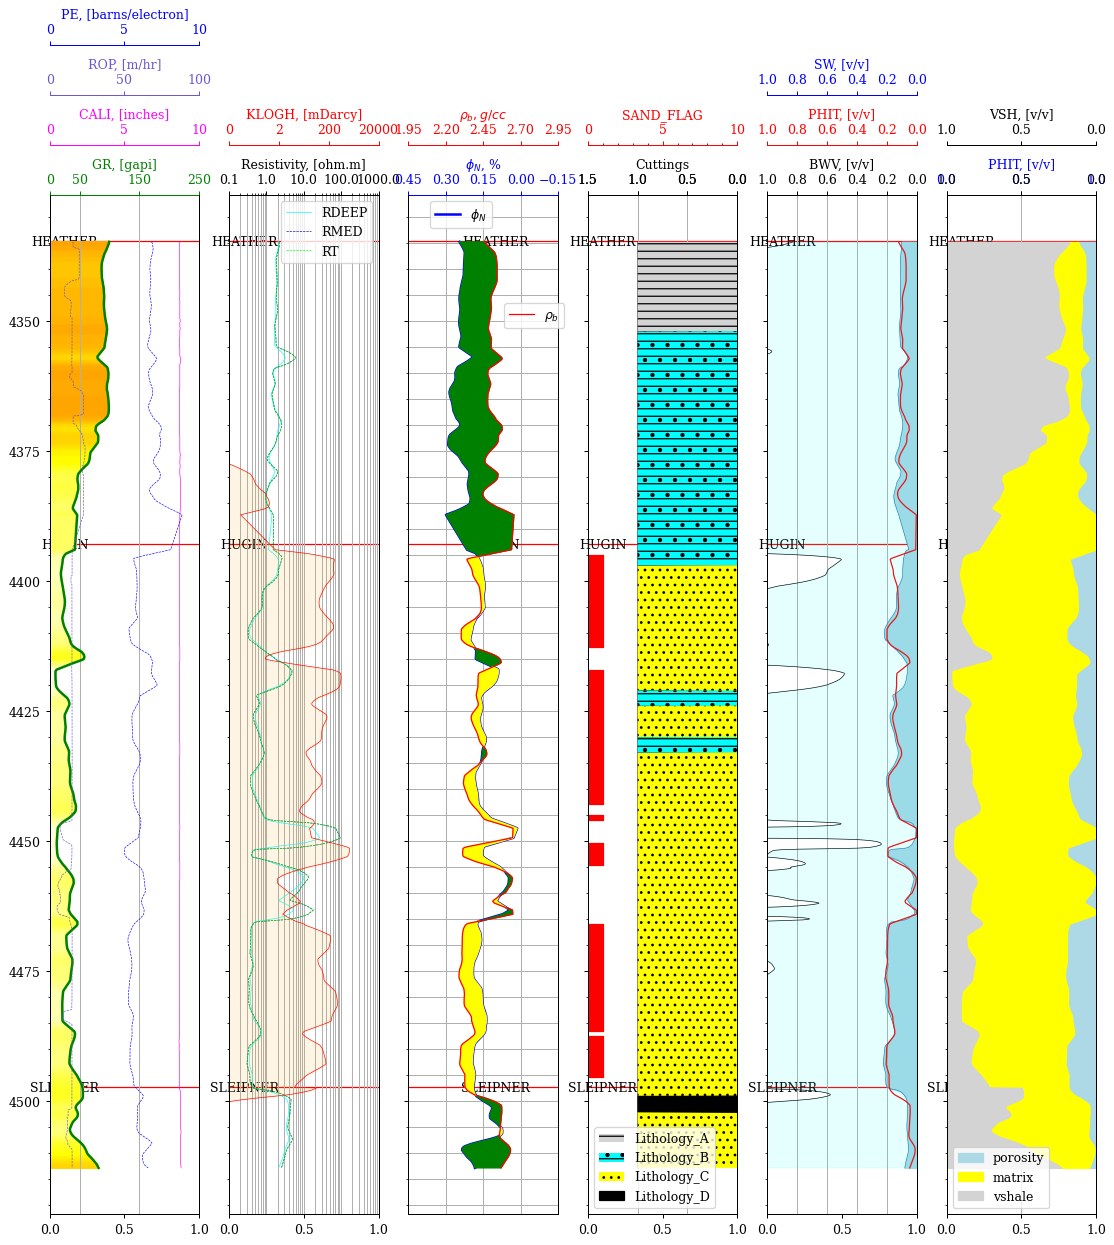

In [111]:
tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
tops_depths=[4334.7, 4393.0, 4497.4]
plotalllogs2(f_11t2_final)

#### 9.8.2. F_11A Plot

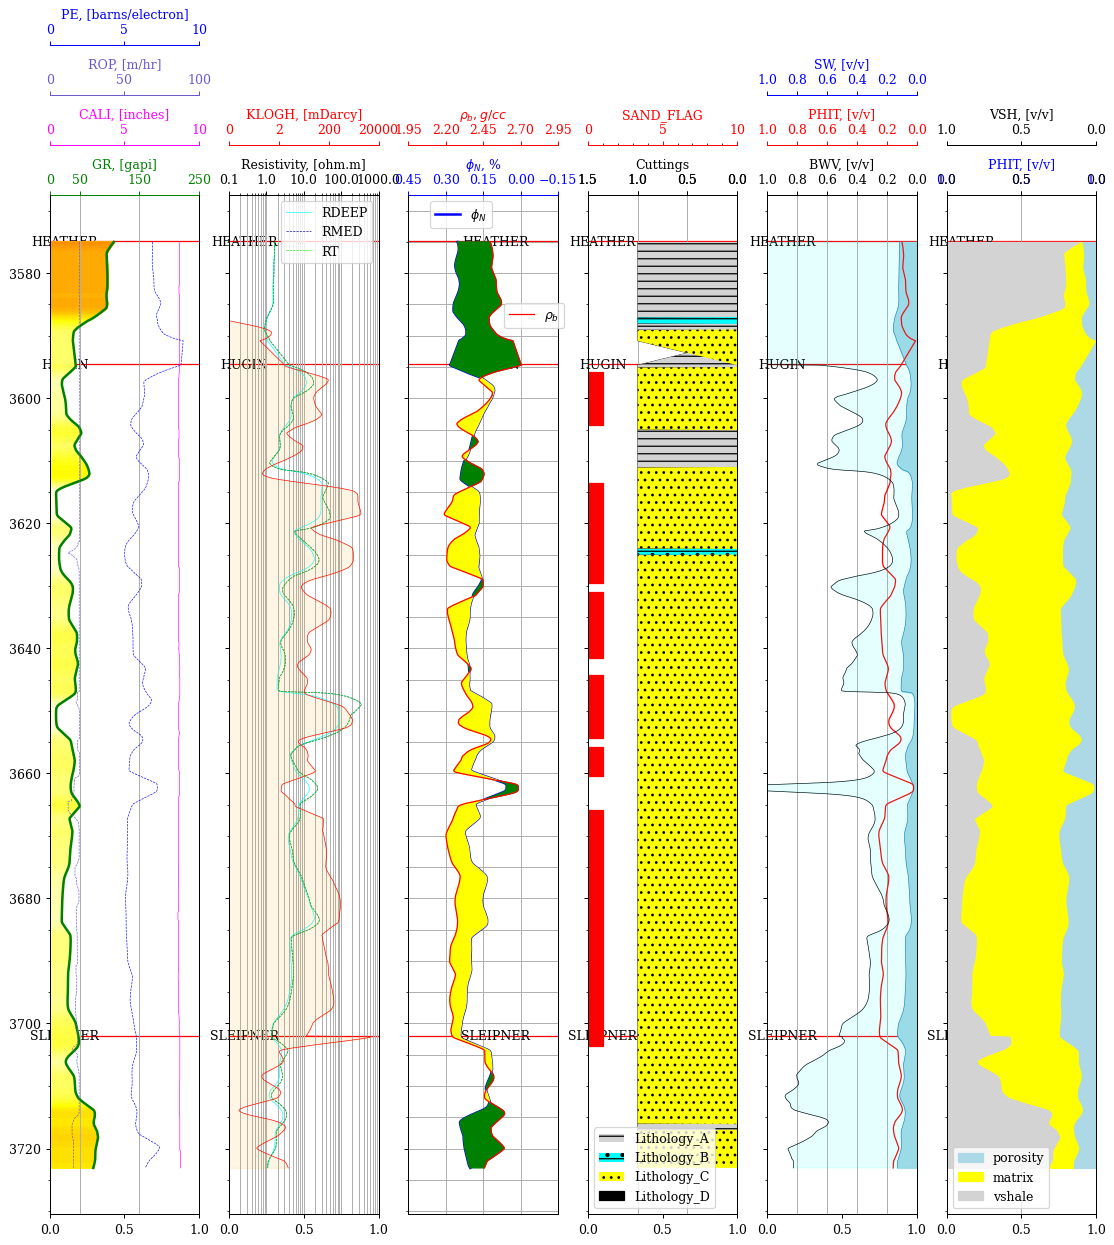

In [112]:
tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
tops_depths=[3574.9, 3594.6, 3702]
plotalllogs2(f_11a_final)

#### 9.8.3. F_11B Plot

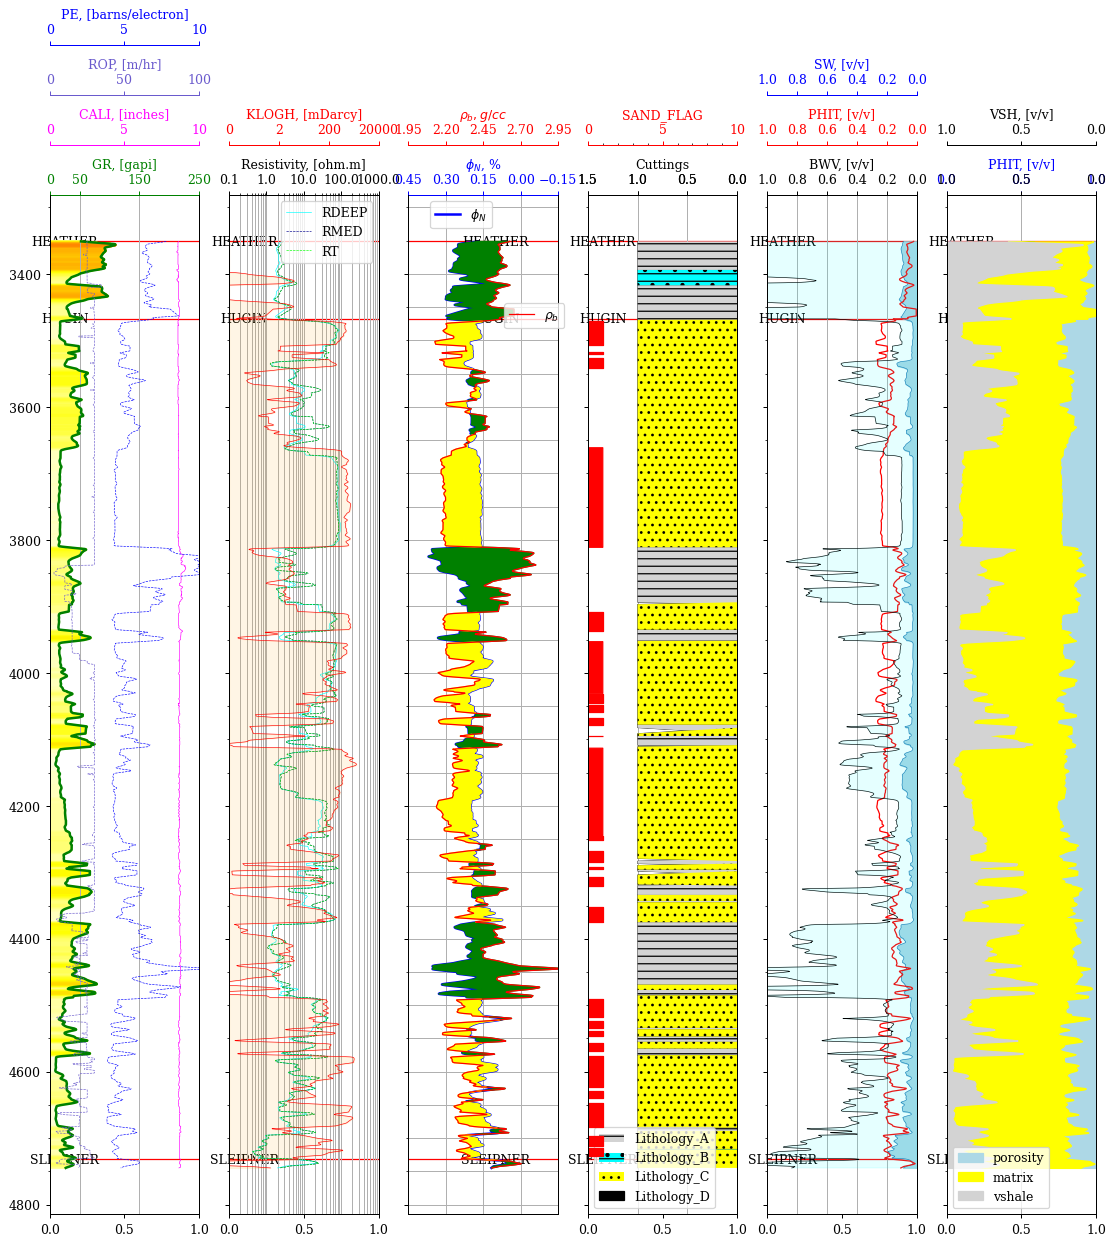

In [113]:
tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
tops_depths=[3351, 3467.5, 4732]
plotalllogs2(f_11b_final)

### 9.9. HUGIN Formation summary

 ====== F-11 T2 =====
ZONE: HUGIN FORMATION
 4393.0 m- 4497.4 m 
Total: 104 m
Mean values:


SW      1.144632
BVW     0.144200
PHIT    0.143083
VSH     0.143958
dtype: float64

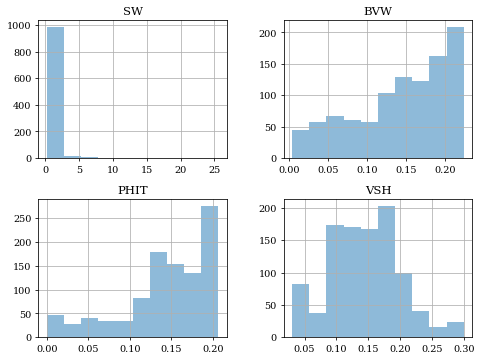

In [114]:
# tops = ('HEATHER','HUGIN','SLEIPNER')
# tops_depths=(4334.7,4393.0,4497.4)

top_summary = 4393.0
depth_summary = 4497.4
print(" ====================\n",
      "====== F-11 T2 =====")
f_11t2_final.loc[top_summary:depth_summary,{'PHIT','SW','BVW','VSH'}].hist(figsize=(8, 6),alpha=0.5)
print ('ZONE: HUGIN FORMATION\n', top_summary, 'm-', depth_summary, 'm', '\nTotal:', round(depth_summary-top_summary), 'm')
print ('Mean values:')
f_11t2_final.loc[top_summary:depth_summary,{'PHIT','SW','BVW','VSH'}].mean()


 ====== F-11 A ======
ZONE: HUGIN FORMATION
 3594.6 m- 3702 m 
Total: 107 m
Mean values:


SW      0.337271
BVW     0.063605
PHIT    0.196091
VSH     0.180910
dtype: float64

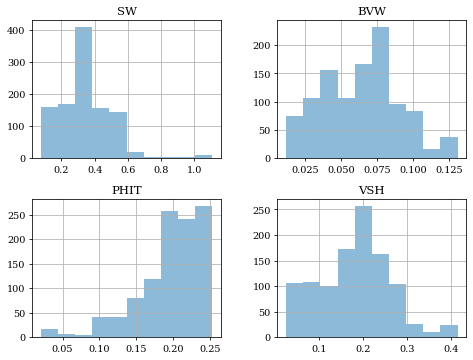

In [115]:
# tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
# tops_depths=[3574.9, 3594.6, 3702]
top_summary = 3594.6
depth_summary = 3702
print(" ====================\n",
      "====== F-11 A ======")
f_11a_final.loc[top_summary:depth_summary,{'PHIT','SW','BVW','VSH'}].hist(figsize=(8, 6),alpha=0.5)
print ('ZONE: HUGIN FORMATION\n', top_summary, 'm-', depth_summary, 'm', '\nTotal:', round(depth_summary-top_summary), 'm')
print ('Mean values:')
f_11a_final.loc[top_summary:depth_summary,{'PHIT','SW','BVW','VSH'}].mean()


 ====== F-11 B ======
ZONE: HUGIN FORMATION 
 3467.5 m- 4732 m 
Total: 1264 m
Mean values:


SW      0.341774
BVW     0.055401
PHIT    0.186442
VSH     0.215728
dtype: float64

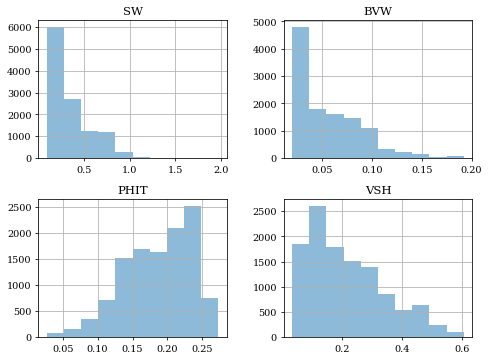

In [116]:
# tops = ['HEATHER', 'HUGIN', 'SLEIPNER']
# tops_depths=[3351, 3467.5, 4732]
top_summary = 3467.5
depth_summary = 4732
print(" ====================\n",
      "====== F-11 B ======")
f_11b_final.loc[top_summary:depth_summary,{'PHIT','SW','BVW','VSH'}].hist(figsize=(8, 6),alpha=0.5)
print ('ZONE: HUGIN FORMATION \n', top_summary, 'm-', depth_summary, 'm', '\nTotal:', round(depth_summary-top_summary), 'm')
print ('Mean values:')
f_11b_final.loc[top_summary:depth_summary,{'PHIT','SW','BVW','VSH'}].mean()


## 10. Facies Classification

In [117]:
# Create Formation tops columns 
f_11t2_final['TOPS'] = np.nan

def tops(depth):
    if depth>=4334.7 and depth<4393.0: 
        return 'Heather'
    elif  depth>=4393.0 and depth<4497.4:
        return 'Hugin'
    elif depth>=4497.4:
        return 'Sleipner'
    
f_11t2_final['TOPS']=f_11t2_final.apply(lambda x: tops(x.Depth), axis=1)

In [118]:
# Create Formation tops columns 
f_11a_final['TOPS'] = np.nan

def tops(depth):
    if depth>=3574.9 and depth<3594.6: 
        return 'Heather'
    elif  depth>=3594.6 and depth<3702:
        return 'Hugin'
    elif depth>=3702:
        return 'Sleipner'
    
f_11a_final['TOPS']=f_11a_final.apply(lambda x: tops(x.Depth), axis=1)

In [119]:
# Create Formation tops columns 
f_11b_final['TOPS'] = np.nan


def tops(depth):
    if depth>=3351 and depth<3467.5: 
        return 'Heather'
    elif  depth>=3467.5 and depth<4732:
        return 'Hugin'
    elif depth>=4732:
        return 'Sleipner'
    
f_11b_final['TOPS']=f_11b_final.apply(lambda x: tops(x.Depth), axis=1)

In [120]:
f_11b_final.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 12714 entries, 3351.0999999971236 to 4744.699999995856
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BS           12714 non-null  float64
 1   CALI         12714 non-null  float64
 2   GR           12714 non-null  float64
 3   NPHI         12714 non-null  float64
 4   PEF          12714 non-null  float64
 5   RHOB         12714 non-null  float64
 6   ROP          12714 non-null  float64
 7   RT           12714 non-null  float64
 8   RMED         12714 non-null  float64
 9   RDEEP        12714 non-null  float64
 10  DT           12714 non-null  float64
 11  DTS          12714 non-null  float64
 12  Lithology_A  12714 non-null  uint8  
 13  Lithology_B  12714 non-null  uint8  
 14  Lithology_C  12714 non-null  uint8  
 15  Lithology_D  12714 non-null  uint8  
 16  Depth        12714 non-null  float64
 17  DNPOR        12714 non-null  float64
 18  PHIT         12

In [121]:
# drop all columns but DT, NPHI, RHOB, Depth, PHIT, VSH, KLOGH

f_11t2_ = f_11t2_final[f_11t2_final['TOPS']=='Hugin']
f_11t2_ = f_11t2_.drop(f_11t2_.columns[[0,1,3,4,6,7,9,10,11,12,13,14,15,17,21,22,23,24,25]],axis=1)
f_11t2_['WELL_NAME'] = 'F_11T2'

f_11a_ = f_11a_final[f_11a_final['TOPS']=='Hugin']
f_11a_ = f_11a_.drop(f_11a_.columns[[0,1,3,4,6,7,9,10,11,12,13,14,15,17,21,22,23,24,25]],axis=1)
f_11a_['WELL_NAME'] = 'F_11A'

f_11b_ = f_11b_final[f_11b_final['TOPS']=='Hugin']
f_11b_ = f_11b_.drop(f_11b_.columns[[0,1,2,4,6,7,8,9,11,12,13,14,15,17,21,22,23,24,25]],axis=1)
f_11b_['WELL_NAME'] = 'F_11B'

df_facies = f_11t2_.append([f_11a_, f_11b_], sort=False)
df_facies = df_facies.reset_index(drop = True)



In [122]:
df_facies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13609 entries, 0 to 13608
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DT         13609 non-null  float64
 1   NPHI       13609 non-null  float64
 2   RHOB       13609 non-null  float64
 3   Depth      13609 non-null  float64
 4   PHIT       13609 non-null  float64
 5   VSH        13609 non-null  float64
 6   KLOGH      13609 non-null  float64
 7   WELL_NAME  13609 non-null  object 
dtypes: float64(7), object(1)
memory usage: 850.7+ KB


In [123]:
# https://github.com/andymcdgeo/Unsupervised_Facies_Clustering/blob/main/Unsupervised%20Clustering.ipynb

scaler = StandardScaler()
Prescale = Pipeline(steps=[('scale',scaler)])

def facies_cluster(df, name='', ncomp=0, nclus=0):
    # Elbow method
    wcss, maxit = [], 11
    nClusters=range(1,maxit)
    for i in nClusters:
        kmeans = KMeans(n_clusters=i, init='k-means++', n_init=20, max_iter=500, random_state=40)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
    plt.figure()
    plt.plot(nClusters, wcss,'^-')
    plt.axvline(x = nclus-1, linewidth = 1, color = 'red')
    plt.axvline(x = nclus, linewidth = 2, color = 'red')
    plt.axvline(x = nclus+1, linewidth = 1, color = 'red')
    plt.title('Elbow Method')
    plt.xlabel('Number of Clusters')
    plt.ylabel('wcss')
    plt.xticks(np.arange(0, maxit, step=1))
    plt.show()
    
    # Silhouette method
    silhouette_score_values=[]
    for i in nClusters:
        if i != 1:
            kmeans=KMeans(n_clusters=i,init='k-means++', n_init=20, max_iter=500,
                      tol=0.0001, verbose=0, random_state=100, copy_x=True)
            kmeans.fit(df)
            labels= kmeans.predict(df)
            silhouette_avg=silhouette_score(df,labels ,metric='euclidean', sample_size=None, random_state=None)
            silhouette_score_values.append(silhouette_avg)
            print('Number of Clusters:%s'%i, 'Silhouette score:%s'%round(silhouette_avg, 5))
        else:
            silhouette_avg=0
            silhouette_score_values.append(silhouette_avg)       
    Optimal_Number=nClusters[silhouette_score_values.index(max(silhouette_score_values))]
    print ('Optimal number of clusters is: %s' % Optimal_Number)
    plt.figure()
    plt.plot(nClusters[1:], silhouette_score_values[1:],'o-')
    plt.title("Silhouette score values vs Numbers of Clusters ")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette score values')
    plt.xticks(np.arange(0, maxit, step=1))
    plt.show()     
    
    # fitting kmeans to dataset
    kmeans = KMeans(n_clusters=nclus, init='k-means++', n_init=10, max_iter=300, random_state=42)
    Y_kmeans = kmeans.fit_predict(df)
    
    #cluster zone ids to VShale database
    df['%s' % name]=kmeans.labels_
    return df 

We will be using VSH, RHOB, NPHI, PHIT, KLOGH logs for facies classification, as they are independent of reservoir fluid saturations. 

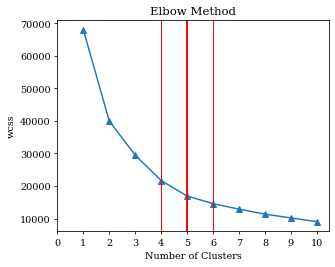

Number of Clusters:2 Silhouette score:0.38005
Number of Clusters:3 Silhouette score:0.33739
Number of Clusters:4 Silhouette score:0.38671
Number of Clusters:5 Silhouette score:0.39408
Number of Clusters:6 Silhouette score:0.3886
Number of Clusters:7 Silhouette score:0.36496
Number of Clusters:8 Silhouette score:0.35494
Number of Clusters:9 Silhouette score:0.36579
Number of Clusters:10 Silhouette score:0.37817
Optimal number of clusters is: 5


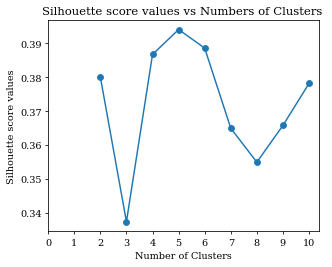

<Figure size 350x280 with 0 Axes>

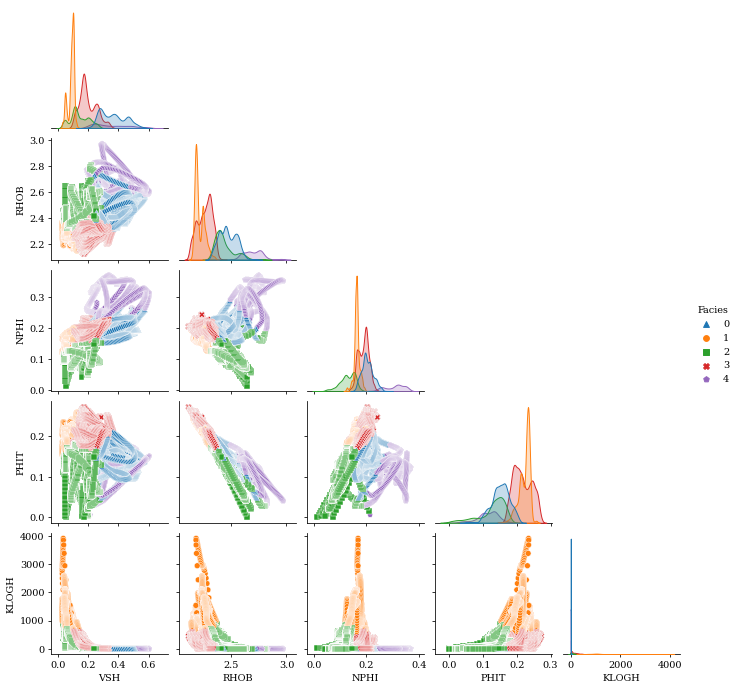

In [124]:
facies_group=['VSH','RHOB','NPHI','PHIT','KLOGH']
dfm=df_facies.dropna(subset=facies_group)
data_scaled = pd.DataFrame(Prescale.fit_transform(dfm[facies_group]), 
                        index=dfm[facies_group].index,
                        columns=dfm[facies_group].columns)

pylab.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (5, 4)})
df_cluster=facies_cluster(data_scaled, name='Facies', ncomp=5, nclus=5)
dfm['Facies']=df_cluster['Facies']

plt.figure()
cluster_output = sns.pairplot(dfm, vars=facies_group, kind='scatter', diag_kind='kde', hue='Facies', 
                markers=['^','o','s','X','p'], palette=('tab10'), height=2, corner=True)
cluster_output.savefig('img/ClusterOutput.png')

In [125]:
dfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13609 entries, 0 to 13608
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DT         13609 non-null  float64
 1   NPHI       13609 non-null  float64
 2   RHOB       13609 non-null  float64
 3   Depth      13609 non-null  float64
 4   PHIT       13609 non-null  float64
 5   VSH        13609 non-null  float64
 6   KLOGH      13609 non-null  float64
 7   WELL_NAME  13609 non-null  object 
 8   Facies     13609 non-null  int32  
dtypes: float64(7), int32(1), object(1)
memory usage: 1010.0+ KB


In [126]:
f_11t2_facies = dfm[dfm['WELL_NAME']=='F_11T2']
f_11t2_facies = f_11t2_facies.drop(f_11t2_facies.columns[[0,1,2,4,5,6,7]], axis=1)
f_11t2_facies = f_11t2_facies.set_index('Depth').sort_index()
f_11t2_final_facies = pd.concat([f_11t2_final, f_11t2_facies], axis=1)
f_11t2_final_facies = f_11t2_final_facies.replace({'Facies': {1:'A',2:'C',3:'B',0:'D',4:'E'}})
# f_11t2_final_facies = f_11t2_final_facies.dropna()

f_11a_facies = dfm[dfm['WELL_NAME']=='F_11A']
f_11a_facies = f_11a_facies.drop(f_11a_facies.columns[[0,1,2,4,5,6,7]], axis=1)
f_11a_facies = f_11a_facies.set_index('Depth').sort_index()
f_11a_final_facies = pd.concat([f_11a_final, f_11a_facies], axis=1)
f_11a_final_facies = f_11a_final_facies.replace({'Facies': {1:'A',2:'C',3:'B',0:'D',4:'E'}})
# f_11a_final_facies = f_11a_final_facies.dropna()

f_11b_facies = dfm[dfm['WELL_NAME']=='F_11B']
f_11b_facies = f_11b_facies.drop(f_11b_facies.columns[[0,1,2,4,5,6,7]], axis=1)
f_11b_facies = f_11b_facies.set_index('Depth').sort_index()
f_11b_final_facies = pd.concat([f_11b_final, f_11b_facies], axis=1)
f_11b_final_facies = f_11b_final_facies.replace({'Facies': {1:'A',2:'C',3:'B',0:'D',4:'E'}})
# f_11b_final_facies = f_11b_final_facies.dropna()

f_11t2_final_facies['Facies_ALL'] = f_11t2_final_facies['Facies']
f_11t2_final_facies  = f_11t2_final_facies.replace({'Facies_ALL': {1:'A',2:'C',3:'B',0:'D',4:'E'}})
f_11a_final_facies['Facies_ALL'] = f_11a_final_facies['Facies']
f_11a_final_facies  = f_11a_final_facies.replace({'Facies_ALL': {1:'A',2:'C',3:'B',0:'D',4:'E'}})
f_11b_final_facies['Facies_ALL'] = f_11b_final_facies['Facies']
f_11b_final_facies  = f_11b_final_facies.replace({'Facies_ALL': {1:'A',2:'C',3:'B',0:'D',4:'E'}})

In [127]:
#### Create Facies Columns for plotting purposes

f_11t2_final_facies = pd.get_dummies(f_11t2_final_facies, columns=['Facies'])
f_11a_final_facies = pd.get_dummies(f_11a_final_facies, columns=['Facies'])
f_11b_final_facies = pd.get_dummies(f_11b_final_facies, columns=['Facies'])

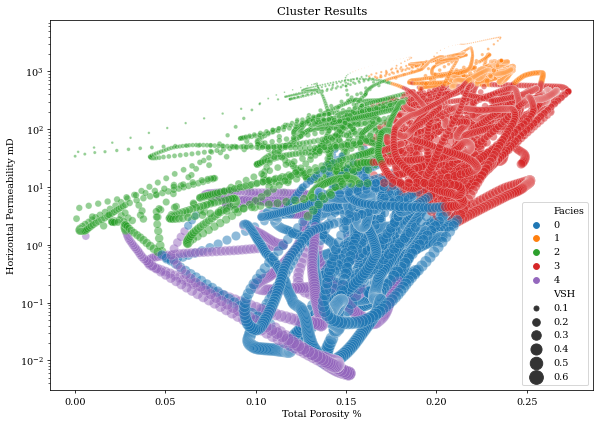

In [128]:
# Set the figure size
plt.figure(figsize=(10, 7))

# # transform my categorical column (Facies) in a numerical value group1->1, group2->2...
dfm['Facies']=pd.Categorical(dfm['Facies'])

# Scatterplot
sns.scatterplot(data=dfm, 
                x="PHIT", 
                y="KLOGH", 
                size="VSH", 
                hue="Facies", 
                alpha=0.5, 
                sizes=(0, 200))

 
# Add titles (main and on axis)
plt.yscale('log')
plt.xlabel("Total Porosity %")
plt.ylabel("Horizontal Permeability mD")
plt.title("Cluster Results")
plt.legend()

### 10.1. Final Composite Well

In [129]:
def plotalllogs3(dataframe):
#=============================================================================    
    tracks=8
    linewidth=0.5
    ## Gamma Ray, PE, ROP, CALI
    trackGR=0 #Gamma Ray
    ## Resistivity
    trackRes=1
    ## RHOB, NPHI
    trackPOR=2
    ## DT, DTS
    trackDT=3
    ## Flag
    trackFLAG=4
    ## BVW and PHIT
    trackBVW=5
    ## Calculated features
    trackMATRIX=6
    ## Facies
    trackFACIES=7
    
# =============================Parameters and formation lines=====================================    
    pylab.rcParams.update({'font.size': 10, 'font.family': 'serif'})
    fig,axes = plt.subplots(1,tracks,sharey=True,figsize=(15,9), dpi=80) ##sharey: share y axis
    fig.gca().invert_yaxis()
    
    for ax in axes:
        for (i,j) in zip(tops_depths,tops):
                ax.axhline(y=i, linewidth=1, color='red')
                ax.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center')

# ================================ [1] trackGR =============================================

    ## GR
    ax1 = axes[trackGR].twiny()
    ax1.grid(which='both')
    ax1.plot(dataframe['GR'],dataframe.index, label='GR', color='green', lw=2)
    ax1.set_xlabel('GR, [gapi]')
    ax1.set_xlim(0,250)   
    ax1.set_xticks([0, 50, 150, 250])
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.spines['top'].set_position(('outward',0))
    ax1.spines['top'].set_color('green')
    ax1.xaxis.label.set_color('green')
    ax1.tick_params(axis='x', colors='green')
    

    # https://towardsdatascience.com/enhancing-visualization-of-well-logs-with-plot-fills-72d9dcd10c1b
    left_value = 0
    right_value = 250
    span = abs(left_value-right_value)
    cmap = plt.get_cmap('hot_r')
    color_index = np.arange(left_value, right_value, span/100)   
    for index in sorted(color_index):
        index_value =(index-left_value)/span
        color = cmap(index_value)
        ax1.fill_betweenx(dataframe.index, 0, dataframe['GR'], where=dataframe['GR']>=index, color=color)
  
    ## CALI
    ax2 = axes[trackGR].twiny()
    # ax2.grid(which='both')
    ax2.plot(dataframe['CALI'],dataframe.index, label='CALI', color='magenta', lw=linewidth)
    ax2.set_xlabel('CALI, [inches]')
    ax2.set_xlim(1,10)
    ax2.set_xticks([0, 5, 10])
    ax2.xaxis.set_ticks_position('top')
    ax2.xaxis.set_label_position('top')
    ax2.spines['top'].set_position(('outward', 40))
    ax2.spines['top'].set_color('magenta')
    ax2.xaxis.label.set_color('magenta')
    ax2.tick_params(axis='x', colors='magenta')
    
    ## ROP
    ax3 = axes[trackGR].twiny()
    ax3.plot(dataframe['ROP'],dataframe.index, label='ROP', ls = '--', color='slateblue', lw=linewidth)
    ax3.set_xlabel('ROP, [m/hr]')
    ax3.set_xlim(0,100)   
    ax3.xaxis.set_ticks_position('top')
    ax3.xaxis.set_label_position('top')
    ax3.spines['top'].set_position(('outward', 80))
    ax3.spines['top'].set_color('slateblue')
    ax3.xaxis.label.set_color('slateblue')
    ax3.tick_params(axis='x', colors='slateblue')
    
    ##PE
    ax4 = axes[trackGR].twiny()
    ax4.plot(dataframe['PEF'],dataframe.index, label='PE', color='blue', ls = '--', lw=linewidth)
    ax4.set_xlabel('PE, [barns/electron]')
    ax4.set_xlim(0,10)
    ax4.set_xticks([0, 5, 10])
    ax4.xaxis.set_ticks_position('top')
    ax4.xaxis.set_label_position('top')  
    ax4.spines['top'].set_position(('outward', 120))
    ax4.spines['top'].set_color('blue')
    ax4.xaxis.label.set_color('blue')
    ax4.tick_params(axis='x', colors='blue')
    
#================================== [2] trackRes =============================================

    # Resistivity   
    ax1 = axes[trackRes].twiny()
    ax1.set_xscale('log')
    ax1.grid(which='both')
    ax1.plot(dataframe['RDEEP'],dataframe.index, label='RDEEP', color='cyan', lw=linewidth)
    ax1.plot(dataframe['RMED'],dataframe.index, label='RMED',color='lime', ls = '--', lw=linewidth)
    ax1.plot(dataframe['RT'],dataframe.index, label='RT',color='darkblue', ls = '--', lw=1)
    ax1.set_xlabel('Resistivity, [ohm.m]')
    ax1.spines['top'].set_position(('outward', 0))
    ax1.legend(loc=1)
    ax1.set_xlim(0.1,1000)
    ax1.set_xticks([0.1, 1, 10, 100, 1000])
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')
    ax1.xaxis.set_major_formatter(ScalarFormatter())
    
    # Permeability
    ax2 = axes[trackRes].twiny()
    ax2.set_xscale('log')
    ax2.plot(dataframe['KLOGH'],dataframe.index, label='KLOGH', color='red', lw=linewidth)
    ax2.set_xlabel('KLOGH, [mDarcy]')
    ax2.spines['top'].set_position(('outward', 40))
    ax2.set_xlim(0.02,20000)
    ax2.set_xticks([0.02, 2, 200, 20000])
    ax2.xaxis.set_ticks_position('top')
    ax2.xaxis.set_label_position('top')
    ax2.fill_betweenx(dataframe.index,0.02,dataframe.KLOGH,color='orange',alpha=0.1)
    ax2.xaxis.set_major_formatter(ScalarFormatter())
    ax2.spines['top'].set_color('red')
    ax2.xaxis.label.set_color('red')
    ax2.tick_params(axis='x', colors='red')
# ==================================== [3] trackPOR =========================================

    ## RHOB
    ax1 = axes[trackPOR].twiny()
    ax1.plot(dataframe['RHOB'],dataframe.index, label=r'$\rho_b$', color='red', lw=1)
    ax1.set_xlabel(r'$\rho_b, g/cc$')
    ax1.set_xlim(1.95,2.95)
    ax1.set_xticks([1.95, 2.2, 2.45, 2.7, 2.95])
    ax1.spines['top'].set_position(('outward', 40))
    ax1.xaxis.set_ticks_position('top') # set the position of the second x-axis to top
    ax1.xaxis.set_label_position('top') # set the position of the second x-axis to top
    ax1.legend(bbox_to_anchor=(0.6, .9))
    ax1.spines['top'].set_color('red')
    ax1.xaxis.label.set_color('red')
    ax1.tick_params(axis='x', colors='red')
    
    ##NPHI
    ax2 = axes[trackPOR]
    ax2.grid(which='both')
    ax2.plot(dataframe['NPHI'],dataframe.index, label=r'$\phi_N$', color='blue', lw=2)
    ax2.set_xlim(0.45, -0.15)
    ax2.set_xticks([0.45, 0.3, 0.15, 0, -0.15])
    ax2.set_xlabel(r'$\phi_N$, %') 
    ax2.legend(bbox_to_anchor=(0.6, 1))
    ax2.xaxis.set_label_position('top') # set the position of the second x-axis to top
    ax2.xaxis.set_ticks_position('top')
    ax2.spines['top'].set_color('blue')
    ax2.xaxis.label.set_color('blue')
    ax2.tick_params(axis='x', colors='blue')

    
    # https://towardsdatascience.com/enhancing-visualization-of-well-logs-with-plot-fills-72d9dcd10c1b
    x1=dataframe['RHOB']
    x2=dataframe['NPHI']
    x = np.array(ax1.get_xlim())
    z = np.array(ax2.get_xlim())
    nz=((x2-np.max(z))/(np.min(z)-np.max(z)))*(np.max(x)-np.min(x))+np.min(x)
    ax1.fill_betweenx(dataframe.index, x1, nz, where=x1>=nz, interpolate=True, color='green')
    ax1.fill_betweenx(dataframe.index, x1, nz, where=x1<=nz, interpolate=True, color='yellow')

# ==================================== [4] trackDT =========================================    
    
    ## DTC & DTS
    ax1 = axes[trackDT]
    ax1.grid(which='both')
    ax1.plot(dataframe['DT'],dataframe.index, label='DTC', lw=linewidth, color='blue')
    ax1.plot(dataframe['DTS'],dataframe.index, label='DTS', lw=linewidth, color='red')
    ax1.set_xlabel('DT/DTS')
    ax1.set_xlim(500,40)
    ax1.set_xlim(240,40)
    ax1.set_xticks([240, 140, 40])
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')


# ==================================== [5] trackFLAG =========================================
    
    ## Mudlog Litho Flags
    ax1 = axes[trackFLAG].twiny()
    ax1.grid(which='both')
    ax1.plot(dataframe['Lithology_A'],dataframe.index, label='Lithology_A',color='black', lw=linewidth)
    ax1.plot(dataframe['Lithology_B'],dataframe.index, label='Lithology_B',color='black', lw=linewidth)
    ax1.plot(dataframe['Lithology_C'],dataframe.index, label='Lithology_C',color='black', lw=linewidth)
    ax1.plot(dataframe['Lithology_D'],dataframe.index, label='Lithology_D',color='black', lw=linewidth)
    # ax1.plot(dataframe['Lithology_E'],dataframe.index, label='Lithology_E',color='black', lw=linewidth)
    # ax1.plot(dataframe['Lithology_F'],dataframe.index, label='Lithology_F',color='black', lw=linewidth)
    ax1.set_xlabel('Cuttings')
    ax1.spines['top'].set_position(('outward', 0))
    ax1.set_xlim(1, 0)
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')

    ax2 = axes[trackFLAG].twiny()
    ax2.set_xlim(1, 0)
    ax2.spines['top'].set_position(('outward',0))
    ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_A,facecolor='lightgray',label='Lithology_A')
    ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_B,facecolor='cyan',label='Lithology_B')
    ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_C,facecolor='yellow',label= 'Lithology_C')
    ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_D,color='black',label= 'Lithology_D')
    # ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_E,color='blue',label= 'Lithology_E')
    # ax2.fill_betweenx(dataframe.index,0, dataframe.Lithology_F,color='white',label= 'Lithology_F')
    ax2.legend(loc='lower left')
    
    ## SAND_FLAG
    ax3 = axes[trackFLAG].twiny()
    ax3.fill_betweenx(dataframe.index, dataframe.SAND_FLAG, 0, where=(dataframe.SAND_FLAG > 0), color='red')
    ax3.set_xlim(0,10) 
    ax3.set_xlabel('SAND_FLAG')
    # ax3.tick_params(axis='x')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('outward', 40))
    ax3.spines['top'].set_color('red')
    ax3.xaxis.label.set_color('red')
    ax3.tick_params(axis='x', colors='red')
    

# ==================================== [6] trackBVW =========================================

    ## BVW
    ax1 = axes[trackBVW].twiny()
    ax1.grid(which='both')
    ax1.plot(dataframe['BVW'],dataframe.index, label='BVW', lw=linewidth)
    ax1.set_xlabel('BWV, [v/v]')
    ax1.set_xlim(1,0)
    ax1.set_xticks([1, 0.8, 0.6, 0.4, 0.2, 0])
    ax1.spines['top'].set_position(('outward',0))
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')  
    ax1.fill_betweenx(dataframe.index,0,dataframe.BVW,color='lightblue')
    # ax1.spines['top'].set_color('blue')
    # ax1.xaxis.label.set_color('blue')
    # ax1.tick_params(axis='x', colors='blue')
    
    ## PHIT
    ax2 = axes[trackBVW].twiny()
    # ax2.grid(which='both')
    ax2.plot(dataframe['PHIT'],dataframe.index, label='PHIT', lw=1, color='red')
    ax2.set_xlabel('PHIT, [v/v]')
    ax2.set_xlim(1,0)
    ax2.set_xticks([1, 0.8, 0.6, 0.4, 0.2, 0])
    ax2.spines['top'].set_position(('outward', 40))
    ax2.xaxis.set_ticks_position('top')
    ax2.xaxis.set_label_position('top')  
    ax2.spines['top'].set_color('red')
    ax2.xaxis.label.set_color('red')
    ax2.tick_params(axis='x', colors='red')
    
    ## SW
    ax3 = axes[trackBVW].twiny()
    # ax3.grid(which='both')
    ax3.plot(dataframe['SW'],dataframe.index, label='SW', lw=linewidth, color='black')
    ax3.set_xlabel('SW, [v/v]')
    ax3.set_xlim(1,0)
    ax3.set_xticks([1, 0.8, 0.6, 0.4, 0.2, 0])
    ax3.spines['top'].set_position(('outward', 80))
    ax3.xaxis.set_ticks_position('top')
    ax3.xaxis.set_label_position('top')
    ax3.fill_betweenx(dataframe.index,0,dataframe.SW,color='cyan', alpha=0.1)
    ax3.spines['top'].set_color('blue')
    ax3.xaxis.label.set_color('blue')
    ax3.tick_params(axis='x', colors='blue')
    
# ==================================== [7] trackMATRIX =========================================
    
    ## PHIT
    ax1 = axes[trackMATRIX].twiny()
    ax1.grid(which='both')
    ax1.plot(dataframe['PHIT'],dataframe.index, label='PHIT', color='blue', lw=linewidth)
    ax1.set_xlim(0, 1)
    ax1.set_xlabel('PHIT, [v/v]') 
    # ax8.legend(bbox_to_anchor=(0.6, 1))
    ax1.spines['top'].set_position(('outward',0))
    ax1.xaxis.set_label_position('top') # set the position of the second x-axis to top
    ax1.xaxis.set_ticks_position('top')
    # ax8.set_xticks([0, 20, 40, 60, 80, 100])
    ax1.tick_params(axis='x', colors='blue')
    ax1.xaxis.label.set_color('blue')
    
    ## VSH
    ax2 = axes[trackMATRIX].twiny()
    ax2.grid(which='both')
    ax2.plot(dataframe['VSH'],dataframe.index, label='VSH', color='green', lw=linewidth)
    ax2.set_xlim(1, 0)
    ax2.set_xlabel('VSH, [v/v]') 
    # ax2.legend(bbox_to_anchor=(0.6, 1))
    ax2.spines['top'].set_position(('outward',40))
    ax2.xaxis.set_label_position('top') # set the position of the second x-axis to top
    ax2.xaxis.set_ticks_position('top')
    # ax2.tick_params(axis='x', colors='green')
    # ax2.set_xticks([0, 20, 40, 60, 80, 100])
    
    ax3 = axes[trackMATRIX].twiny()
    ax3.set_xlim(1,0)
    ax3.spines['top'].set_position(('outward',0))
    ax3.fill_betweenx(dataframe.index,0,dataframe.PHIT,color='lightblue',label='porosity')
    ax3.fill_betweenx(dataframe.index,dataframe.PHIT,1-dataframe.VSH,color='yellow',label='matrix')
    ax3.fill_betweenx(dataframe.index,1-dataframe.VSH,1,color='lightgray',label= 'vshale')
    ax3.legend(loc='lower left')

# ==================================== [8] trackFACIES ============================================

    ## Clustered Litho Facies
    ax1 = axes[trackFACIES].twiny()
    ax1.grid(which='both')
    # ax1.plot(dataframe['Facies_ALL'],dataframe.index, label='',color='black', lw=linewidth)
    ax1.plot(dataframe['Facies_A'],dataframe.index, label='Facies_A',color='black', lw=linewidth, drawstyle="steps")
    ax1.plot(dataframe['Facies_B'],dataframe.index, label='Facies_B',color='black', lw=linewidth, drawstyle="steps")
    ax1.plot(dataframe['Facies_C'],dataframe.index, label='Facies_C',color='black', lw=linewidth, drawstyle="steps")
    ax1.plot(dataframe['Facies_D'],dataframe.index, label='Facies_D',color='black', lw=linewidth, drawstyle="steps")
    ax1.plot(dataframe['Facies_E'],dataframe.index, label='Facies_E',color='black', lw=linewidth, drawstyle="steps")
    ax1.set_xlabel('Facies')
    ax1.spines['top'].set_position(('outward', 0))
    ax1.set_xlim(0, 1)
    ax1.xaxis.set_ticks_position('top')
    ax1.xaxis.set_label_position('top')

    ax2 = axes[trackFACIES].twiny()
    ax2.set_xlim(0, 1)
    ax2.spines['top'].set_position(('outward',0))
    ax2.fill_betweenx(dataframe.index, 0, dataframe['Facies_A'], facecolor='yellow',label='Facies_A', hatch='..')
    ax2.fill_betweenx(dataframe.index, 0, dataframe['Facies_B'], facecolor='gold',label='Facies_B', hatch='...')
    ax2.fill_betweenx(dataframe.index, 0, dataframe['Facies_C'], facecolor='darkkhaki',label= 'Facies_C', hatch='....')
    ax2.fill_betweenx(dataframe.index, 0, dataframe['Facies_D'], facecolor='olive',label= 'Facies_D')
    ax2.fill_betweenx(dataframe.index, 0, dataframe['Facies_E'], facecolor='dimgray',label= 'Facies_E', hatch='--')
    ax2.legend(loc='upper left')
    

#### 10.1.1. F_11T2

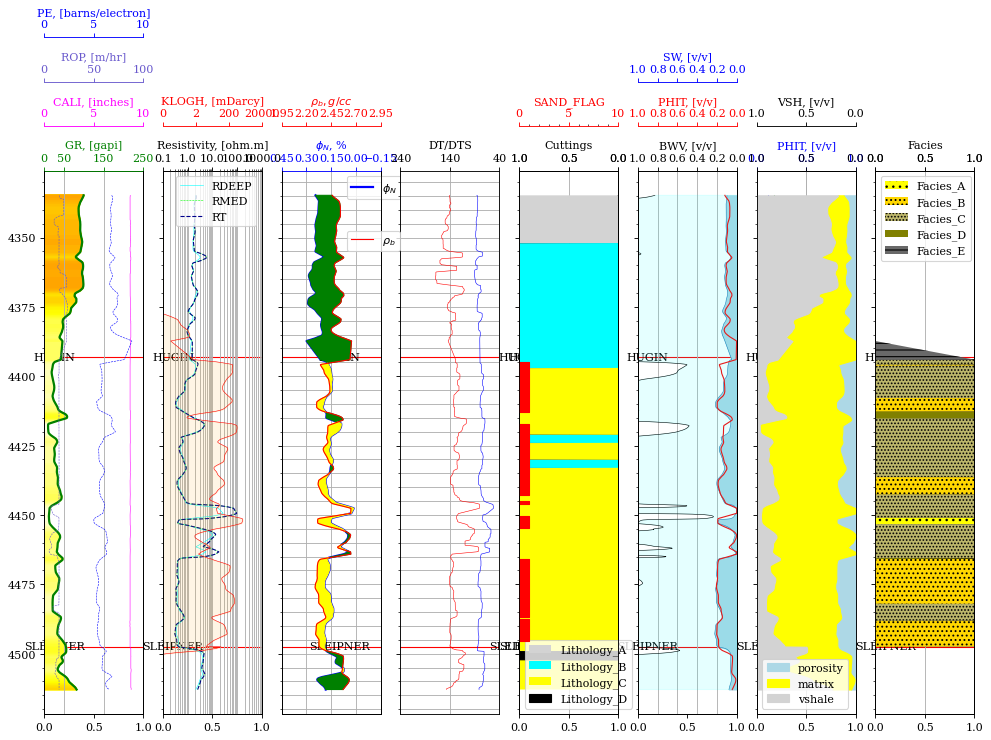

In [130]:
tops = ['HUGIN', 'SLEIPNER']
tops_depths=[4393.0, 4497.4]
plotalllogs3(f_11t2_final_facies)

#### 10.1.1. F_11T2

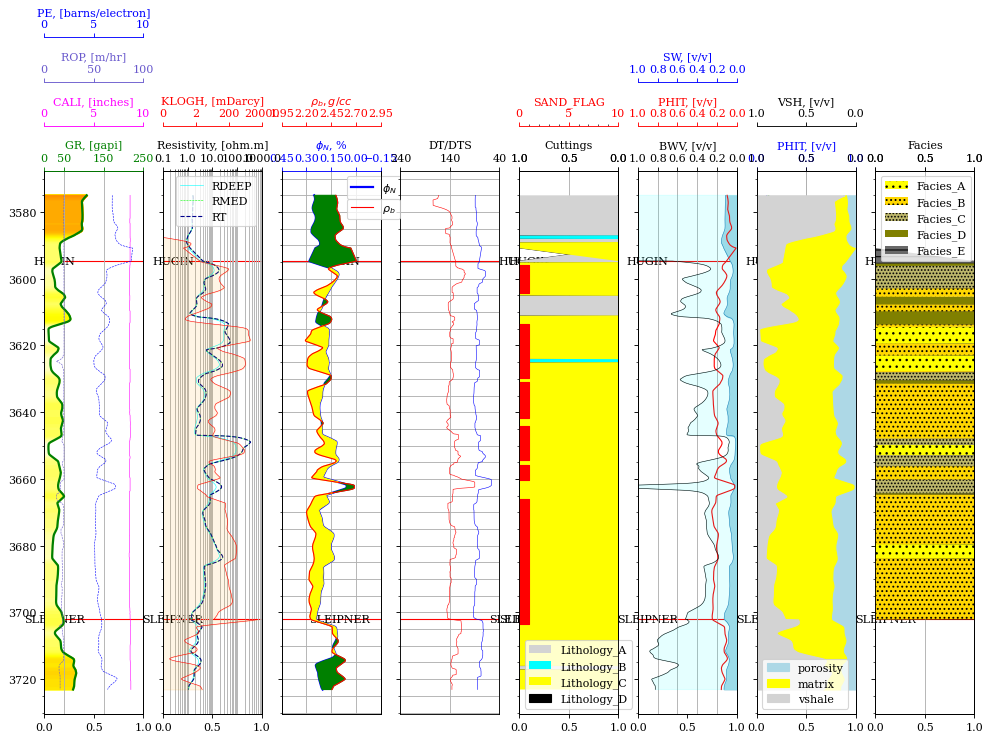

In [131]:
tops = ['HUGIN', 'SLEIPNER']
tops_depths=[3594.6, 3702]
plotalllogs3(f_11a_final_facies)

#### 10.1.3. F_11B

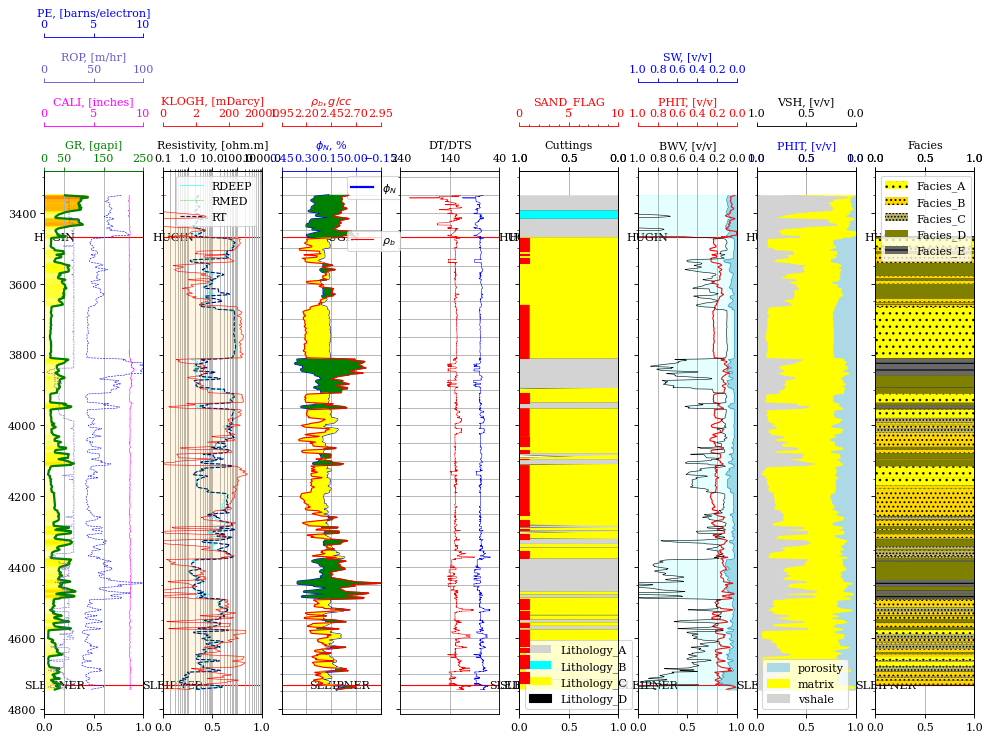

In [132]:
tops = ['HUGIN', 'SLEIPNER']
tops_depths=[3467.5, 4732]
plotalllogs3(f_11b_final_facies)